##### Copyright 2019 The TensorFlow Hub Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
# Copyright 2019 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS, 
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# Bangla Article Classification With TF-Hub

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/hub/tutorials/bangla_article_classifier"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/hub/tutorials/bangla_article_classifier.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/hub/tutorials/bangla_article_classifier.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/hub/tutorials/bangla_article_classifier.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

Caution: In addition to installing Python packages with pip, this notebook uses
`sudo apt install` to install system packages: `unzip`.

This Colab is a demonstration of using [Tensorflow Hub](https://www.tensorflow.org/hub/) for text classification in non-English/local languages. Here we choose [Bangla](https://en.wikipedia.org/wiki/Bengali_language) as the local language and use pretrained word embeddings to solve a multiclass classification task where we classify Bangla news articles in 5 categories.  The pretrained embeddings for Bangla comes from [fastText](https://fasttext.cc/docs/en/crawl-vectors.html) which is a library by Facebook with released pretrained word vectors for 157 languages. 

We'll use TF-Hub's pretrained embedding exporter for converting the word embeddings to a text embedding module first and then use the module to train a classifier with [tf.keras](https://www.tensorflow.org/api_docs/python/tf/keras), Tensorflow's high level user friendly API to build deep learning models.  Even if we are using fastText embeddings here, it's possible to export any other embeddings pretrained from other tasks and quickly get results with Tensorflow hub. 

## Setup

In [2]:
%%bash
# https://github.com/pypa/setuptools/issues/1694#issuecomment-466010982
pip install gdown --no-use-pep517

In [3]:
%%bash
sudo apt-get install -y unzip

Reading package lists...


Building dependency tree...


Reading state information...


unzip is already the newest version (6.0-25ubuntu1.1).


The following packages were automatically installed and are no longer required:


  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2


  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2


  libparted-fs-resize0 libxmlb2


Use 'sudo apt autoremove' to remove them.


0 upgraded, 0 newly installed, 0 to remove and 159 not upgraded.


In [4]:
import os

import tensorflow as tf
import tensorflow_hub as hub

import gdown
import numpy as np
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns

2024-02-02 12:29:03.681459: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-02 12:29:03.681511: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-02 12:29:03.683037: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Dataset

We will use [BARD](https://www.researchgate.net/publication/328214545_BARD_Bangla_Article_Classification_Using_a_New_Comprehensive_Dataset) (Bangla Article Dataset) which has around 376,226 articles collected from different Bangla news portals and labelled with 5 categories: economy, state, international, sports, and entertainment. We download the file from Google Drive this ([bit.ly/BARD_DATASET](https://bit.ly/BARD_DATASET)) link is referring to from [this](https://github.com/tanvirfahim15/BARD-Bangla-Article-Classifier) GitHub repository.


In [5]:
gdown.download(
    url='https://drive.google.com/uc?id=1Ag0jd21oRwJhVFIBohmX_ogeojVtapLy',
    output='bard.zip',
    quiet=True
)

'bard.zip'

In [6]:
%%bash
unzip -qo bard.zip

# Export pretrained word vectors to TF-Hub module

TF-Hub provides some useful scripts for converting word embeddings to TF-hub text embedding modules [here](https://github.com/tensorflow/hub/tree/master/examples/text_embeddings_v2). To make the module for Bangla or any other languages, we simply have to download the word embedding `.txt` or `.vec` file to the same directory as `export_v2.py` and run the script.


The exporter reads the embedding vectors and exports it to a Tensorflow [SavedModel](https://www.tensorflow.org/beta/guide/saved_model). A SavedModel contains a complete TensorFlow program including weights and graph. TF-Hub can load the SavedModel as a [module](https://www.tensorflow.org/hub/api_docs/python/hub/Module), which we will use to build the model for text classification. Since we are using `tf.keras` to build the model, we will use [hub.KerasLayer](https://www.tensorflow.org/hub/api_docs/python/hub/KerasLayer), which provides a wrapper for a TF-Hub module to use as a Keras Layer.

First we will get our word embeddings from fastText and embedding exporter from TF-Hub [repo](https://github.com/tensorflow/hub).


In [7]:
%%bash
curl -O https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.bn.300.vec.gz
curl -O https://raw.githubusercontent.com/tensorflow/hub/master/examples/text_embeddings_v2/export_v2.py
gunzip -qf cc.bn.300.vec.gz --k

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current


                                 Dload  Upload   Total   Spent    Left  Speed


100  840M  100  840M    0     0  42.9M      0  0:00:19  0:00:19 --:--:-- 40.4M


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current


                                 Dload  Upload   Total   Spent    Left  Speed


100  7500  100  7500    0     0  56818      0 --:--:-- --:--:-- --:--:-- 56818


Then, we will run the exporter script on our embedding file. Since fastText embeddings have a header line and are pretty large (around 3.3 GB for Bangla after converting to a module) we ignore the first line and export only the first 100, 000 tokens to the text embedding module.

In [8]:
%%bash
python export_v2.py --embedding_file=cc.bn.300.vec --export_path=text_module --num_lines_to_ignore=1 --num_lines_to_use=100000

2024-02-02 12:30:25.110154: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered


2024-02-02 12:30:25.110207: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered


2024-02-02 12:30:25.111689: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2024-02-02 12:30:27.321508: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


INFO:tensorflow:Assets written to: text_module/assets


I0202 12:30:40.352254 140300656232256 builder_impl.py:801] Assets written to: text_module/assets


I0202 12:30:40.356071 140300656232256 fingerprinting_utils.py:49] Writing fingerprint to text_module/fingerprint.pb


In [9]:
module_path = "text_module"
embedding_layer = hub.KerasLayer(module_path, trainable=False)

2024-02-02 12:30:41.057019: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


The text embedding module takes a batch of sentences in a 1D tensor of strings as input and outputs the embedding vectors of shape (batch_size, embedding_dim) corresponding to the sentences. It preprocesses the input by splitting on spaces. Word embeddings are combined to sentence embeddings with the `sqrtn` combiner(See [here](https://www.tensorflow.org/api_docs/python/tf/nn/embedding_lookup_sparse)). For demonstration we pass a list of Bangla words as input and get the corresponding embedding vectors.

In [10]:
embedding_layer(['বাস', 'বসবাস', 'ট্রেন', 'যাত্রী', 'ট্রাক']) 

<tf.Tensor: shape=(5, 300), dtype=float64, numpy=
array([[ 0.0462, -0.0355,  0.0129, ...,  0.0025, -0.0966,  0.0216],
       [-0.0631, -0.0051,  0.085 , ...,  0.0249, -0.0149,  0.0203],
       [ 0.1371, -0.069 , -0.1176, ...,  0.029 ,  0.0508, -0.026 ],
       [ 0.0532, -0.0465, -0.0504, ...,  0.02  , -0.0023,  0.0011],
       [ 0.0908, -0.0404, -0.0536, ..., -0.0275,  0.0528,  0.0253]])>

# Convert to Tensorflow Dataset 


Since the dataset is really large instead of loading the entire dataset in memory we will use a generator to yield samples in run-time in batches using [Tensorflow Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) functions. The dataset is also very imbalanced, so, before using the generator, we will shuffle the dataset. 


In [11]:
dir_names = ['economy', 'sports', 'entertainment', 'state', 'international']

file_paths = []
labels = []
for i, dir in enumerate(dir_names):
  file_names = ["/".join([dir, name]) for name in os.listdir(dir)]
  file_paths += file_names
  labels += [i] * len(os.listdir(dir))
  
np.random.seed(42)
permutation = np.random.permutation(len(file_paths))

file_paths = np.array(file_paths)[permutation]
labels = np.array(labels)[permutation]

We can check the distribution of labels in the training and validation examples after shuffling.

In [12]:
train_frac = 0.8
train_size = int(len(file_paths) * train_frac)

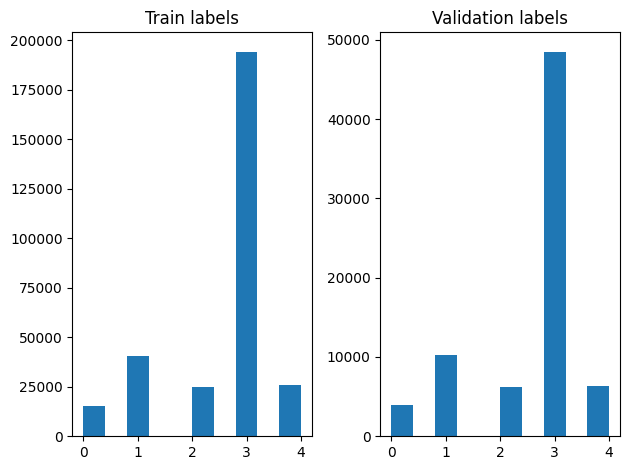

In [13]:
# plot training vs validation distribution
plt.subplot(1, 2, 1)
plt.hist(labels[0:train_size])
plt.title("Train labels")
plt.subplot(1, 2, 2)
plt.hist(labels[train_size:])
plt.title("Validation labels")
plt.tight_layout()

To create a [Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) using a generator, we first write a generator function which reads each of the articles from `file_paths` and the labels from the label array, and yields one training example at each step. We pass this generator function to the [`tf.data.Dataset.from_generator`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#from_generator) method and specify the output types. Each training example is a tuple containing an article of `tf.string` data type and one-hot encoded label. We split the dataset with a train-validation split of 80-20 using [`tf.data.Dataset.skip`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#skip) and [`tf.data.Dataset.take`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#take) methods.

In [14]:
def load_file(path, label):
    return tf.io.read_file(path), label

In [15]:
def make_datasets(train_size):
  batch_size = 256

  train_files = file_paths[:train_size]
  train_labels = labels[:train_size]
  train_ds = tf.data.Dataset.from_tensor_slices((train_files, train_labels))
  train_ds = train_ds.map(load_file).shuffle(5000)
  train_ds = train_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

  test_files = file_paths[train_size:]
  test_labels = labels[train_size:]
  test_ds = tf.data.Dataset.from_tensor_slices((test_files, test_labels))
  test_ds = test_ds.map(load_file)
  test_ds = test_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)


  return train_ds, test_ds

In [16]:
train_data, validation_data = make_datasets(train_size)

# Model Training and Evaluation

Since we have already added a wrapper around our module to use it as any other layer in Keras, we can create a small [Sequential](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential) model which is a linear stack of layers. We can add our text embedding module with `model.add` just like any other layer. We compile the model by specifying the loss and optimizer and train it for 10 epochs. The `tf.keras` API can handle Tensorflow Datasets as input, so we can pass a Dataset instance to the fit method for model training. Since we are using the generator function, `tf.data` will handle generating the samples, batching them and feeding them to the model.

## Model

In [17]:
def create_model():
  model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=[], dtype=tf.string),
    embedding_layer,
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(5),
  ])
  model.compile(loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
      optimizer="adam", metrics=['accuracy'])
  return model

In [18]:
model = create_model()
# Create earlystopping callback
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3)

## Training

In [19]:
history = model.fit(train_data, 
                    validation_data=validation_data, 
                    epochs=5, 
                    callbacks=[early_stopping_callback])

Epoch 1/5


   1/1176 [..............................] - ETA: 16:25 - loss: 1.4851 - accuracy: 0.4023

   3/1176 [..............................] - ETA: 33s - loss: 1.4129 - accuracy: 0.5508  

   5/1176 [..............................] - ETA: 34s - loss: 1.3228 - accuracy: 0.5992

   7/1176 [..............................] - ETA: 34s - loss: 1.2741 - accuracy: 0.6077

   9/1176 [..............................] - ETA: 34s - loss: 1.2351 - accuracy: 0.6146

  11/1176 [..............................] - ETA: 34s - loss: 1.2028 - accuracy: 0.6193

  13/1176 [..............................] - ETA: 33s - loss: 1.1682 - accuracy: 0.6250

  15/1176 [..............................] - ETA: 33s - loss: 1.1473 - accuracy: 0.6240

  17/1176 [..............................] - ETA: 33s - loss: 1.1234 - accuracy: 0.6257

  19/1176 [..............................] - ETA: 33s - loss: 1.1009 - accuracy: 0.6281

  21/1176 [..............................] - ETA: 33s - loss: 1.0760 - accuracy: 0.6380

  23/1176 [..............................] - ETA: 33s - loss: 1.0510 - accuracy: 0.6474

  25/1176 [..............................] - ETA: 32s - loss: 1.0298 - accuracy: 0.6570

  27/1176 [..............................] - ETA: 32s - loss: 1.0120 - accuracy: 0.6645

  29/1176 [..............................] - ETA: 32s - loss: 0.9937 - accuracy: 0.6711

  31/1176 [..............................] - ETA: 32s - loss: 0.9743 - accuracy: 0.6784

  33/1176 [..............................] - ETA: 32s - loss: 0.9593 - accuracy: 0.6838

  35/1176 [..............................] - ETA: 32s - loss: 0.9452 - accuracy: 0.6886

  37/1176 [..............................] - ETA: 32s - loss: 0.9285 - accuracy: 0.6951

  39/1176 [..............................] - ETA: 32s - loss: 0.9168 - accuracy: 0.6986

  41/1176 [>.............................] - ETA: 32s - loss: 0.9001 - accuracy: 0.7046

  43/1176 [>.............................] - ETA: 31s - loss: 0.8859 - accuracy: 0.7089

  45/1176 [>.............................] - ETA: 31s - loss: 0.8728 - accuracy: 0.7126

  47/1176 [>.............................] - ETA: 31s - loss: 0.8586 - accuracy: 0.7168

  49/1176 [>.............................] - ETA: 31s - loss: 0.8458 - accuracy: 0.7209

  51/1176 [>.............................] - ETA: 31s - loss: 0.8334 - accuracy: 0.7253

  53/1176 [>.............................] - ETA: 31s - loss: 0.8210 - accuracy: 0.7296

  55/1176 [>.............................] - ETA: 31s - loss: 0.8071 - accuracy: 0.7341

  57/1176 [>.............................] - ETA: 31s - loss: 0.7950 - accuracy: 0.7377

  59/1176 [>.............................] - ETA: 31s - loss: 0.7823 - accuracy: 0.7416

  61/1176 [>.............................] - ETA: 31s - loss: 0.7698 - accuracy: 0.7453

  63/1176 [>.............................] - ETA: 31s - loss: 0.7608 - accuracy: 0.7480

  65/1176 [>.............................] - ETA: 30s - loss: 0.7509 - accuracy: 0.7511

  67/1176 [>.............................] - ETA: 30s - loss: 0.7421 - accuracy: 0.7541

  69/1176 [>.............................] - ETA: 30s - loss: 0.7316 - accuracy: 0.7579

  71/1176 [>.............................] - ETA: 30s - loss: 0.7226 - accuracy: 0.7603

  73/1176 [>.............................] - ETA: 30s - loss: 0.7131 - accuracy: 0.7640

  75/1176 [>.............................] - ETA: 30s - loss: 0.7033 - accuracy: 0.7676

  77/1176 [>.............................] - ETA: 30s - loss: 0.6957 - accuracy: 0.7701

  79/1176 [=>............................] - ETA: 30s - loss: 0.6876 - accuracy: 0.7727

  81/1176 [=>............................] - ETA: 30s - loss: 0.6803 - accuracy: 0.7753

  83/1176 [=>............................] - ETA: 30s - loss: 0.6722 - accuracy: 0.7780

  85/1176 [=>............................] - ETA: 30s - loss: 0.6643 - accuracy: 0.7807

  87/1176 [=>............................] - ETA: 29s - loss: 0.6573 - accuracy: 0.7830

  89/1176 [=>............................] - ETA: 29s - loss: 0.6511 - accuracy: 0.7851

  91/1176 [=>............................] - ETA: 29s - loss: 0.6445 - accuracy: 0.7877

  93/1176 [=>............................] - ETA: 29s - loss: 0.6375 - accuracy: 0.7900

  95/1176 [=>............................] - ETA: 29s - loss: 0.6308 - accuracy: 0.7924

  97/1176 [=>............................] - ETA: 29s - loss: 0.6242 - accuracy: 0.7946

  99/1176 [=>............................] - ETA: 29s - loss: 0.6177 - accuracy: 0.7966

 101/1176 [=>............................] - ETA: 29s - loss: 0.6112 - accuracy: 0.7990

 103/1176 [=>............................] - ETA: 29s - loss: 0.6056 - accuracy: 0.8009

 105/1176 [=>............................] - ETA: 29s - loss: 0.5998 - accuracy: 0.8030

 107/1176 [=>............................] - ETA: 29s - loss: 0.5945 - accuracy: 0.8048

 109/1176 [=>............................] - ETA: 29s - loss: 0.5883 - accuracy: 0.8069

 111/1176 [=>............................] - ETA: 29s - loss: 0.5831 - accuracy: 0.8087

 113/1176 [=>............................] - ETA: 29s - loss: 0.5780 - accuracy: 0.8101

 115/1176 [=>............................] - ETA: 29s - loss: 0.5732 - accuracy: 0.8116

 117/1176 [=>............................] - ETA: 28s - loss: 0.5677 - accuracy: 0.8136

 119/1176 [==>...........................] - ETA: 28s - loss: 0.5626 - accuracy: 0.8153

 121/1176 [==>...........................] - ETA: 28s - loss: 0.5573 - accuracy: 0.8170

 123/1176 [==>...........................] - ETA: 28s - loss: 0.5532 - accuracy: 0.8185

 126/1176 [==>...........................] - ETA: 28s - loss: 0.5465 - accuracy: 0.8205

 128/1176 [==>...........................] - ETA: 28s - loss: 0.5428 - accuracy: 0.8215

 130/1176 [==>...........................] - ETA: 28s - loss: 0.5387 - accuracy: 0.8230

 132/1176 [==>...........................] - ETA: 28s - loss: 0.5351 - accuracy: 0.8241

 134/1176 [==>...........................] - ETA: 28s - loss: 0.5308 - accuracy: 0.8255

 136/1176 [==>...........................] - ETA: 28s - loss: 0.5264 - accuracy: 0.8271

 138/1176 [==>...........................] - ETA: 28s - loss: 0.5226 - accuracy: 0.8284

 140/1176 [==>...........................] - ETA: 28s - loss: 0.5187 - accuracy: 0.8296

 142/1176 [==>...........................] - ETA: 28s - loss: 0.5148 - accuracy: 0.8308

 144/1176 [==>...........................] - ETA: 28s - loss: 0.5117 - accuracy: 0.8317

 146/1176 [==>...........................] - ETA: 27s - loss: 0.5083 - accuracy: 0.8327

 148/1176 [==>...........................] - ETA: 27s - loss: 0.5041 - accuracy: 0.8342

 150/1176 [==>...........................] - ETA: 27s - loss: 0.5003 - accuracy: 0.8355

 152/1176 [==>...........................] - ETA: 27s - loss: 0.4968 - accuracy: 0.8367

 154/1176 [==>...........................] - ETA: 27s - loss: 0.4927 - accuracy: 0.8381

 156/1176 [==>...........................] - ETA: 27s - loss: 0.4895 - accuracy: 0.8391

 158/1176 [===>..........................] - ETA: 27s - loss: 0.4864 - accuracy: 0.8400

 160/1176 [===>..........................] - ETA: 27s - loss: 0.4834 - accuracy: 0.8409

 162/1176 [===>..........................] - ETA: 27s - loss: 0.4798 - accuracy: 0.8421

 164/1176 [===>..........................] - ETA: 27s - loss: 0.4764 - accuracy: 0.8431

 166/1176 [===>..........................] - ETA: 27s - loss: 0.4738 - accuracy: 0.8439

 168/1176 [===>..........................] - ETA: 27s - loss: 0.4705 - accuracy: 0.8449

 170/1176 [===>..........................] - ETA: 27s - loss: 0.4672 - accuracy: 0.8459

 172/1176 [===>..........................] - ETA: 27s - loss: 0.4644 - accuracy: 0.8469

 174/1176 [===>..........................] - ETA: 27s - loss: 0.4617 - accuracy: 0.8477

 176/1176 [===>..........................] - ETA: 27s - loss: 0.4589 - accuracy: 0.8487

 178/1176 [===>..........................] - ETA: 27s - loss: 0.4564 - accuracy: 0.8495

 180/1176 [===>..........................] - ETA: 27s - loss: 0.4541 - accuracy: 0.8502

 182/1176 [===>..........................] - ETA: 26s - loss: 0.4512 - accuracy: 0.8510

 184/1176 [===>..........................] - ETA: 26s - loss: 0.4492 - accuracy: 0.8517

 186/1176 [===>..........................] - ETA: 26s - loss: 0.4469 - accuracy: 0.8525

 188/1176 [===>..........................] - ETA: 26s - loss: 0.4446 - accuracy: 0.8532

 190/1176 [===>..........................] - ETA: 26s - loss: 0.4420 - accuracy: 0.8541

 192/1176 [===>..........................] - ETA: 26s - loss: 0.4398 - accuracy: 0.8547

 194/1176 [===>..........................] - ETA: 26s - loss: 0.4377 - accuracy: 0.8554

 196/1176 [====>.........................] - ETA: 26s - loss: 0.4359 - accuracy: 0.8560

 198/1176 [====>.........................] - ETA: 26s - loss: 0.4335 - accuracy: 0.8568

 200/1176 [====>.........................] - ETA: 26s - loss: 0.4313 - accuracy: 0.8577

 202/1176 [====>.........................] - ETA: 26s - loss: 0.4287 - accuracy: 0.8585

 204/1176 [====>.........................] - ETA: 26s - loss: 0.4262 - accuracy: 0.8594

 206/1176 [====>.........................] - ETA: 26s - loss: 0.4241 - accuracy: 0.8600

 208/1176 [====>.........................] - ETA: 26s - loss: 0.4222 - accuracy: 0.8607

 211/1176 [====>.........................] - ETA: 26s - loss: 0.4190 - accuracy: 0.8618

 213/1176 [====>.........................] - ETA: 26s - loss: 0.4166 - accuracy: 0.8626

 215/1176 [====>.........................] - ETA: 25s - loss: 0.4147 - accuracy: 0.8631

 217/1176 [====>.........................] - ETA: 25s - loss: 0.4128 - accuracy: 0.8638

 219/1176 [====>.........................] - ETA: 25s - loss: 0.4109 - accuracy: 0.8643

 221/1176 [====>.........................] - ETA: 25s - loss: 0.4091 - accuracy: 0.8650

 223/1176 [====>.........................] - ETA: 25s - loss: 0.4073 - accuracy: 0.8656

 225/1176 [====>.........................] - ETA: 25s - loss: 0.4052 - accuracy: 0.8663

 227/1176 [====>.........................] - ETA: 25s - loss: 0.4034 - accuracy: 0.8670

 229/1176 [====>.........................] - ETA: 25s - loss: 0.4015 - accuracy: 0.8676

 231/1176 [====>.........................] - ETA: 25s - loss: 0.4003 - accuracy: 0.8679

 233/1176 [====>.........................] - ETA: 25s - loss: 0.3983 - accuracy: 0.8685

 235/1176 [====>.........................] - ETA: 25s - loss: 0.3969 - accuracy: 0.8690

 237/1176 [=====>........................] - ETA: 25s - loss: 0.3952 - accuracy: 0.8696

 239/1176 [=====>........................] - ETA: 25s - loss: 0.3941 - accuracy: 0.8700

 241/1176 [=====>........................] - ETA: 25s - loss: 0.3925 - accuracy: 0.8705

 243/1176 [=====>........................] - ETA: 25s - loss: 0.3908 - accuracy: 0.8710

 245/1176 [=====>........................] - ETA: 25s - loss: 0.3895 - accuracy: 0.8714

 247/1176 [=====>........................] - ETA: 25s - loss: 0.3877 - accuracy: 0.8720

 249/1176 [=====>........................] - ETA: 24s - loss: 0.3862 - accuracy: 0.8726

 251/1176 [=====>........................] - ETA: 24s - loss: 0.3844 - accuracy: 0.8731

 253/1176 [=====>........................] - ETA: 24s - loss: 0.3829 - accuracy: 0.8736

 255/1176 [=====>........................] - ETA: 24s - loss: 0.3815 - accuracy: 0.8741

 257/1176 [=====>........................] - ETA: 24s - loss: 0.3802 - accuracy: 0.8744

 259/1176 [=====>........................] - ETA: 24s - loss: 0.3790 - accuracy: 0.8748

 261/1176 [=====>........................] - ETA: 24s - loss: 0.3776 - accuracy: 0.8753

 263/1176 [=====>........................] - ETA: 24s - loss: 0.3761 - accuracy: 0.8758

 265/1176 [=====>........................] - ETA: 24s - loss: 0.3748 - accuracy: 0.8762

 267/1176 [=====>........................] - ETA: 24s - loss: 0.3733 - accuracy: 0.8768

 269/1176 [=====>........................] - ETA: 24s - loss: 0.3720 - accuracy: 0.8771

 271/1176 [=====>........................] - ETA: 24s - loss: 0.3703 - accuracy: 0.8777

 273/1176 [=====>........................] - ETA: 24s - loss: 0.3691 - accuracy: 0.8780

 275/1176 [======>.......................] - ETA: 24s - loss: 0.3678 - accuracy: 0.8784

 277/1176 [======>.......................] - ETA: 24s - loss: 0.3664 - accuracy: 0.8789

 279/1176 [======>.......................] - ETA: 24s - loss: 0.3655 - accuracy: 0.8792

 281/1176 [======>.......................] - ETA: 24s - loss: 0.3645 - accuracy: 0.8796

 283/1176 [======>.......................] - ETA: 24s - loss: 0.3630 - accuracy: 0.8801

 285/1176 [======>.......................] - ETA: 23s - loss: 0.3620 - accuracy: 0.8804

 287/1176 [======>.......................] - ETA: 23s - loss: 0.3606 - accuracy: 0.8808

 289/1176 [======>.......................] - ETA: 23s - loss: 0.3596 - accuracy: 0.8811

 291/1176 [======>.......................] - ETA: 23s - loss: 0.3585 - accuracy: 0.8814

 293/1176 [======>.......................] - ETA: 23s - loss: 0.3575 - accuracy: 0.8817

 296/1176 [======>.......................] - ETA: 23s - loss: 0.3558 - accuracy: 0.8823

 298/1176 [======>.......................] - ETA: 23s - loss: 0.3548 - accuracy: 0.8826

 300/1176 [======>.......................] - ETA: 23s - loss: 0.3540 - accuracy: 0.8829

 302/1176 [======>.......................] - ETA: 23s - loss: 0.3527 - accuracy: 0.8833

 304/1176 [======>.......................] - ETA: 23s - loss: 0.3517 - accuracy: 0.8837

 306/1176 [======>.......................] - ETA: 23s - loss: 0.3506 - accuracy: 0.8841

 308/1176 [======>.......................] - ETA: 23s - loss: 0.3495 - accuracy: 0.8844

 310/1176 [======>.......................] - ETA: 23s - loss: 0.3481 - accuracy: 0.8848

 312/1176 [======>.......................] - ETA: 23s - loss: 0.3472 - accuracy: 0.8852

 314/1176 [=======>......................] - ETA: 23s - loss: 0.3462 - accuracy: 0.8856

 316/1176 [=======>......................] - ETA: 23s - loss: 0.3447 - accuracy: 0.8861

 318/1176 [=======>......................] - ETA: 23s - loss: 0.3435 - accuracy: 0.8865

 320/1176 [=======>......................] - ETA: 22s - loss: 0.3424 - accuracy: 0.8869

 322/1176 [=======>......................] - ETA: 22s - loss: 0.3414 - accuracy: 0.8873

 324/1176 [=======>......................] - ETA: 22s - loss: 0.3403 - accuracy: 0.8876

 326/1176 [=======>......................] - ETA: 22s - loss: 0.3395 - accuracy: 0.8877

 329/1176 [=======>......................] - ETA: 22s - loss: 0.3383 - accuracy: 0.8882

 331/1176 [=======>......................] - ETA: 22s - loss: 0.3375 - accuracy: 0.8884

 333/1176 [=======>......................] - ETA: 22s - loss: 0.3369 - accuracy: 0.8886

 335/1176 [=======>......................] - ETA: 22s - loss: 0.3359 - accuracy: 0.8889

 337/1176 [=======>......................] - ETA: 22s - loss: 0.3353 - accuracy: 0.8892

 340/1176 [=======>......................] - ETA: 22s - loss: 0.3338 - accuracy: 0.8898

 342/1176 [=======>......................] - ETA: 22s - loss: 0.3329 - accuracy: 0.8901

 344/1176 [=======>......................] - ETA: 22s - loss: 0.3324 - accuracy: 0.8903

 346/1176 [=======>......................] - ETA: 22s - loss: 0.3316 - accuracy: 0.8905

 348/1176 [=======>......................] - ETA: 22s - loss: 0.3307 - accuracy: 0.8907

 350/1176 [=======>......................] - ETA: 22s - loss: 0.3301 - accuracy: 0.8910

 352/1176 [=======>......................] - ETA: 22s - loss: 0.3297 - accuracy: 0.8911

 354/1176 [========>.....................] - ETA: 21s - loss: 0.3289 - accuracy: 0.8914

 356/1176 [========>.....................] - ETA: 21s - loss: 0.3281 - accuracy: 0.8917

 358/1176 [========>.....................] - ETA: 21s - loss: 0.3274 - accuracy: 0.8919

 360/1176 [========>.....................] - ETA: 21s - loss: 0.3267 - accuracy: 0.8922

 362/1176 [========>.....................] - ETA: 21s - loss: 0.3260 - accuracy: 0.8924

 364/1176 [========>.....................] - ETA: 21s - loss: 0.3252 - accuracy: 0.8926

 366/1176 [========>.....................] - ETA: 21s - loss: 0.3245 - accuracy: 0.8928

 368/1176 [========>.....................] - ETA: 21s - loss: 0.3237 - accuracy: 0.8931

 370/1176 [========>.....................] - ETA: 21s - loss: 0.3230 - accuracy: 0.8934

 372/1176 [========>.....................] - ETA: 21s - loss: 0.3220 - accuracy: 0.8937

 374/1176 [========>.....................] - ETA: 21s - loss: 0.3211 - accuracy: 0.8940

 376/1176 [========>.....................] - ETA: 21s - loss: 0.3204 - accuracy: 0.8942

 378/1176 [========>.....................] - ETA: 21s - loss: 0.3194 - accuracy: 0.8945

 380/1176 [========>.....................] - ETA: 21s - loss: 0.3187 - accuracy: 0.8948

 382/1176 [========>.....................] - ETA: 21s - loss: 0.3181 - accuracy: 0.8950

 384/1176 [========>.....................] - ETA: 21s - loss: 0.3175 - accuracy: 0.8952

 386/1176 [========>.....................] - ETA: 21s - loss: 0.3167 - accuracy: 0.8955

 388/1176 [========>.....................] - ETA: 21s - loss: 0.3158 - accuracy: 0.8959

 390/1176 [========>.....................] - ETA: 21s - loss: 0.3153 - accuracy: 0.8960

 392/1176 [=========>....................] - ETA: 20s - loss: 0.3144 - accuracy: 0.8963

 394/1176 [=========>....................] - ETA: 20s - loss: 0.3138 - accuracy: 0.8964

 396/1176 [=========>....................] - ETA: 20s - loss: 0.3132 - accuracy: 0.8967

 398/1176 [=========>....................] - ETA: 20s - loss: 0.3124 - accuracy: 0.8969

 400/1176 [=========>....................] - ETA: 20s - loss: 0.3119 - accuracy: 0.8971

 402/1176 [=========>....................] - ETA: 20s - loss: 0.3114 - accuracy: 0.8973

 404/1176 [=========>....................] - ETA: 20s - loss: 0.3110 - accuracy: 0.8974

 406/1176 [=========>....................] - ETA: 20s - loss: 0.3104 - accuracy: 0.8976

 408/1176 [=========>....................] - ETA: 20s - loss: 0.3097 - accuracy: 0.8978

 410/1176 [=========>....................] - ETA: 20s - loss: 0.3090 - accuracy: 0.8982

 412/1176 [=========>....................] - ETA: 20s - loss: 0.3084 - accuracy: 0.8983

 414/1176 [=========>....................] - ETA: 20s - loss: 0.3078 - accuracy: 0.8985

 416/1176 [=========>....................] - ETA: 20s - loss: 0.3075 - accuracy: 0.8986

 418/1176 [=========>....................] - ETA: 20s - loss: 0.3067 - accuracy: 0.8988

 420/1176 [=========>....................] - ETA: 20s - loss: 0.3062 - accuracy: 0.8990

 422/1176 [=========>....................] - ETA: 20s - loss: 0.3056 - accuracy: 0.8991

 424/1176 [=========>....................] - ETA: 20s - loss: 0.3052 - accuracy: 0.8992

 426/1176 [=========>....................] - ETA: 20s - loss: 0.3046 - accuracy: 0.8994

 428/1176 [=========>....................] - ETA: 20s - loss: 0.3043 - accuracy: 0.8996

 430/1176 [=========>....................] - ETA: 19s - loss: 0.3036 - accuracy: 0.8998

 432/1176 [==========>...................] - ETA: 19s - loss: 0.3031 - accuracy: 0.9000

 434/1176 [==========>...................] - ETA: 19s - loss: 0.3024 - accuracy: 0.9002

 436/1176 [==========>...................] - ETA: 19s - loss: 0.3019 - accuracy: 0.9004

 438/1176 [==========>...................] - ETA: 19s - loss: 0.3013 - accuracy: 0.9005

 440/1176 [==========>...................] - ETA: 19s - loss: 0.3008 - accuracy: 0.9007

 442/1176 [==========>...................] - ETA: 19s - loss: 0.3002 - accuracy: 0.9010

 444/1176 [==========>...................] - ETA: 19s - loss: 0.2997 - accuracy: 0.9012

 446/1176 [==========>...................] - ETA: 19s - loss: 0.2991 - accuracy: 0.9014

 448/1176 [==========>...................] - ETA: 19s - loss: 0.2987 - accuracy: 0.9015

 450/1176 [==========>...................] - ETA: 19s - loss: 0.2982 - accuracy: 0.9016

 452/1176 [==========>...................] - ETA: 19s - loss: 0.2974 - accuracy: 0.9019

 454/1176 [==========>...................] - ETA: 19s - loss: 0.2969 - accuracy: 0.9020

 456/1176 [==========>...................] - ETA: 19s - loss: 0.2964 - accuracy: 0.9022

 458/1176 [==========>...................] - ETA: 19s - loss: 0.2959 - accuracy: 0.9024

 460/1176 [==========>...................] - ETA: 19s - loss: 0.2955 - accuracy: 0.9026

 462/1176 [==========>...................] - ETA: 19s - loss: 0.2951 - accuracy: 0.9027

 464/1176 [==========>...................] - ETA: 19s - loss: 0.2946 - accuracy: 0.9028

 466/1176 [==========>...................] - ETA: 18s - loss: 0.2941 - accuracy: 0.9029

 468/1176 [==========>...................] - ETA: 18s - loss: 0.2937 - accuracy: 0.9031

 470/1176 [==========>...................] - ETA: 18s - loss: 0.2931 - accuracy: 0.9033

 472/1176 [===========>..................] - ETA: 18s - loss: 0.2927 - accuracy: 0.9035

 474/1176 [===========>..................] - ETA: 18s - loss: 0.2920 - accuracy: 0.9037

 476/1176 [===========>..................] - ETA: 18s - loss: 0.2916 - accuracy: 0.9038

 478/1176 [===========>..................] - ETA: 18s - loss: 0.2913 - accuracy: 0.9039

 480/1176 [===========>..................] - ETA: 18s - loss: 0.2908 - accuracy: 0.9041

 482/1176 [===========>..................] - ETA: 18s - loss: 0.2903 - accuracy: 0.9043

 484/1176 [===========>..................] - ETA: 18s - loss: 0.2897 - accuracy: 0.9045

 486/1176 [===========>..................] - ETA: 18s - loss: 0.2891 - accuracy: 0.9047

 488/1176 [===========>..................] - ETA: 18s - loss: 0.2886 - accuracy: 0.9048

 490/1176 [===========>..................] - ETA: 18s - loss: 0.2883 - accuracy: 0.9049

 492/1176 [===========>..................] - ETA: 18s - loss: 0.2879 - accuracy: 0.9050

 494/1176 [===========>..................] - ETA: 18s - loss: 0.2874 - accuracy: 0.9052

 496/1176 [===========>..................] - ETA: 18s - loss: 0.2871 - accuracy: 0.9053

 498/1176 [===========>..................] - ETA: 18s - loss: 0.2866 - accuracy: 0.9054

 500/1176 [===========>..................] - ETA: 18s - loss: 0.2861 - accuracy: 0.9056

 502/1176 [===========>..................] - ETA: 18s - loss: 0.2855 - accuracy: 0.9058

 504/1176 [===========>..................] - ETA: 17s - loss: 0.2850 - accuracy: 0.9060

 506/1176 [===========>..................] - ETA: 17s - loss: 0.2846 - accuracy: 0.9060

 508/1176 [===========>..................] - ETA: 17s - loss: 0.2841 - accuracy: 0.9062

 510/1176 [============>.................] - ETA: 17s - loss: 0.2837 - accuracy: 0.9064

 512/1176 [============>.................] - ETA: 17s - loss: 0.2834 - accuracy: 0.9065

 514/1176 [============>.................] - ETA: 17s - loss: 0.2830 - accuracy: 0.9066

 516/1176 [============>.................] - ETA: 17s - loss: 0.2826 - accuracy: 0.9068

 518/1176 [============>.................] - ETA: 17s - loss: 0.2822 - accuracy: 0.9069

 520/1176 [============>.................] - ETA: 17s - loss: 0.2818 - accuracy: 0.9070

 522/1176 [============>.................] - ETA: 17s - loss: 0.2814 - accuracy: 0.9072

 524/1176 [============>.................] - ETA: 17s - loss: 0.2809 - accuracy: 0.9073

 526/1176 [============>.................] - ETA: 17s - loss: 0.2804 - accuracy: 0.9075

 528/1176 [============>.................] - ETA: 17s - loss: 0.2799 - accuracy: 0.9076

 530/1176 [============>.................] - ETA: 17s - loss: 0.2796 - accuracy: 0.9078

 532/1176 [============>.................] - ETA: 17s - loss: 0.2791 - accuracy: 0.9080

 534/1176 [============>.................] - ETA: 17s - loss: 0.2785 - accuracy: 0.9081

 536/1176 [============>.................] - ETA: 17s - loss: 0.2782 - accuracy: 0.9083

 538/1176 [============>.................] - ETA: 17s - loss: 0.2779 - accuracy: 0.9084

 540/1176 [============>.................] - ETA: 17s - loss: 0.2775 - accuracy: 0.9085

 542/1176 [============>.................] - ETA: 16s - loss: 0.2772 - accuracy: 0.9087

 544/1176 [============>.................] - ETA: 16s - loss: 0.2767 - accuracy: 0.9087

 546/1176 [============>.................] - ETA: 16s - loss: 0.2766 - accuracy: 0.9089

 548/1176 [============>.................] - ETA: 16s - loss: 0.2763 - accuracy: 0.9089

 550/1176 [=============>................] - ETA: 16s - loss: 0.2759 - accuracy: 0.9091

 552/1176 [=============>................] - ETA: 16s - loss: 0.2755 - accuracy: 0.9092

 554/1176 [=============>................] - ETA: 16s - loss: 0.2751 - accuracy: 0.9093

 556/1176 [=============>................] - ETA: 16s - loss: 0.2747 - accuracy: 0.9094

 558/1176 [=============>................] - ETA: 16s - loss: 0.2743 - accuracy: 0.9095

 560/1176 [=============>................] - ETA: 16s - loss: 0.2739 - accuracy: 0.9097

 562/1176 [=============>................] - ETA: 16s - loss: 0.2736 - accuracy: 0.9098

 564/1176 [=============>................] - ETA: 16s - loss: 0.2731 - accuracy: 0.9099

 566/1176 [=============>................] - ETA: 16s - loss: 0.2728 - accuracy: 0.9100

 568/1176 [=============>................] - ETA: 16s - loss: 0.2722 - accuracy: 0.9102

 570/1176 [=============>................] - ETA: 16s - loss: 0.2718 - accuracy: 0.9103

 572/1176 [=============>................] - ETA: 16s - loss: 0.2713 - accuracy: 0.9105

 574/1176 [=============>................] - ETA: 16s - loss: 0.2709 - accuracy: 0.9106

 576/1176 [=============>................] - ETA: 16s - loss: 0.2705 - accuracy: 0.9107

 578/1176 [=============>................] - ETA: 16s - loss: 0.2702 - accuracy: 0.9108

 580/1176 [=============>................] - ETA: 15s - loss: 0.2700 - accuracy: 0.9109

 582/1176 [=============>................] - ETA: 15s - loss: 0.2696 - accuracy: 0.9110

 584/1176 [=============>................] - ETA: 15s - loss: 0.2692 - accuracy: 0.9111

 586/1176 [=============>................] - ETA: 15s - loss: 0.2689 - accuracy: 0.9112

 588/1176 [==============>...............] - ETA: 15s - loss: 0.2684 - accuracy: 0.9114

 590/1176 [==============>...............] - ETA: 15s - loss: 0.2681 - accuracy: 0.9115

 592/1176 [==============>...............] - ETA: 15s - loss: 0.2679 - accuracy: 0.9115

 594/1176 [==============>...............] - ETA: 15s - loss: 0.2675 - accuracy: 0.9116

 596/1176 [==============>...............] - ETA: 15s - loss: 0.2672 - accuracy: 0.9117

 598/1176 [==============>...............] - ETA: 15s - loss: 0.2671 - accuracy: 0.9117

 600/1176 [==============>...............] - ETA: 15s - loss: 0.2668 - accuracy: 0.9118

 602/1176 [==============>...............] - ETA: 15s - loss: 0.2665 - accuracy: 0.9119

 604/1176 [==============>...............] - ETA: 15s - loss: 0.2661 - accuracy: 0.9121

 606/1176 [==============>...............] - ETA: 15s - loss: 0.2657 - accuracy: 0.9122

 608/1176 [==============>...............] - ETA: 15s - loss: 0.2654 - accuracy: 0.9123

 610/1176 [==============>...............] - ETA: 15s - loss: 0.2651 - accuracy: 0.9124

 612/1176 [==============>...............] - ETA: 15s - loss: 0.2648 - accuracy: 0.9125

 614/1176 [==============>...............] - ETA: 15s - loss: 0.2644 - accuracy: 0.9127

 616/1176 [==============>...............] - ETA: 15s - loss: 0.2641 - accuracy: 0.9127

 618/1176 [==============>...............] - ETA: 14s - loss: 0.2638 - accuracy: 0.9128

 620/1176 [==============>...............] - ETA: 14s - loss: 0.2634 - accuracy: 0.9129

 622/1176 [==============>...............] - ETA: 14s - loss: 0.2632 - accuracy: 0.9130

 624/1176 [==============>...............] - ETA: 14s - loss: 0.2630 - accuracy: 0.9131

 626/1176 [==============>...............] - ETA: 14s - loss: 0.2627 - accuracy: 0.9132

 628/1176 [===============>..............] - ETA: 14s - loss: 0.2624 - accuracy: 0.9133

 630/1176 [===============>..............] - ETA: 14s - loss: 0.2620 - accuracy: 0.9134

 633/1176 [===============>..............] - ETA: 14s - loss: 0.2615 - accuracy: 0.9136

 635/1176 [===============>..............] - ETA: 14s - loss: 0.2612 - accuracy: 0.9136

 637/1176 [===============>..............] - ETA: 14s - loss: 0.2610 - accuracy: 0.9137

 639/1176 [===============>..............] - ETA: 14s - loss: 0.2606 - accuracy: 0.9138

 641/1176 [===============>..............] - ETA: 14s - loss: 0.2604 - accuracy: 0.9139

 643/1176 [===============>..............] - ETA: 14s - loss: 0.2603 - accuracy: 0.9139

 645/1176 [===============>..............] - ETA: 14s - loss: 0.2600 - accuracy: 0.9140

 647/1176 [===============>..............] - ETA: 14s - loss: 0.2597 - accuracy: 0.9141

 649/1176 [===============>..............] - ETA: 14s - loss: 0.2593 - accuracy: 0.9142

 651/1176 [===============>..............] - ETA: 14s - loss: 0.2590 - accuracy: 0.9143

 653/1176 [===============>..............] - ETA: 14s - loss: 0.2586 - accuracy: 0.9144

 655/1176 [===============>..............] - ETA: 13s - loss: 0.2583 - accuracy: 0.9146

 657/1176 [===============>..............] - ETA: 13s - loss: 0.2581 - accuracy: 0.9146

 659/1176 [===============>..............] - ETA: 13s - loss: 0.2578 - accuracy: 0.9147

 661/1176 [===============>..............] - ETA: 13s - loss: 0.2575 - accuracy: 0.9148

 663/1176 [===============>..............] - ETA: 13s - loss: 0.2572 - accuracy: 0.9149

 665/1176 [===============>..............] - ETA: 13s - loss: 0.2568 - accuracy: 0.9151

 667/1176 [================>.............] - ETA: 13s - loss: 0.2566 - accuracy: 0.9151

 670/1176 [================>.............] - ETA: 13s - loss: 0.2561 - accuracy: 0.9153

 672/1176 [================>.............] - ETA: 13s - loss: 0.2559 - accuracy: 0.9154

 674/1176 [================>.............] - ETA: 13s - loss: 0.2556 - accuracy: 0.9155

 676/1176 [================>.............] - ETA: 13s - loss: 0.2554 - accuracy: 0.9155

 678/1176 [================>.............] - ETA: 13s - loss: 0.2551 - accuracy: 0.9156

 680/1176 [================>.............] - ETA: 13s - loss: 0.2548 - accuracy: 0.9157

 682/1176 [================>.............] - ETA: 13s - loss: 0.2545 - accuracy: 0.9158

 684/1176 [================>.............] - ETA: 13s - loss: 0.2543 - accuracy: 0.9159

 686/1176 [================>.............] - ETA: 13s - loss: 0.2541 - accuracy: 0.9159

 688/1176 [================>.............] - ETA: 13s - loss: 0.2539 - accuracy: 0.9160

 690/1176 [================>.............] - ETA: 13s - loss: 0.2537 - accuracy: 0.9160

 692/1176 [================>.............] - ETA: 12s - loss: 0.2535 - accuracy: 0.9161

 694/1176 [================>.............] - ETA: 12s - loss: 0.2532 - accuracy: 0.9162

 696/1176 [================>.............] - ETA: 12s - loss: 0.2530 - accuracy: 0.9162

 698/1176 [================>.............] - ETA: 12s - loss: 0.2528 - accuracy: 0.9163

 700/1176 [================>.............] - ETA: 12s - loss: 0.2526 - accuracy: 0.9164

 702/1176 [================>.............] - ETA: 12s - loss: 0.2523 - accuracy: 0.9165

 704/1176 [================>.............] - ETA: 12s - loss: 0.2523 - accuracy: 0.9164

 706/1176 [=================>............] - ETA: 12s - loss: 0.2520 - accuracy: 0.9165

 708/1176 [=================>............] - ETA: 12s - loss: 0.2517 - accuracy: 0.9166

 710/1176 [=================>............] - ETA: 12s - loss: 0.2514 - accuracy: 0.9167

 712/1176 [=================>............] - ETA: 12s - loss: 0.2513 - accuracy: 0.9168

 714/1176 [=================>............] - ETA: 12s - loss: 0.2512 - accuracy: 0.9168

 716/1176 [=================>............] - ETA: 12s - loss: 0.2509 - accuracy: 0.9169

 718/1176 [=================>............] - ETA: 12s - loss: 0.2506 - accuracy: 0.9169

 720/1176 [=================>............] - ETA: 12s - loss: 0.2504 - accuracy: 0.9170

 722/1176 [=================>............] - ETA: 12s - loss: 0.2501 - accuracy: 0.9171

 724/1176 [=================>............] - ETA: 12s - loss: 0.2499 - accuracy: 0.9172

 726/1176 [=================>............] - ETA: 12s - loss: 0.2496 - accuracy: 0.9172

 728/1176 [=================>............] - ETA: 11s - loss: 0.2493 - accuracy: 0.9173

 730/1176 [=================>............] - ETA: 11s - loss: 0.2491 - accuracy: 0.9174

 732/1176 [=================>............] - ETA: 11s - loss: 0.2489 - accuracy: 0.9176

 734/1176 [=================>............] - ETA: 11s - loss: 0.2487 - accuracy: 0.9176

 736/1176 [=================>............] - ETA: 11s - loss: 0.2484 - accuracy: 0.9177

 738/1176 [=================>............] - ETA: 11s - loss: 0.2482 - accuracy: 0.9177

 740/1176 [=================>............] - ETA: 11s - loss: 0.2480 - accuracy: 0.9178

 742/1176 [=================>............] - ETA: 11s - loss: 0.2478 - accuracy: 0.9179

 744/1176 [=================>............] - ETA: 11s - loss: 0.2476 - accuracy: 0.9179

 746/1176 [==================>...........] - ETA: 11s - loss: 0.2474 - accuracy: 0.9180

 748/1176 [==================>...........] - ETA: 11s - loss: 0.2472 - accuracy: 0.9180

 750/1176 [==================>...........] - ETA: 11s - loss: 0.2469 - accuracy: 0.9181

 752/1176 [==================>...........] - ETA: 11s - loss: 0.2466 - accuracy: 0.9182

 754/1176 [==================>...........] - ETA: 11s - loss: 0.2465 - accuracy: 0.9182

 756/1176 [==================>...........] - ETA: 11s - loss: 0.2463 - accuracy: 0.9183

 758/1176 [==================>...........] - ETA: 11s - loss: 0.2461 - accuracy: 0.9184

 760/1176 [==================>...........] - ETA: 11s - loss: 0.2459 - accuracy: 0.9184

 762/1176 [==================>...........] - ETA: 11s - loss: 0.2458 - accuracy: 0.9184

 764/1176 [==================>...........] - ETA: 11s - loss: 0.2458 - accuracy: 0.9184

 766/1176 [==================>...........] - ETA: 10s - loss: 0.2456 - accuracy: 0.9185

 768/1176 [==================>...........] - ETA: 10s - loss: 0.2453 - accuracy: 0.9186

 770/1176 [==================>...........] - ETA: 10s - loss: 0.2451 - accuracy: 0.9186

 772/1176 [==================>...........] - ETA: 10s - loss: 0.2450 - accuracy: 0.9186

 774/1176 [==================>...........] - ETA: 10s - loss: 0.2448 - accuracy: 0.9187

 776/1176 [==================>...........] - ETA: 10s - loss: 0.2446 - accuracy: 0.9188

 778/1176 [==================>...........] - ETA: 10s - loss: 0.2445 - accuracy: 0.9188

 780/1176 [==================>...........] - ETA: 10s - loss: 0.2443 - accuracy: 0.9189

 782/1176 [==================>...........] - ETA: 10s - loss: 0.2441 - accuracy: 0.9190

 784/1176 [===================>..........] - ETA: 10s - loss: 0.2440 - accuracy: 0.9190

 786/1176 [===================>..........] - ETA: 10s - loss: 0.2438 - accuracy: 0.9191

 788/1176 [===================>..........] - ETA: 10s - loss: 0.2436 - accuracy: 0.9191

 790/1176 [===================>..........] - ETA: 10s - loss: 0.2433 - accuracy: 0.9192

 792/1176 [===================>..........] - ETA: 10s - loss: 0.2431 - accuracy: 0.9193

 794/1176 [===================>..........] - ETA: 10s - loss: 0.2428 - accuracy: 0.9194

 796/1176 [===================>..........] - ETA: 10s - loss: 0.2427 - accuracy: 0.9194

 798/1176 [===================>..........] - ETA: 10s - loss: 0.2425 - accuracy: 0.9195

 800/1176 [===================>..........] - ETA: 10s - loss: 0.2423 - accuracy: 0.9195

 802/1176 [===================>..........] - ETA: 10s - loss: 0.2421 - accuracy: 0.9196

 804/1176 [===================>..........] - ETA: 9s - loss: 0.2418 - accuracy: 0.9197 

 806/1176 [===================>..........] - ETA: 9s - loss: 0.2415 - accuracy: 0.9198

 808/1176 [===================>..........] - ETA: 9s - loss: 0.2412 - accuracy: 0.9199

 810/1176 [===================>..........] - ETA: 9s - loss: 0.2411 - accuracy: 0.9200

 812/1176 [===================>..........] - ETA: 9s - loss: 0.2409 - accuracy: 0.9200

 814/1176 [===================>..........] - ETA: 9s - loss: 0.2407 - accuracy: 0.9201

 816/1176 [===================>..........] - ETA: 9s - loss: 0.2405 - accuracy: 0.9201

 818/1176 [===================>..........] - ETA: 9s - loss: 0.2404 - accuracy: 0.9202

 820/1176 [===================>..........] - ETA: 9s - loss: 0.2401 - accuracy: 0.9203

 822/1176 [===================>..........] - ETA: 9s - loss: 0.2400 - accuracy: 0.9203

 824/1176 [====================>.........] - ETA: 9s - loss: 0.2398 - accuracy: 0.9204

 826/1176 [====================>.........] - ETA: 9s - loss: 0.2397 - accuracy: 0.9204

 828/1176 [====================>.........] - ETA: 9s - loss: 0.2394 - accuracy: 0.9205

 830/1176 [====================>.........] - ETA: 9s - loss: 0.2393 - accuracy: 0.9206

 832/1176 [====================>.........] - ETA: 9s - loss: 0.2390 - accuracy: 0.9207

 834/1176 [====================>.........] - ETA: 9s - loss: 0.2388 - accuracy: 0.9207

 836/1176 [====================>.........] - ETA: 9s - loss: 0.2387 - accuracy: 0.9207

 838/1176 [====================>.........] - ETA: 9s - loss: 0.2386 - accuracy: 0.9208

 840/1176 [====================>.........] - ETA: 8s - loss: 0.2383 - accuracy: 0.9209

 842/1176 [====================>.........] - ETA: 8s - loss: 0.2382 - accuracy: 0.9209

 844/1176 [====================>.........] - ETA: 8s - loss: 0.2379 - accuracy: 0.9210

 846/1176 [====================>.........] - ETA: 8s - loss: 0.2378 - accuracy: 0.9211

 848/1176 [====================>.........] - ETA: 8s - loss: 0.2376 - accuracy: 0.9211

 850/1176 [====================>.........] - ETA: 8s - loss: 0.2375 - accuracy: 0.9211

 852/1176 [====================>.........] - ETA: 8s - loss: 0.2374 - accuracy: 0.9211

 854/1176 [====================>.........] - ETA: 8s - loss: 0.2371 - accuracy: 0.9212

 856/1176 [====================>.........] - ETA: 8s - loss: 0.2369 - accuracy: 0.9213

 858/1176 [====================>.........] - ETA: 8s - loss: 0.2367 - accuracy: 0.9214

 860/1176 [====================>.........] - ETA: 8s - loss: 0.2365 - accuracy: 0.9215

 862/1176 [====================>.........] - ETA: 8s - loss: 0.2364 - accuracy: 0.9214

 864/1176 [=====================>........] - ETA: 8s - loss: 0.2362 - accuracy: 0.9215

 866/1176 [=====================>........] - ETA: 8s - loss: 0.2361 - accuracy: 0.9215

 868/1176 [=====================>........] - ETA: 8s - loss: 0.2360 - accuracy: 0.9216

 870/1176 [=====================>........] - ETA: 8s - loss: 0.2359 - accuracy: 0.9216

 872/1176 [=====================>........] - ETA: 8s - loss: 0.2357 - accuracy: 0.9216

 874/1176 [=====================>........] - ETA: 8s - loss: 0.2356 - accuracy: 0.9217

 876/1176 [=====================>........] - ETA: 8s - loss: 0.2354 - accuracy: 0.9218

 878/1176 [=====================>........] - ETA: 7s - loss: 0.2351 - accuracy: 0.9218

 880/1176 [=====================>........] - ETA: 7s - loss: 0.2351 - accuracy: 0.9218

 882/1176 [=====================>........] - ETA: 7s - loss: 0.2348 - accuracy: 0.9219

 884/1176 [=====================>........] - ETA: 7s - loss: 0.2347 - accuracy: 0.9219

 886/1176 [=====================>........] - ETA: 7s - loss: 0.2346 - accuracy: 0.9220

 888/1176 [=====================>........] - ETA: 7s - loss: 0.2344 - accuracy: 0.9220

 890/1176 [=====================>........] - ETA: 7s - loss: 0.2343 - accuracy: 0.9220

 892/1176 [=====================>........] - ETA: 7s - loss: 0.2341 - accuracy: 0.9221

 894/1176 [=====================>........] - ETA: 7s - loss: 0.2339 - accuracy: 0.9222

 896/1176 [=====================>........] - ETA: 7s - loss: 0.2337 - accuracy: 0.9222

 898/1176 [=====================>........] - ETA: 7s - loss: 0.2335 - accuracy: 0.9223

 900/1176 [=====================>........] - ETA: 7s - loss: 0.2333 - accuracy: 0.9224

 902/1176 [======================>.......] - ETA: 7s - loss: 0.2331 - accuracy: 0.9224

 904/1176 [======================>.......] - ETA: 7s - loss: 0.2329 - accuracy: 0.9225

 906/1176 [======================>.......] - ETA: 7s - loss: 0.2327 - accuracy: 0.9226

 908/1176 [======================>.......] - ETA: 7s - loss: 0.2325 - accuracy: 0.9226

 910/1176 [======================>.......] - ETA: 7s - loss: 0.2323 - accuracy: 0.9227

 912/1176 [======================>.......] - ETA: 7s - loss: 0.2321 - accuracy: 0.9227

 914/1176 [======================>.......] - ETA: 7s - loss: 0.2319 - accuracy: 0.9228

 916/1176 [======================>.......] - ETA: 6s - loss: 0.2317 - accuracy: 0.9229

 918/1176 [======================>.......] - ETA: 6s - loss: 0.2315 - accuracy: 0.9229

 920/1176 [======================>.......] - ETA: 6s - loss: 0.2314 - accuracy: 0.9229

 922/1176 [======================>.......] - ETA: 6s - loss: 0.2312 - accuracy: 0.9230

 924/1176 [======================>.......] - ETA: 6s - loss: 0.2310 - accuracy: 0.9231

 926/1176 [======================>.......] - ETA: 6s - loss: 0.2307 - accuracy: 0.9232

 928/1176 [======================>.......] - ETA: 6s - loss: 0.2305 - accuracy: 0.9232

 930/1176 [======================>.......] - ETA: 6s - loss: 0.2303 - accuracy: 0.9233

 932/1176 [======================>.......] - ETA: 6s - loss: 0.2301 - accuracy: 0.9234

 934/1176 [======================>.......] - ETA: 6s - loss: 0.2299 - accuracy: 0.9234

 936/1176 [======================>.......] - ETA: 6s - loss: 0.2298 - accuracy: 0.9235

 938/1176 [======================>.......] - ETA: 6s - loss: 0.2298 - accuracy: 0.9235

 940/1176 [======================>.......] - ETA: 6s - loss: 0.2297 - accuracy: 0.9235

 942/1176 [=======================>......] - ETA: 6s - loss: 0.2295 - accuracy: 0.9235

 944/1176 [=======================>......] - ETA: 6s - loss: 0.2293 - accuracy: 0.9236

 946/1176 [=======================>......] - ETA: 6s - loss: 0.2291 - accuracy: 0.9236

 948/1176 [=======================>......] - ETA: 6s - loss: 0.2290 - accuracy: 0.9237

 950/1176 [=======================>......] - ETA: 6s - loss: 0.2288 - accuracy: 0.9237

 952/1176 [=======================>......] - ETA: 5s - loss: 0.2286 - accuracy: 0.9238

 954/1176 [=======================>......] - ETA: 5s - loss: 0.2285 - accuracy: 0.9238

 957/1176 [=======================>......] - ETA: 5s - loss: 0.2283 - accuracy: 0.9238

 959/1176 [=======================>......] - ETA: 5s - loss: 0.2282 - accuracy: 0.9239

 961/1176 [=======================>......] - ETA: 5s - loss: 0.2280 - accuracy: 0.9239

 963/1176 [=======================>......] - ETA: 5s - loss: 0.2279 - accuracy: 0.9239

 965/1176 [=======================>......] - ETA: 5s - loss: 0.2277 - accuracy: 0.9240

 967/1176 [=======================>......] - ETA: 5s - loss: 0.2275 - accuracy: 0.9241

 969/1176 [=======================>......] - ETA: 5s - loss: 0.2273 - accuracy: 0.9241

 971/1176 [=======================>......] - ETA: 5s - loss: 0.2272 - accuracy: 0.9242

 973/1176 [=======================>......] - ETA: 5s - loss: 0.2270 - accuracy: 0.9242

 975/1176 [=======================>......] - ETA: 5s - loss: 0.2269 - accuracy: 0.9243

 977/1176 [=======================>......] - ETA: 5s - loss: 0.2268 - accuracy: 0.9243

 979/1176 [=======================>......] - ETA: 5s - loss: 0.2265 - accuracy: 0.9244

 981/1176 [========================>.....] - ETA: 5s - loss: 0.2264 - accuracy: 0.9244

 983/1176 [========================>.....] - ETA: 5s - loss: 0.2262 - accuracy: 0.9245

 985/1176 [========================>.....] - ETA: 5s - loss: 0.2260 - accuracy: 0.9245

 987/1176 [========================>.....] - ETA: 5s - loss: 0.2258 - accuracy: 0.9246

 989/1176 [========================>.....] - ETA: 5s - loss: 0.2257 - accuracy: 0.9246

 991/1176 [========================>.....] - ETA: 4s - loss: 0.2256 - accuracy: 0.9247

 993/1176 [========================>.....] - ETA: 4s - loss: 0.2255 - accuracy: 0.9247

 995/1176 [========================>.....] - ETA: 4s - loss: 0.2253 - accuracy: 0.9248

 997/1176 [========================>.....] - ETA: 4s - loss: 0.2252 - accuracy: 0.9248

 999/1176 [========================>.....] - ETA: 4s - loss: 0.2251 - accuracy: 0.9248

1001/1176 [========================>.....] - ETA: 4s - loss: 0.2249 - accuracy: 0.9249

1003/1176 [========================>.....] - ETA: 4s - loss: 0.2248 - accuracy: 0.9249

1005/1176 [========================>.....] - ETA: 4s - loss: 0.2247 - accuracy: 0.9249

1007/1176 [========================>.....] - ETA: 4s - loss: 0.2246 - accuracy: 0.9250

1009/1176 [========================>.....] - ETA: 4s - loss: 0.2245 - accuracy: 0.9250

1011/1176 [========================>.....] - ETA: 4s - loss: 0.2243 - accuracy: 0.9251

1013/1176 [========================>.....] - ETA: 4s - loss: 0.2242 - accuracy: 0.9251

1015/1176 [========================>.....] - ETA: 4s - loss: 0.2241 - accuracy: 0.9251

1017/1176 [========================>.....] - ETA: 4s - loss: 0.2240 - accuracy: 0.9252

1019/1176 [========================>.....] - ETA: 4s - loss: 0.2238 - accuracy: 0.9252

1021/1176 [=========================>....] - ETA: 4s - loss: 0.2237 - accuracy: 0.9252

1023/1176 [=========================>....] - ETA: 4s - loss: 0.2236 - accuracy: 0.9253

1025/1176 [=========================>....] - ETA: 4s - loss: 0.2235 - accuracy: 0.9253

1027/1176 [=========================>....] - ETA: 3s - loss: 0.2234 - accuracy: 0.9254

1029/1176 [=========================>....] - ETA: 3s - loss: 0.2232 - accuracy: 0.9254

1031/1176 [=========================>....] - ETA: 3s - loss: 0.2231 - accuracy: 0.9254

1033/1176 [=========================>....] - ETA: 3s - loss: 0.2229 - accuracy: 0.9255

1035/1176 [=========================>....] - ETA: 3s - loss: 0.2228 - accuracy: 0.9255

1037/1176 [=========================>....] - ETA: 3s - loss: 0.2226 - accuracy: 0.9256

1039/1176 [=========================>....] - ETA: 3s - loss: 0.2225 - accuracy: 0.9256

1041/1176 [=========================>....] - ETA: 3s - loss: 0.2224 - accuracy: 0.9256

1043/1176 [=========================>....] - ETA: 3s - loss: 0.2223 - accuracy: 0.9257

1045/1176 [=========================>....] - ETA: 3s - loss: 0.2222 - accuracy: 0.9257

1047/1176 [=========================>....] - ETA: 3s - loss: 0.2220 - accuracy: 0.9258

1049/1176 [=========================>....] - ETA: 3s - loss: 0.2218 - accuracy: 0.9258

1051/1176 [=========================>....] - ETA: 3s - loss: 0.2217 - accuracy: 0.9259

1053/1176 [=========================>....] - ETA: 3s - loss: 0.2216 - accuracy: 0.9259

1055/1176 [=========================>....] - ETA: 3s - loss: 0.2214 - accuracy: 0.9260

1057/1176 [=========================>....] - ETA: 3s - loss: 0.2213 - accuracy: 0.9260

1059/1176 [==========================>...] - ETA: 3s - loss: 0.2211 - accuracy: 0.9261

1061/1176 [==========================>...] - ETA: 3s - loss: 0.2210 - accuracy: 0.9261

1063/1176 [==========================>...] - ETA: 3s - loss: 0.2208 - accuracy: 0.9262

1065/1176 [==========================>...] - ETA: 2s - loss: 0.2207 - accuracy: 0.9262

1067/1176 [==========================>...] - ETA: 2s - loss: 0.2205 - accuracy: 0.9263

1069/1176 [==========================>...] - ETA: 2s - loss: 0.2205 - accuracy: 0.9263

1071/1176 [==========================>...] - ETA: 2s - loss: 0.2203 - accuracy: 0.9264

1073/1176 [==========================>...] - ETA: 2s - loss: 0.2202 - accuracy: 0.9264

1075/1176 [==========================>...] - ETA: 2s - loss: 0.2201 - accuracy: 0.9265

1077/1176 [==========================>...] - ETA: 2s - loss: 0.2199 - accuracy: 0.9265

1079/1176 [==========================>...] - ETA: 2s - loss: 0.2198 - accuracy: 0.9265

1081/1176 [==========================>...] - ETA: 2s - loss: 0.2197 - accuracy: 0.9265

1083/1176 [==========================>...] - ETA: 2s - loss: 0.2195 - accuracy: 0.9266

1085/1176 [==========================>...] - ETA: 2s - loss: 0.2193 - accuracy: 0.9267

1087/1176 [==========================>...] - ETA: 2s - loss: 0.2191 - accuracy: 0.9267

1089/1176 [==========================>...] - ETA: 2s - loss: 0.2190 - accuracy: 0.9268

1091/1176 [==========================>...] - ETA: 2s - loss: 0.2189 - accuracy: 0.9268

1093/1176 [==========================>...] - ETA: 2s - loss: 0.2188 - accuracy: 0.9268

1095/1176 [==========================>...] - ETA: 2s - loss: 0.2187 - accuracy: 0.9269

1097/1176 [==========================>...] - ETA: 2s - loss: 0.2186 - accuracy: 0.9269

1099/1176 [===========================>..] - ETA: 2s - loss: 0.2185 - accuracy: 0.9270

1101/1176 [===========================>..] - ETA: 2s - loss: 0.2184 - accuracy: 0.9270

1103/1176 [===========================>..] - ETA: 1s - loss: 0.2183 - accuracy: 0.9270

1105/1176 [===========================>..] - ETA: 1s - loss: 0.2182 - accuracy: 0.9270

1107/1176 [===========================>..] - ETA: 1s - loss: 0.2180 - accuracy: 0.9271

1109/1176 [===========================>..] - ETA: 1s - loss: 0.2178 - accuracy: 0.9271

1111/1176 [===========================>..] - ETA: 1s - loss: 0.2177 - accuracy: 0.9272

1113/1176 [===========================>..] - ETA: 1s - loss: 0.2176 - accuracy: 0.9272

1115/1176 [===========================>..] - ETA: 1s - loss: 0.2174 - accuracy: 0.9273

1117/1176 [===========================>..] - ETA: 1s - loss: 0.2172 - accuracy: 0.9273

1119/1176 [===========================>..] - ETA: 1s - loss: 0.2171 - accuracy: 0.9273

1121/1176 [===========================>..] - ETA: 1s - loss: 0.2170 - accuracy: 0.9273

1123/1176 [===========================>..] - ETA: 1s - loss: 0.2169 - accuracy: 0.9274

1125/1176 [===========================>..] - ETA: 1s - loss: 0.2167 - accuracy: 0.9274

1127/1176 [===========================>..] - ETA: 1s - loss: 0.2166 - accuracy: 0.9275

1129/1176 [===========================>..] - ETA: 1s - loss: 0.2165 - accuracy: 0.9275

1131/1176 [===========================>..] - ETA: 1s - loss: 0.2163 - accuracy: 0.9276

1133/1176 [===========================>..] - ETA: 1s - loss: 0.2161 - accuracy: 0.9276

1135/1176 [===========================>..] - ETA: 1s - loss: 0.2159 - accuracy: 0.9277

1137/1176 [============================>.] - ETA: 1s - loss: 0.2158 - accuracy: 0.9277

1139/1176 [============================>.] - ETA: 0s - loss: 0.2156 - accuracy: 0.9278

1141/1176 [============================>.] - ETA: 0s - loss: 0.2155 - accuracy: 0.9278

1144/1176 [============================>.] - ETA: 0s - loss: 0.2153 - accuracy: 0.9279

1146/1176 [============================>.] - ETA: 0s - loss: 0.2152 - accuracy: 0.9279

1148/1176 [============================>.] - ETA: 0s - loss: 0.2151 - accuracy: 0.9279

1150/1176 [============================>.] - ETA: 0s - loss: 0.2150 - accuracy: 0.9280

1152/1176 [============================>.] - ETA: 0s - loss: 0.2149 - accuracy: 0.9280

1154/1176 [============================>.] - ETA: 0s - loss: 0.2147 - accuracy: 0.9281

1156/1176 [============================>.] - ETA: 0s - loss: 0.2147 - accuracy: 0.9281

1158/1176 [============================>.] - ETA: 0s - loss: 0.2146 - accuracy: 0.9281

1160/1176 [============================>.] - ETA: 0s - loss: 0.2145 - accuracy: 0.9281

1162/1176 [============================>.] - ETA: 0s - loss: 0.2144 - accuracy: 0.9281

1164/1176 [============================>.] - ETA: 0s - loss: 0.2142 - accuracy: 0.9282

1166/1176 [============================>.] - ETA: 0s - loss: 0.2141 - accuracy: 0.9282

1168/1176 [============================>.] - ETA: 0s - loss: 0.2140 - accuracy: 0.9282

1171/1176 [============================>.] - ETA: 0s - loss: 0.2140 - accuracy: 0.9283

1173/1176 [============================>.] - ETA: 0s - loss: 0.2139 - accuracy: 0.9283

1176/1176 [==============================] - ETA: 0s - loss: 0.2137 - accuracy: 0.9283

1176/1176 [==============================] - 40s 33ms/step - loss: 0.2137 - accuracy: 0.9283 - val_loss: 0.1510 - val_accuracy: 0.9491


Epoch 2/5


   1/1176 [..............................] - ETA: 2:04 - loss: 0.0815 - accuracy: 0.9844

   3/1176 [..............................] - ETA: 30s - loss: 0.1298 - accuracy: 0.9557 

   5/1176 [..............................] - ETA: 32s - loss: 0.1440 - accuracy: 0.9531

   7/1176 [..............................] - ETA: 32s - loss: 0.1394 - accuracy: 0.9570

   9/1176 [..............................] - ETA: 32s - loss: 0.1326 - accuracy: 0.9601

  11/1176 [..............................] - ETA: 32s - loss: 0.1440 - accuracy: 0.9567

  13/1176 [..............................] - ETA: 31s - loss: 0.1424 - accuracy: 0.9555

  15/1176 [..............................] - ETA: 31s - loss: 0.1465 - accuracy: 0.9549

  17/1176 [..............................] - ETA: 31s - loss: 0.1424 - accuracy: 0.9557

  19/1176 [..............................] - ETA: 31s - loss: 0.1465 - accuracy: 0.9546

  21/1176 [..............................] - ETA: 31s - loss: 0.1486 - accuracy: 0.9539

  23/1176 [..............................] - ETA: 31s - loss: 0.1501 - accuracy: 0.9526

  25/1176 [..............................] - ETA: 31s - loss: 0.1520 - accuracy: 0.9516

  27/1176 [..............................] - ETA: 31s - loss: 0.1504 - accuracy: 0.9512

  29/1176 [..............................] - ETA: 31s - loss: 0.1516 - accuracy: 0.9506

  31/1176 [..............................] - ETA: 31s - loss: 0.1528 - accuracy: 0.9491

  33/1176 [..............................] - ETA: 31s - loss: 0.1530 - accuracy: 0.9486

  35/1176 [..............................] - ETA: 31s - loss: 0.1516 - accuracy: 0.9488

  37/1176 [..............................] - ETA: 31s - loss: 0.1516 - accuracy: 0.9484

  39/1176 [..............................] - ETA: 31s - loss: 0.1526 - accuracy: 0.9484

  41/1176 [>.............................] - ETA: 31s - loss: 0.1515 - accuracy: 0.9487

  43/1176 [>.............................] - ETA: 31s - loss: 0.1523 - accuracy: 0.9486

  45/1176 [>.............................] - ETA: 31s - loss: 0.1512 - accuracy: 0.9489

  47/1176 [>.............................] - ETA: 30s - loss: 0.1501 - accuracy: 0.9489

  49/1176 [>.............................] - ETA: 30s - loss: 0.1485 - accuracy: 0.9493

  51/1176 [>.............................] - ETA: 30s - loss: 0.1481 - accuracy: 0.9493

  53/1176 [>.............................] - ETA: 30s - loss: 0.1470 - accuracy: 0.9492

  55/1176 [>.............................] - ETA: 30s - loss: 0.1476 - accuracy: 0.9494

  57/1176 [>.............................] - ETA: 30s - loss: 0.1473 - accuracy: 0.9497

  59/1176 [>.............................] - ETA: 30s - loss: 0.1481 - accuracy: 0.9489

  61/1176 [>.............................] - ETA: 30s - loss: 0.1484 - accuracy: 0.9487

  63/1176 [>.............................] - ETA: 30s - loss: 0.1478 - accuracy: 0.9490

  65/1176 [>.............................] - ETA: 30s - loss: 0.1477 - accuracy: 0.9490

  67/1176 [>.............................] - ETA: 30s - loss: 0.1472 - accuracy: 0.9491

  69/1176 [>.............................] - ETA: 30s - loss: 0.1473 - accuracy: 0.9491

  71/1176 [>.............................] - ETA: 30s - loss: 0.1474 - accuracy: 0.9488

  73/1176 [>.............................] - ETA: 30s - loss: 0.1472 - accuracy: 0.9490

  75/1176 [>.............................] - ETA: 30s - loss: 0.1464 - accuracy: 0.9492

  77/1176 [>.............................] - ETA: 30s - loss: 0.1472 - accuracy: 0.9490

  79/1176 [=>............................] - ETA: 29s - loss: 0.1470 - accuracy: 0.9491

  81/1176 [=>............................] - ETA: 29s - loss: 0.1476 - accuracy: 0.9492

  83/1176 [=>............................] - ETA: 29s - loss: 0.1486 - accuracy: 0.9492

  85/1176 [=>............................] - ETA: 29s - loss: 0.1479 - accuracy: 0.9494

  87/1176 [=>............................] - ETA: 29s - loss: 0.1486 - accuracy: 0.9494

  89/1176 [=>............................] - ETA: 29s - loss: 0.1484 - accuracy: 0.9492

  91/1176 [=>............................] - ETA: 29s - loss: 0.1490 - accuracy: 0.9490

  93/1176 [=>............................] - ETA: 29s - loss: 0.1481 - accuracy: 0.9493

  95/1176 [=>............................] - ETA: 29s - loss: 0.1489 - accuracy: 0.9487

  97/1176 [=>............................] - ETA: 29s - loss: 0.1484 - accuracy: 0.9490

  99/1176 [=>............................] - ETA: 29s - loss: 0.1488 - accuracy: 0.9489

 101/1176 [=>............................] - ETA: 29s - loss: 0.1503 - accuracy: 0.9486

 103/1176 [=>............................] - ETA: 29s - loss: 0.1508 - accuracy: 0.9484

 105/1176 [=>............................] - ETA: 29s - loss: 0.1512 - accuracy: 0.9484

 107/1176 [=>............................] - ETA: 29s - loss: 0.1521 - accuracy: 0.9484

 109/1176 [=>............................] - ETA: 29s - loss: 0.1517 - accuracy: 0.9485

 111/1176 [=>............................] - ETA: 29s - loss: 0.1515 - accuracy: 0.9487

 113/1176 [=>............................] - ETA: 28s - loss: 0.1517 - accuracy: 0.9487

 115/1176 [=>............................] - ETA: 28s - loss: 0.1516 - accuracy: 0.9485

 117/1176 [=>............................] - ETA: 28s - loss: 0.1518 - accuracy: 0.9486

 119/1176 [==>...........................] - ETA: 28s - loss: 0.1516 - accuracy: 0.9486

 121/1176 [==>...........................] - ETA: 28s - loss: 0.1521 - accuracy: 0.9485

 123/1176 [==>...........................] - ETA: 28s - loss: 0.1523 - accuracy: 0.9483

 125/1176 [==>...........................] - ETA: 28s - loss: 0.1528 - accuracy: 0.9482

 127/1176 [==>...........................] - ETA: 28s - loss: 0.1529 - accuracy: 0.9480

 129/1176 [==>...........................] - ETA: 28s - loss: 0.1525 - accuracy: 0.9479

 131/1176 [==>...........................] - ETA: 28s - loss: 0.1523 - accuracy: 0.9478

 133/1176 [==>...........................] - ETA: 28s - loss: 0.1517 - accuracy: 0.9480

 135/1176 [==>...........................] - ETA: 28s - loss: 0.1519 - accuracy: 0.9479

 137/1176 [==>...........................] - ETA: 28s - loss: 0.1517 - accuracy: 0.9479

 139/1176 [==>...........................] - ETA: 28s - loss: 0.1515 - accuracy: 0.9480

 141/1176 [==>...........................] - ETA: 28s - loss: 0.1513 - accuracy: 0.9480

 143/1176 [==>...........................] - ETA: 28s - loss: 0.1507 - accuracy: 0.9480

 145/1176 [==>...........................] - ETA: 28s - loss: 0.1506 - accuracy: 0.9481

 147/1176 [==>...........................] - ETA: 27s - loss: 0.1510 - accuracy: 0.9480

 149/1176 [==>...........................] - ETA: 27s - loss: 0.1511 - accuracy: 0.9479

 151/1176 [==>...........................] - ETA: 27s - loss: 0.1517 - accuracy: 0.9478

 153/1176 [==>...........................] - ETA: 27s - loss: 0.1519 - accuracy: 0.9477

 155/1176 [==>...........................] - ETA: 27s - loss: 0.1516 - accuracy: 0.9477

 157/1176 [===>..........................] - ETA: 27s - loss: 0.1514 - accuracy: 0.9478

 159/1176 [===>..........................] - ETA: 27s - loss: 0.1512 - accuracy: 0.9480

 161/1176 [===>..........................] - ETA: 27s - loss: 0.1510 - accuracy: 0.9480

 163/1176 [===>..........................] - ETA: 27s - loss: 0.1506 - accuracy: 0.9482

 165/1176 [===>..........................] - ETA: 27s - loss: 0.1503 - accuracy: 0.9482

 167/1176 [===>..........................] - ETA: 27s - loss: 0.1503 - accuracy: 0.9482

 169/1176 [===>..........................] - ETA: 27s - loss: 0.1502 - accuracy: 0.9483

 171/1176 [===>..........................] - ETA: 27s - loss: 0.1500 - accuracy: 0.9483

 173/1176 [===>..........................] - ETA: 27s - loss: 0.1495 - accuracy: 0.9484

 175/1176 [===>..........................] - ETA: 27s - loss: 0.1496 - accuracy: 0.9484

 177/1176 [===>..........................] - ETA: 27s - loss: 0.1492 - accuracy: 0.9486

 179/1176 [===>..........................] - ETA: 26s - loss: 0.1490 - accuracy: 0.9486

 181/1176 [===>..........................] - ETA: 26s - loss: 0.1492 - accuracy: 0.9486

 183/1176 [===>..........................] - ETA: 26s - loss: 0.1494 - accuracy: 0.9485

 185/1176 [===>..........................] - ETA: 26s - loss: 0.1497 - accuracy: 0.9484

 187/1176 [===>..........................] - ETA: 26s - loss: 0.1500 - accuracy: 0.9482

 189/1176 [===>..........................] - ETA: 26s - loss: 0.1498 - accuracy: 0.9483

 191/1176 [===>..........................] - ETA: 26s - loss: 0.1499 - accuracy: 0.9483

 193/1176 [===>..........................] - ETA: 26s - loss: 0.1501 - accuracy: 0.9482

 195/1176 [===>..........................] - ETA: 26s - loss: 0.1498 - accuracy: 0.9484

 197/1176 [====>.........................] - ETA: 26s - loss: 0.1500 - accuracy: 0.9483

 199/1176 [====>.........................] - ETA: 26s - loss: 0.1498 - accuracy: 0.9484

 201/1176 [====>.........................] - ETA: 26s - loss: 0.1496 - accuracy: 0.9484

 203/1176 [====>.........................] - ETA: 26s - loss: 0.1493 - accuracy: 0.9486

 205/1176 [====>.........................] - ETA: 26s - loss: 0.1493 - accuracy: 0.9486

 207/1176 [====>.........................] - ETA: 26s - loss: 0.1489 - accuracy: 0.9486

 209/1176 [====>.........................] - ETA: 26s - loss: 0.1489 - accuracy: 0.9485

 211/1176 [====>.........................] - ETA: 26s - loss: 0.1493 - accuracy: 0.9484

 213/1176 [====>.........................] - ETA: 26s - loss: 0.1490 - accuracy: 0.9485

 215/1176 [====>.........................] - ETA: 25s - loss: 0.1492 - accuracy: 0.9485

 217/1176 [====>.........................] - ETA: 25s - loss: 0.1491 - accuracy: 0.9486

 219/1176 [====>.........................] - ETA: 25s - loss: 0.1493 - accuracy: 0.9486

 221/1176 [====>.........................] - ETA: 25s - loss: 0.1494 - accuracy: 0.9484

 223/1176 [====>.........................] - ETA: 25s - loss: 0.1490 - accuracy: 0.9486

 225/1176 [====>.........................] - ETA: 25s - loss: 0.1488 - accuracy: 0.9486

 227/1176 [====>.........................] - ETA: 25s - loss: 0.1488 - accuracy: 0.9486

 229/1176 [====>.........................] - ETA: 25s - loss: 0.1488 - accuracy: 0.9486

 231/1176 [====>.........................] - ETA: 25s - loss: 0.1489 - accuracy: 0.9485

 233/1176 [====>.........................] - ETA: 25s - loss: 0.1490 - accuracy: 0.9484

 235/1176 [====>.........................] - ETA: 25s - loss: 0.1489 - accuracy: 0.9484

 237/1176 [=====>........................] - ETA: 25s - loss: 0.1490 - accuracy: 0.9485

 239/1176 [=====>........................] - ETA: 25s - loss: 0.1492 - accuracy: 0.9484

 241/1176 [=====>........................] - ETA: 25s - loss: 0.1491 - accuracy: 0.9483

 243/1176 [=====>........................] - ETA: 25s - loss: 0.1491 - accuracy: 0.9483

 245/1176 [=====>........................] - ETA: 25s - loss: 0.1491 - accuracy: 0.9483

 247/1176 [=====>........................] - ETA: 25s - loss: 0.1493 - accuracy: 0.9481

 249/1176 [=====>........................] - ETA: 24s - loss: 0.1491 - accuracy: 0.9483

 251/1176 [=====>........................] - ETA: 24s - loss: 0.1491 - accuracy: 0.9482

 253/1176 [=====>........................] - ETA: 24s - loss: 0.1491 - accuracy: 0.9482

 255/1176 [=====>........................] - ETA: 24s - loss: 0.1492 - accuracy: 0.9482

 257/1176 [=====>........................] - ETA: 24s - loss: 0.1487 - accuracy: 0.9484

 259/1176 [=====>........................] - ETA: 24s - loss: 0.1486 - accuracy: 0.9484

 261/1176 [=====>........................] - ETA: 24s - loss: 0.1485 - accuracy: 0.9484

 263/1176 [=====>........................] - ETA: 24s - loss: 0.1486 - accuracy: 0.9483

 265/1176 [=====>........................] - ETA: 24s - loss: 0.1483 - accuracy: 0.9485

 267/1176 [=====>........................] - ETA: 24s - loss: 0.1486 - accuracy: 0.9484

 269/1176 [=====>........................] - ETA: 24s - loss: 0.1487 - accuracy: 0.9484

 271/1176 [=====>........................] - ETA: 24s - loss: 0.1488 - accuracy: 0.9482

 273/1176 [=====>........................] - ETA: 24s - loss: 0.1487 - accuracy: 0.9483

 275/1176 [======>.......................] - ETA: 24s - loss: 0.1487 - accuracy: 0.9483

 277/1176 [======>.......................] - ETA: 24s - loss: 0.1487 - accuracy: 0.9483

 279/1176 [======>.......................] - ETA: 24s - loss: 0.1486 - accuracy: 0.9484

 281/1176 [======>.......................] - ETA: 24s - loss: 0.1485 - accuracy: 0.9484

 283/1176 [======>.......................] - ETA: 24s - loss: 0.1484 - accuracy: 0.9484

 285/1176 [======>.......................] - ETA: 23s - loss: 0.1484 - accuracy: 0.9484

 287/1176 [======>.......................] - ETA: 23s - loss: 0.1484 - accuracy: 0.9484

 289/1176 [======>.......................] - ETA: 23s - loss: 0.1484 - accuracy: 0.9484

 291/1176 [======>.......................] - ETA: 23s - loss: 0.1488 - accuracy: 0.9483

 293/1176 [======>.......................] - ETA: 23s - loss: 0.1490 - accuracy: 0.9483

 295/1176 [======>.......................] - ETA: 23s - loss: 0.1490 - accuracy: 0.9482

 297/1176 [======>.......................] - ETA: 23s - loss: 0.1490 - accuracy: 0.9483

 299/1176 [======>.......................] - ETA: 23s - loss: 0.1491 - accuracy: 0.9483

 301/1176 [======>.......................] - ETA: 23s - loss: 0.1490 - accuracy: 0.9483

 303/1176 [======>.......................] - ETA: 23s - loss: 0.1491 - accuracy: 0.9483

 305/1176 [======>.......................] - ETA: 23s - loss: 0.1492 - accuracy: 0.9483

 308/1176 [======>.......................] - ETA: 23s - loss: 0.1494 - accuracy: 0.9482

 310/1176 [======>.......................] - ETA: 23s - loss: 0.1493 - accuracy: 0.9481

 312/1176 [======>.......................] - ETA: 23s - loss: 0.1493 - accuracy: 0.9481

 314/1176 [=======>......................] - ETA: 23s - loss: 0.1490 - accuracy: 0.9482

 316/1176 [=======>......................] - ETA: 23s - loss: 0.1493 - accuracy: 0.9481

 318/1176 [=======>......................] - ETA: 23s - loss: 0.1491 - accuracy: 0.9482

 320/1176 [=======>......................] - ETA: 23s - loss: 0.1491 - accuracy: 0.9482

 322/1176 [=======>......................] - ETA: 22s - loss: 0.1492 - accuracy: 0.9481

 324/1176 [=======>......................] - ETA: 22s - loss: 0.1490 - accuracy: 0.9483

 326/1176 [=======>......................] - ETA: 22s - loss: 0.1489 - accuracy: 0.9483

 328/1176 [=======>......................] - ETA: 22s - loss: 0.1489 - accuracy: 0.9483

 330/1176 [=======>......................] - ETA: 22s - loss: 0.1490 - accuracy: 0.9484

 332/1176 [=======>......................] - ETA: 22s - loss: 0.1491 - accuracy: 0.9484

 334/1176 [=======>......................] - ETA: 22s - loss: 0.1491 - accuracy: 0.9483

 336/1176 [=======>......................] - ETA: 22s - loss: 0.1489 - accuracy: 0.9484

 338/1176 [=======>......................] - ETA: 22s - loss: 0.1488 - accuracy: 0.9484

 340/1176 [=======>......................] - ETA: 22s - loss: 0.1488 - accuracy: 0.9484

 342/1176 [=======>......................] - ETA: 22s - loss: 0.1487 - accuracy: 0.9484

 344/1176 [=======>......................] - ETA: 22s - loss: 0.1486 - accuracy: 0.9484

 347/1176 [=======>......................] - ETA: 22s - loss: 0.1488 - accuracy: 0.9484

 350/1176 [=======>......................] - ETA: 22s - loss: 0.1487 - accuracy: 0.9485

 353/1176 [========>.....................] - ETA: 22s - loss: 0.1488 - accuracy: 0.9485

 355/1176 [========>.....................] - ETA: 22s - loss: 0.1486 - accuracy: 0.9485

 357/1176 [========>.....................] - ETA: 21s - loss: 0.1488 - accuracy: 0.9485

 359/1176 [========>.....................] - ETA: 21s - loss: 0.1487 - accuracy: 0.9485

 361/1176 [========>.....................] - ETA: 21s - loss: 0.1487 - accuracy: 0.9486

 363/1176 [========>.....................] - ETA: 21s - loss: 0.1486 - accuracy: 0.9486

 365/1176 [========>.....................] - ETA: 21s - loss: 0.1485 - accuracy: 0.9486

 367/1176 [========>.....................] - ETA: 21s - loss: 0.1485 - accuracy: 0.9487

 369/1176 [========>.....................] - ETA: 21s - loss: 0.1486 - accuracy: 0.9487

 371/1176 [========>.....................] - ETA: 21s - loss: 0.1487 - accuracy: 0.9486

 373/1176 [========>.....................] - ETA: 21s - loss: 0.1488 - accuracy: 0.9486

 375/1176 [========>.....................] - ETA: 21s - loss: 0.1489 - accuracy: 0.9486

 377/1176 [========>.....................] - ETA: 21s - loss: 0.1487 - accuracy: 0.9487

 379/1176 [========>.....................] - ETA: 21s - loss: 0.1486 - accuracy: 0.9488

 381/1176 [========>.....................] - ETA: 21s - loss: 0.1485 - accuracy: 0.9488

 383/1176 [========>.....................] - ETA: 21s - loss: 0.1486 - accuracy: 0.9488

 385/1176 [========>.....................] - ETA: 21s - loss: 0.1486 - accuracy: 0.9488

 387/1176 [========>.....................] - ETA: 21s - loss: 0.1486 - accuracy: 0.9488

 389/1176 [========>.....................] - ETA: 21s - loss: 0.1485 - accuracy: 0.9488

 391/1176 [========>.....................] - ETA: 21s - loss: 0.1486 - accuracy: 0.9488

 393/1176 [=========>....................] - ETA: 21s - loss: 0.1486 - accuracy: 0.9488

 395/1176 [=========>....................] - ETA: 20s - loss: 0.1487 - accuracy: 0.9488

 397/1176 [=========>....................] - ETA: 20s - loss: 0.1485 - accuracy: 0.9488

 399/1176 [=========>....................] - ETA: 20s - loss: 0.1484 - accuracy: 0.9488

 401/1176 [=========>....................] - ETA: 20s - loss: 0.1484 - accuracy: 0.9488

 403/1176 [=========>....................] - ETA: 20s - loss: 0.1483 - accuracy: 0.9489

 405/1176 [=========>....................] - ETA: 20s - loss: 0.1483 - accuracy: 0.9489

 407/1176 [=========>....................] - ETA: 20s - loss: 0.1483 - accuracy: 0.9489

 409/1176 [=========>....................] - ETA: 20s - loss: 0.1482 - accuracy: 0.9489

 411/1176 [=========>....................] - ETA: 20s - loss: 0.1481 - accuracy: 0.9490

 413/1176 [=========>....................] - ETA: 20s - loss: 0.1481 - accuracy: 0.9490

 415/1176 [=========>....................] - ETA: 20s - loss: 0.1481 - accuracy: 0.9490

 417/1176 [=========>....................] - ETA: 20s - loss: 0.1482 - accuracy: 0.9489

 419/1176 [=========>....................] - ETA: 20s - loss: 0.1480 - accuracy: 0.9489

 421/1176 [=========>....................] - ETA: 20s - loss: 0.1481 - accuracy: 0.9488

 423/1176 [=========>....................] - ETA: 20s - loss: 0.1481 - accuracy: 0.9488

 425/1176 [=========>....................] - ETA: 20s - loss: 0.1480 - accuracy: 0.9488

 427/1176 [=========>....................] - ETA: 20s - loss: 0.1480 - accuracy: 0.9489

 429/1176 [=========>....................] - ETA: 20s - loss: 0.1478 - accuracy: 0.9489

 431/1176 [=========>....................] - ETA: 19s - loss: 0.1478 - accuracy: 0.9489

 433/1176 [==========>...................] - ETA: 19s - loss: 0.1478 - accuracy: 0.9489

 435/1176 [==========>...................] - ETA: 19s - loss: 0.1478 - accuracy: 0.9490

 437/1176 [==========>...................] - ETA: 19s - loss: 0.1477 - accuracy: 0.9490

 439/1176 [==========>...................] - ETA: 19s - loss: 0.1475 - accuracy: 0.9491

 441/1176 [==========>...................] - ETA: 19s - loss: 0.1475 - accuracy: 0.9491

 443/1176 [==========>...................] - ETA: 19s - loss: 0.1473 - accuracy: 0.9492

 445/1176 [==========>...................] - ETA: 19s - loss: 0.1473 - accuracy: 0.9492

 447/1176 [==========>...................] - ETA: 19s - loss: 0.1473 - accuracy: 0.9492

 449/1176 [==========>...................] - ETA: 19s - loss: 0.1470 - accuracy: 0.9493

 451/1176 [==========>...................] - ETA: 19s - loss: 0.1469 - accuracy: 0.9494

 453/1176 [==========>...................] - ETA: 19s - loss: 0.1469 - accuracy: 0.9494

 455/1176 [==========>...................] - ETA: 19s - loss: 0.1470 - accuracy: 0.9494

 457/1176 [==========>...................] - ETA: 19s - loss: 0.1471 - accuracy: 0.9494

 459/1176 [==========>...................] - ETA: 19s - loss: 0.1473 - accuracy: 0.9493

 461/1176 [==========>...................] - ETA: 19s - loss: 0.1472 - accuracy: 0.9493

 463/1176 [==========>...................] - ETA: 19s - loss: 0.1472 - accuracy: 0.9493

 465/1176 [==========>...................] - ETA: 19s - loss: 0.1471 - accuracy: 0.9493

 467/1176 [==========>...................] - ETA: 19s - loss: 0.1470 - accuracy: 0.9494

 469/1176 [==========>...................] - ETA: 18s - loss: 0.1470 - accuracy: 0.9494

 471/1176 [===========>..................] - ETA: 18s - loss: 0.1472 - accuracy: 0.9493

 473/1176 [===========>..................] - ETA: 18s - loss: 0.1474 - accuracy: 0.9493

 475/1176 [===========>..................] - ETA: 18s - loss: 0.1474 - accuracy: 0.9492

 477/1176 [===========>..................] - ETA: 18s - loss: 0.1473 - accuracy: 0.9493

 479/1176 [===========>..................] - ETA: 18s - loss: 0.1475 - accuracy: 0.9492

 481/1176 [===========>..................] - ETA: 18s - loss: 0.1475 - accuracy: 0.9492

 483/1176 [===========>..................] - ETA: 18s - loss: 0.1476 - accuracy: 0.9492

 485/1176 [===========>..................] - ETA: 18s - loss: 0.1476 - accuracy: 0.9492

 487/1176 [===========>..................] - ETA: 18s - loss: 0.1476 - accuracy: 0.9492

 489/1176 [===========>..................] - ETA: 18s - loss: 0.1475 - accuracy: 0.9492

 491/1176 [===========>..................] - ETA: 18s - loss: 0.1474 - accuracy: 0.9493

 493/1176 [===========>..................] - ETA: 18s - loss: 0.1473 - accuracy: 0.9492

 495/1176 [===========>..................] - ETA: 18s - loss: 0.1474 - accuracy: 0.9492

 497/1176 [===========>..................] - ETA: 18s - loss: 0.1473 - accuracy: 0.9492

 499/1176 [===========>..................] - ETA: 18s - loss: 0.1472 - accuracy: 0.9492

 501/1176 [===========>..................] - ETA: 18s - loss: 0.1473 - accuracy: 0.9492

 503/1176 [===========>..................] - ETA: 18s - loss: 0.1472 - accuracy: 0.9492

 505/1176 [===========>..................] - ETA: 18s - loss: 0.1472 - accuracy: 0.9492

 507/1176 [===========>..................] - ETA: 17s - loss: 0.1471 - accuracy: 0.9492

 509/1176 [===========>..................] - ETA: 17s - loss: 0.1472 - accuracy: 0.9492

 511/1176 [============>.................] - ETA: 17s - loss: 0.1473 - accuracy: 0.9492

 513/1176 [============>.................] - ETA: 17s - loss: 0.1472 - accuracy: 0.9492

 515/1176 [============>.................] - ETA: 17s - loss: 0.1472 - accuracy: 0.9492

 517/1176 [============>.................] - ETA: 17s - loss: 0.1470 - accuracy: 0.9493

 519/1176 [============>.................] - ETA: 17s - loss: 0.1469 - accuracy: 0.9493

 521/1176 [============>.................] - ETA: 17s - loss: 0.1469 - accuracy: 0.9493

 523/1176 [============>.................] - ETA: 17s - loss: 0.1469 - accuracy: 0.9493

 525/1176 [============>.................] - ETA: 17s - loss: 0.1469 - accuracy: 0.9493

 527/1176 [============>.................] - ETA: 17s - loss: 0.1466 - accuracy: 0.9494

 529/1176 [============>.................] - ETA: 17s - loss: 0.1466 - accuracy: 0.9494

 531/1176 [============>.................] - ETA: 17s - loss: 0.1466 - accuracy: 0.9494

 533/1176 [============>.................] - ETA: 17s - loss: 0.1466 - accuracy: 0.9494

 535/1176 [============>.................] - ETA: 17s - loss: 0.1466 - accuracy: 0.9494

 537/1176 [============>.................] - ETA: 17s - loss: 0.1467 - accuracy: 0.9494

 539/1176 [============>.................] - ETA: 17s - loss: 0.1467 - accuracy: 0.9493

 541/1176 [============>.................] - ETA: 17s - loss: 0.1467 - accuracy: 0.9493

 543/1176 [============>.................] - ETA: 16s - loss: 0.1469 - accuracy: 0.9493

 545/1176 [============>.................] - ETA: 16s - loss: 0.1469 - accuracy: 0.9493

 547/1176 [============>.................] - ETA: 16s - loss: 0.1468 - accuracy: 0.9493

 549/1176 [=============>................] - ETA: 16s - loss: 0.1468 - accuracy: 0.9493

 551/1176 [=============>................] - ETA: 16s - loss: 0.1466 - accuracy: 0.9494

 553/1176 [=============>................] - ETA: 16s - loss: 0.1466 - accuracy: 0.9494

 555/1176 [=============>................] - ETA: 16s - loss: 0.1465 - accuracy: 0.9494

 557/1176 [=============>................] - ETA: 16s - loss: 0.1464 - accuracy: 0.9495

 559/1176 [=============>................] - ETA: 16s - loss: 0.1464 - accuracy: 0.9495

 562/1176 [=============>................] - ETA: 16s - loss: 0.1461 - accuracy: 0.9496

 564/1176 [=============>................] - ETA: 16s - loss: 0.1462 - accuracy: 0.9496

 566/1176 [=============>................] - ETA: 16s - loss: 0.1462 - accuracy: 0.9496

 568/1176 [=============>................] - ETA: 16s - loss: 0.1462 - accuracy: 0.9496

 570/1176 [=============>................] - ETA: 16s - loss: 0.1464 - accuracy: 0.9496

 572/1176 [=============>................] - ETA: 16s - loss: 0.1463 - accuracy: 0.9496

 574/1176 [=============>................] - ETA: 16s - loss: 0.1462 - accuracy: 0.9496

 576/1176 [=============>................] - ETA: 16s - loss: 0.1463 - accuracy: 0.9496

 578/1176 [=============>................] - ETA: 16s - loss: 0.1464 - accuracy: 0.9496

 580/1176 [=============>................] - ETA: 15s - loss: 0.1464 - accuracy: 0.9496

 582/1176 [=============>................] - ETA: 15s - loss: 0.1464 - accuracy: 0.9495

 584/1176 [=============>................] - ETA: 15s - loss: 0.1463 - accuracy: 0.9496

 586/1176 [=============>................] - ETA: 15s - loss: 0.1463 - accuracy: 0.9496

 588/1176 [==============>...............] - ETA: 15s - loss: 0.1463 - accuracy: 0.9495

 590/1176 [==============>...............] - ETA: 15s - loss: 0.1464 - accuracy: 0.9495

 592/1176 [==============>...............] - ETA: 15s - loss: 0.1463 - accuracy: 0.9494

 595/1176 [==============>...............] - ETA: 15s - loss: 0.1464 - accuracy: 0.9494

 597/1176 [==============>...............] - ETA: 15s - loss: 0.1465 - accuracy: 0.9494

 599/1176 [==============>...............] - ETA: 15s - loss: 0.1465 - accuracy: 0.9493

 601/1176 [==============>...............] - ETA: 15s - loss: 0.1465 - accuracy: 0.9493

 603/1176 [==============>...............] - ETA: 15s - loss: 0.1466 - accuracy: 0.9493

 605/1176 [==============>...............] - ETA: 15s - loss: 0.1467 - accuracy: 0.9493

 607/1176 [==============>...............] - ETA: 15s - loss: 0.1467 - accuracy: 0.9493

 609/1176 [==============>...............] - ETA: 15s - loss: 0.1466 - accuracy: 0.9493

 611/1176 [==============>...............] - ETA: 15s - loss: 0.1466 - accuracy: 0.9493

 613/1176 [==============>...............] - ETA: 15s - loss: 0.1465 - accuracy: 0.9493

 615/1176 [==============>...............] - ETA: 15s - loss: 0.1464 - accuracy: 0.9494

 617/1176 [==============>...............] - ETA: 14s - loss: 0.1464 - accuracy: 0.9494

 619/1176 [==============>...............] - ETA: 14s - loss: 0.1465 - accuracy: 0.9493

 621/1176 [==============>...............] - ETA: 14s - loss: 0.1464 - accuracy: 0.9494

 623/1176 [==============>...............] - ETA: 14s - loss: 0.1462 - accuracy: 0.9494

 626/1176 [==============>...............] - ETA: 14s - loss: 0.1463 - accuracy: 0.9494

 628/1176 [===============>..............] - ETA: 14s - loss: 0.1462 - accuracy: 0.9494

 630/1176 [===============>..............] - ETA: 14s - loss: 0.1461 - accuracy: 0.9495

 632/1176 [===============>..............] - ETA: 14s - loss: 0.1461 - accuracy: 0.9495

 634/1176 [===============>..............] - ETA: 14s - loss: 0.1460 - accuracy: 0.9495

 636/1176 [===============>..............] - ETA: 14s - loss: 0.1459 - accuracy: 0.9495

 638/1176 [===============>..............] - ETA: 14s - loss: 0.1460 - accuracy: 0.9495

 640/1176 [===============>..............] - ETA: 14s - loss: 0.1459 - accuracy: 0.9495

 642/1176 [===============>..............] - ETA: 14s - loss: 0.1459 - accuracy: 0.9495

 644/1176 [===============>..............] - ETA: 14s - loss: 0.1458 - accuracy: 0.9495

 646/1176 [===============>..............] - ETA: 14s - loss: 0.1459 - accuracy: 0.9494

 648/1176 [===============>..............] - ETA: 14s - loss: 0.1458 - accuracy: 0.9495

 650/1176 [===============>..............] - ETA: 14s - loss: 0.1460 - accuracy: 0.9494

 652/1176 [===============>..............] - ETA: 14s - loss: 0.1460 - accuracy: 0.9494

 654/1176 [===============>..............] - ETA: 13s - loss: 0.1459 - accuracy: 0.9495

 656/1176 [===============>..............] - ETA: 13s - loss: 0.1458 - accuracy: 0.9495

 658/1176 [===============>..............] - ETA: 13s - loss: 0.1459 - accuracy: 0.9494

 660/1176 [===============>..............] - ETA: 13s - loss: 0.1458 - accuracy: 0.9494

 662/1176 [===============>..............] - ETA: 13s - loss: 0.1458 - accuracy: 0.9494

 664/1176 [===============>..............] - ETA: 13s - loss: 0.1458 - accuracy: 0.9494

 666/1176 [===============>..............] - ETA: 13s - loss: 0.1458 - accuracy: 0.9494

 668/1176 [================>.............] - ETA: 13s - loss: 0.1458 - accuracy: 0.9494

 670/1176 [================>.............] - ETA: 13s - loss: 0.1457 - accuracy: 0.9494

 672/1176 [================>.............] - ETA: 13s - loss: 0.1457 - accuracy: 0.9494

 674/1176 [================>.............] - ETA: 13s - loss: 0.1456 - accuracy: 0.9494

 676/1176 [================>.............] - ETA: 13s - loss: 0.1456 - accuracy: 0.9495

 678/1176 [================>.............] - ETA: 13s - loss: 0.1456 - accuracy: 0.9494

 680/1176 [================>.............] - ETA: 13s - loss: 0.1456 - accuracy: 0.9495

 682/1176 [================>.............] - ETA: 13s - loss: 0.1456 - accuracy: 0.9495

 684/1176 [================>.............] - ETA: 13s - loss: 0.1455 - accuracy: 0.9495

 686/1176 [================>.............] - ETA: 13s - loss: 0.1455 - accuracy: 0.9495

 688/1176 [================>.............] - ETA: 13s - loss: 0.1455 - accuracy: 0.9495

 690/1176 [================>.............] - ETA: 13s - loss: 0.1456 - accuracy: 0.9495

 692/1176 [================>.............] - ETA: 12s - loss: 0.1456 - accuracy: 0.9494

 694/1176 [================>.............] - ETA: 12s - loss: 0.1455 - accuracy: 0.9494

 696/1176 [================>.............] - ETA: 12s - loss: 0.1456 - accuracy: 0.9494

 698/1176 [================>.............] - ETA: 12s - loss: 0.1455 - accuracy: 0.9494

 700/1176 [================>.............] - ETA: 12s - loss: 0.1456 - accuracy: 0.9494

 702/1176 [================>.............] - ETA: 12s - loss: 0.1457 - accuracy: 0.9494

 704/1176 [================>.............] - ETA: 12s - loss: 0.1457 - accuracy: 0.9494

 706/1176 [=================>............] - ETA: 12s - loss: 0.1456 - accuracy: 0.9494

 708/1176 [=================>............] - ETA: 12s - loss: 0.1457 - accuracy: 0.9494

 710/1176 [=================>............] - ETA: 12s - loss: 0.1457 - accuracy: 0.9494

 712/1176 [=================>............] - ETA: 12s - loss: 0.1456 - accuracy: 0.9494

 714/1176 [=================>............] - ETA: 12s - loss: 0.1456 - accuracy: 0.9494

 716/1176 [=================>............] - ETA: 12s - loss: 0.1456 - accuracy: 0.9494

 718/1176 [=================>............] - ETA: 12s - loss: 0.1455 - accuracy: 0.9494

 720/1176 [=================>............] - ETA: 12s - loss: 0.1455 - accuracy: 0.9494

 722/1176 [=================>............] - ETA: 12s - loss: 0.1456 - accuracy: 0.9494

 724/1176 [=================>............] - ETA: 12s - loss: 0.1456 - accuracy: 0.9494

 726/1176 [=================>............] - ETA: 12s - loss: 0.1456 - accuracy: 0.9494

 728/1176 [=================>............] - ETA: 11s - loss: 0.1457 - accuracy: 0.9494

 730/1176 [=================>............] - ETA: 11s - loss: 0.1457 - accuracy: 0.9494

 732/1176 [=================>............] - ETA: 11s - loss: 0.1456 - accuracy: 0.9494

 734/1176 [=================>............] - ETA: 11s - loss: 0.1457 - accuracy: 0.9494

 736/1176 [=================>............] - ETA: 11s - loss: 0.1458 - accuracy: 0.9494

 738/1176 [=================>............] - ETA: 11s - loss: 0.1457 - accuracy: 0.9494

 740/1176 [=================>............] - ETA: 11s - loss: 0.1457 - accuracy: 0.9494

 742/1176 [=================>............] - ETA: 11s - loss: 0.1457 - accuracy: 0.9494

 744/1176 [=================>............] - ETA: 11s - loss: 0.1457 - accuracy: 0.9494

 746/1176 [==================>...........] - ETA: 11s - loss: 0.1457 - accuracy: 0.9494

 748/1176 [==================>...........] - ETA: 11s - loss: 0.1457 - accuracy: 0.9494

 750/1176 [==================>...........] - ETA: 11s - loss: 0.1457 - accuracy: 0.9493

 752/1176 [==================>...........] - ETA: 11s - loss: 0.1457 - accuracy: 0.9493

 754/1176 [==================>...........] - ETA: 11s - loss: 0.1456 - accuracy: 0.9494

 756/1176 [==================>...........] - ETA: 11s - loss: 0.1456 - accuracy: 0.9494

 758/1176 [==================>...........] - ETA: 11s - loss: 0.1455 - accuracy: 0.9494

 760/1176 [==================>...........] - ETA: 11s - loss: 0.1454 - accuracy: 0.9494

 762/1176 [==================>...........] - ETA: 11s - loss: 0.1454 - accuracy: 0.9494

 764/1176 [==================>...........] - ETA: 11s - loss: 0.1455 - accuracy: 0.9494

 766/1176 [==================>...........] - ETA: 10s - loss: 0.1455 - accuracy: 0.9494

 768/1176 [==================>...........] - ETA: 10s - loss: 0.1455 - accuracy: 0.9494

 770/1176 [==================>...........] - ETA: 10s - loss: 0.1455 - accuracy: 0.9494

 772/1176 [==================>...........] - ETA: 10s - loss: 0.1455 - accuracy: 0.9494

 774/1176 [==================>...........] - ETA: 10s - loss: 0.1455 - accuracy: 0.9493

 776/1176 [==================>...........] - ETA: 10s - loss: 0.1454 - accuracy: 0.9493

 778/1176 [==================>...........] - ETA: 10s - loss: 0.1454 - accuracy: 0.9494

 780/1176 [==================>...........] - ETA: 10s - loss: 0.1454 - accuracy: 0.9494

 782/1176 [==================>...........] - ETA: 10s - loss: 0.1454 - accuracy: 0.9493

 784/1176 [===================>..........] - ETA: 10s - loss: 0.1453 - accuracy: 0.9493

 786/1176 [===================>..........] - ETA: 10s - loss: 0.1453 - accuracy: 0.9493

 788/1176 [===================>..........] - ETA: 10s - loss: 0.1453 - accuracy: 0.9493

 790/1176 [===================>..........] - ETA: 10s - loss: 0.1453 - accuracy: 0.9493

 792/1176 [===================>..........] - ETA: 10s - loss: 0.1453 - accuracy: 0.9493

 794/1176 [===================>..........] - ETA: 10s - loss: 0.1454 - accuracy: 0.9493

 796/1176 [===================>..........] - ETA: 10s - loss: 0.1453 - accuracy: 0.9493

 798/1176 [===================>..........] - ETA: 10s - loss: 0.1454 - accuracy: 0.9493

 800/1176 [===================>..........] - ETA: 10s - loss: 0.1454 - accuracy: 0.9493

 802/1176 [===================>..........] - ETA: 10s - loss: 0.1454 - accuracy: 0.9493

 804/1176 [===================>..........] - ETA: 9s - loss: 0.1454 - accuracy: 0.9493 

 806/1176 [===================>..........] - ETA: 9s - loss: 0.1454 - accuracy: 0.9493

 808/1176 [===================>..........] - ETA: 9s - loss: 0.1454 - accuracy: 0.9493

 810/1176 [===================>..........] - ETA: 9s - loss: 0.1454 - accuracy: 0.9493

 812/1176 [===================>..........] - ETA: 9s - loss: 0.1454 - accuracy: 0.9493

 814/1176 [===================>..........] - ETA: 9s - loss: 0.1453 - accuracy: 0.9493

 816/1176 [===================>..........] - ETA: 9s - loss: 0.1452 - accuracy: 0.9494

 819/1176 [===================>..........] - ETA: 9s - loss: 0.1453 - accuracy: 0.9494

 821/1176 [===================>..........] - ETA: 9s - loss: 0.1453 - accuracy: 0.9494

 823/1176 [===================>..........] - ETA: 9s - loss: 0.1453 - accuracy: 0.9494

 825/1176 [====================>.........] - ETA: 9s - loss: 0.1453 - accuracy: 0.9494

 827/1176 [====================>.........] - ETA: 9s - loss: 0.1453 - accuracy: 0.9493

 829/1176 [====================>.........] - ETA: 9s - loss: 0.1453 - accuracy: 0.9494

 831/1176 [====================>.........] - ETA: 9s - loss: 0.1453 - accuracy: 0.9494

 833/1176 [====================>.........] - ETA: 9s - loss: 0.1454 - accuracy: 0.9494

 835/1176 [====================>.........] - ETA: 9s - loss: 0.1453 - accuracy: 0.9494

 837/1176 [====================>.........] - ETA: 9s - loss: 0.1454 - accuracy: 0.9494

 839/1176 [====================>.........] - ETA: 9s - loss: 0.1455 - accuracy: 0.9494

 841/1176 [====================>.........] - ETA: 8s - loss: 0.1455 - accuracy: 0.9493

 843/1176 [====================>.........] - ETA: 8s - loss: 0.1454 - accuracy: 0.9494

 845/1176 [====================>.........] - ETA: 8s - loss: 0.1453 - accuracy: 0.9494

 847/1176 [====================>.........] - ETA: 8s - loss: 0.1454 - accuracy: 0.9493

 849/1176 [====================>.........] - ETA: 8s - loss: 0.1453 - accuracy: 0.9493

 851/1176 [====================>.........] - ETA: 8s - loss: 0.1452 - accuracy: 0.9493

 853/1176 [====================>.........] - ETA: 8s - loss: 0.1452 - accuracy: 0.9493

 855/1176 [====================>.........] - ETA: 8s - loss: 0.1453 - accuracy: 0.9493

 857/1176 [====================>.........] - ETA: 8s - loss: 0.1453 - accuracy: 0.9494

 859/1176 [====================>.........] - ETA: 8s - loss: 0.1452 - accuracy: 0.9494

 861/1176 [====================>.........] - ETA: 8s - loss: 0.1452 - accuracy: 0.9494

 863/1176 [=====================>........] - ETA: 8s - loss: 0.1451 - accuracy: 0.9494

 866/1176 [=====================>........] - ETA: 8s - loss: 0.1451 - accuracy: 0.9494

 868/1176 [=====================>........] - ETA: 8s - loss: 0.1451 - accuracy: 0.9494

 871/1176 [=====================>........] - ETA: 8s - loss: 0.1451 - accuracy: 0.9494

 873/1176 [=====================>........] - ETA: 8s - loss: 0.1451 - accuracy: 0.9494

 875/1176 [=====================>........] - ETA: 8s - loss: 0.1451 - accuracy: 0.9494

 877/1176 [=====================>........] - ETA: 8s - loss: 0.1450 - accuracy: 0.9494

 879/1176 [=====================>........] - ETA: 7s - loss: 0.1450 - accuracy: 0.9494

 881/1176 [=====================>........] - ETA: 7s - loss: 0.1450 - accuracy: 0.9494

 883/1176 [=====================>........] - ETA: 7s - loss: 0.1449 - accuracy: 0.9494

 885/1176 [=====================>........] - ETA: 7s - loss: 0.1449 - accuracy: 0.9494

 887/1176 [=====================>........] - ETA: 7s - loss: 0.1450 - accuracy: 0.9494

 889/1176 [=====================>........] - ETA: 7s - loss: 0.1449 - accuracy: 0.9494

 891/1176 [=====================>........] - ETA: 7s - loss: 0.1449 - accuracy: 0.9494

 893/1176 [=====================>........] - ETA: 7s - loss: 0.1448 - accuracy: 0.9494

 895/1176 [=====================>........] - ETA: 7s - loss: 0.1448 - accuracy: 0.9494

 897/1176 [=====================>........] - ETA: 7s - loss: 0.1449 - accuracy: 0.9494

 899/1176 [=====================>........] - ETA: 7s - loss: 0.1448 - accuracy: 0.9494

 901/1176 [=====================>........] - ETA: 7s - loss: 0.1447 - accuracy: 0.9495

 903/1176 [======================>.......] - ETA: 7s - loss: 0.1447 - accuracy: 0.9495

 905/1176 [======================>.......] - ETA: 7s - loss: 0.1447 - accuracy: 0.9495

 907/1176 [======================>.......] - ETA: 7s - loss: 0.1446 - accuracy: 0.9495

 909/1176 [======================>.......] - ETA: 7s - loss: 0.1446 - accuracy: 0.9495

 911/1176 [======================>.......] - ETA: 7s - loss: 0.1447 - accuracy: 0.9495

 913/1176 [======================>.......] - ETA: 7s - loss: 0.1447 - accuracy: 0.9494

 915/1176 [======================>.......] - ETA: 6s - loss: 0.1446 - accuracy: 0.9495

 917/1176 [======================>.......] - ETA: 6s - loss: 0.1446 - accuracy: 0.9495

 919/1176 [======================>.......] - ETA: 6s - loss: 0.1447 - accuracy: 0.9495

 921/1176 [======================>.......] - ETA: 6s - loss: 0.1446 - accuracy: 0.9495

 923/1176 [======================>.......] - ETA: 6s - loss: 0.1445 - accuracy: 0.9495

 925/1176 [======================>.......] - ETA: 6s - loss: 0.1445 - accuracy: 0.9495

 927/1176 [======================>.......] - ETA: 6s - loss: 0.1445 - accuracy: 0.9495

 929/1176 [======================>.......] - ETA: 6s - loss: 0.1445 - accuracy: 0.9495

 931/1176 [======================>.......] - ETA: 6s - loss: 0.1445 - accuracy: 0.9495

 933/1176 [======================>.......] - ETA: 6s - loss: 0.1445 - accuracy: 0.9495

 935/1176 [======================>.......] - ETA: 6s - loss: 0.1445 - accuracy: 0.9495

 937/1176 [======================>.......] - ETA: 6s - loss: 0.1444 - accuracy: 0.9495

 939/1176 [======================>.......] - ETA: 6s - loss: 0.1444 - accuracy: 0.9496

 941/1176 [=======================>......] - ETA: 6s - loss: 0.1443 - accuracy: 0.9496

 943/1176 [=======================>......] - ETA: 6s - loss: 0.1443 - accuracy: 0.9496

 945/1176 [=======================>......] - ETA: 6s - loss: 0.1442 - accuracy: 0.9496

 947/1176 [=======================>......] - ETA: 6s - loss: 0.1444 - accuracy: 0.9495

 949/1176 [=======================>......] - ETA: 6s - loss: 0.1443 - accuracy: 0.9495

 951/1176 [=======================>......] - ETA: 6s - loss: 0.1442 - accuracy: 0.9496

 953/1176 [=======================>......] - ETA: 5s - loss: 0.1442 - accuracy: 0.9496

 955/1176 [=======================>......] - ETA: 5s - loss: 0.1441 - accuracy: 0.9496

 957/1176 [=======================>......] - ETA: 5s - loss: 0.1441 - accuracy: 0.9496

 959/1176 [=======================>......] - ETA: 5s - loss: 0.1441 - accuracy: 0.9496

 962/1176 [=======================>......] - ETA: 5s - loss: 0.1441 - accuracy: 0.9496

 964/1176 [=======================>......] - ETA: 5s - loss: 0.1440 - accuracy: 0.9497

 966/1176 [=======================>......] - ETA: 5s - loss: 0.1440 - accuracy: 0.9496

 968/1176 [=======================>......] - ETA: 5s - loss: 0.1440 - accuracy: 0.9496

 970/1176 [=======================>......] - ETA: 5s - loss: 0.1439 - accuracy: 0.9496

 972/1176 [=======================>......] - ETA: 5s - loss: 0.1440 - accuracy: 0.9496

 974/1176 [=======================>......] - ETA: 5s - loss: 0.1440 - accuracy: 0.9496

 976/1176 [=======================>......] - ETA: 5s - loss: 0.1440 - accuracy: 0.9496

 978/1176 [=======================>......] - ETA: 5s - loss: 0.1439 - accuracy: 0.9496

 980/1176 [========================>.....] - ETA: 5s - loss: 0.1439 - accuracy: 0.9496

 982/1176 [========================>.....] - ETA: 5s - loss: 0.1439 - accuracy: 0.9497

 984/1176 [========================>.....] - ETA: 5s - loss: 0.1438 - accuracy: 0.9497

 986/1176 [========================>.....] - ETA: 5s - loss: 0.1438 - accuracy: 0.9497

 988/1176 [========================>.....] - ETA: 5s - loss: 0.1438 - accuracy: 0.9497

 990/1176 [========================>.....] - ETA: 4s - loss: 0.1437 - accuracy: 0.9497

 992/1176 [========================>.....] - ETA: 4s - loss: 0.1437 - accuracy: 0.9497

 994/1176 [========================>.....] - ETA: 4s - loss: 0.1437 - accuracy: 0.9497

 996/1176 [========================>.....] - ETA: 4s - loss: 0.1436 - accuracy: 0.9497

 998/1176 [========================>.....] - ETA: 4s - loss: 0.1435 - accuracy: 0.9498

1000/1176 [========================>.....] - ETA: 4s - loss: 0.1435 - accuracy: 0.9497

1002/1176 [========================>.....] - ETA: 4s - loss: 0.1436 - accuracy: 0.9497

1004/1176 [========================>.....] - ETA: 4s - loss: 0.1436 - accuracy: 0.9497

1006/1176 [========================>.....] - ETA: 4s - loss: 0.1435 - accuracy: 0.9497

1008/1176 [========================>.....] - ETA: 4s - loss: 0.1435 - accuracy: 0.9497

1010/1176 [========================>.....] - ETA: 4s - loss: 0.1435 - accuracy: 0.9497

1012/1176 [========================>.....] - ETA: 4s - loss: 0.1435 - accuracy: 0.9497

1014/1176 [========================>.....] - ETA: 4s - loss: 0.1436 - accuracy: 0.9497

1016/1176 [========================>.....] - ETA: 4s - loss: 0.1435 - accuracy: 0.9497

1018/1176 [========================>.....] - ETA: 4s - loss: 0.1435 - accuracy: 0.9497

1020/1176 [=========================>....] - ETA: 4s - loss: 0.1435 - accuracy: 0.9497

1022/1176 [=========================>....] - ETA: 4s - loss: 0.1435 - accuracy: 0.9497

1024/1176 [=========================>....] - ETA: 4s - loss: 0.1435 - accuracy: 0.9497

1026/1176 [=========================>....] - ETA: 4s - loss: 0.1435 - accuracy: 0.9497

1028/1176 [=========================>....] - ETA: 3s - loss: 0.1434 - accuracy: 0.9497

1030/1176 [=========================>....] - ETA: 3s - loss: 0.1433 - accuracy: 0.9497

1032/1176 [=========================>....] - ETA: 3s - loss: 0.1434 - accuracy: 0.9497

1034/1176 [=========================>....] - ETA: 3s - loss: 0.1434 - accuracy: 0.9497

1036/1176 [=========================>....] - ETA: 3s - loss: 0.1434 - accuracy: 0.9497

1039/1176 [=========================>....] - ETA: 3s - loss: 0.1435 - accuracy: 0.9497

1041/1176 [=========================>....] - ETA: 3s - loss: 0.1434 - accuracy: 0.9497

1043/1176 [=========================>....] - ETA: 3s - loss: 0.1434 - accuracy: 0.9498

1045/1176 [=========================>....] - ETA: 3s - loss: 0.1433 - accuracy: 0.9498

1047/1176 [=========================>....] - ETA: 3s - loss: 0.1434 - accuracy: 0.9498

1049/1176 [=========================>....] - ETA: 3s - loss: 0.1433 - accuracy: 0.9498

1051/1176 [=========================>....] - ETA: 3s - loss: 0.1433 - accuracy: 0.9498

1053/1176 [=========================>....] - ETA: 3s - loss: 0.1433 - accuracy: 0.9498

1055/1176 [=========================>....] - ETA: 3s - loss: 0.1433 - accuracy: 0.9498

1057/1176 [=========================>....] - ETA: 3s - loss: 0.1433 - accuracy: 0.9498

1059/1176 [==========================>...] - ETA: 3s - loss: 0.1432 - accuracy: 0.9498

1061/1176 [==========================>...] - ETA: 3s - loss: 0.1432 - accuracy: 0.9499

1063/1176 [==========================>...] - ETA: 3s - loss: 0.1432 - accuracy: 0.9499

1065/1176 [==========================>...] - ETA: 2s - loss: 0.1431 - accuracy: 0.9499

1067/1176 [==========================>...] - ETA: 2s - loss: 0.1431 - accuracy: 0.9499

1069/1176 [==========================>...] - ETA: 2s - loss: 0.1431 - accuracy: 0.9499

1071/1176 [==========================>...] - ETA: 2s - loss: 0.1430 - accuracy: 0.9500

1073/1176 [==========================>...] - ETA: 2s - loss: 0.1430 - accuracy: 0.9500

1075/1176 [==========================>...] - ETA: 2s - loss: 0.1430 - accuracy: 0.9499

1077/1176 [==========================>...] - ETA: 2s - loss: 0.1429 - accuracy: 0.9500

1079/1176 [==========================>...] - ETA: 2s - loss: 0.1429 - accuracy: 0.9500

1081/1176 [==========================>...] - ETA: 2s - loss: 0.1428 - accuracy: 0.9500

1083/1176 [==========================>...] - ETA: 2s - loss: 0.1429 - accuracy: 0.9500

1085/1176 [==========================>...] - ETA: 2s - loss: 0.1429 - accuracy: 0.9500

1087/1176 [==========================>...] - ETA: 2s - loss: 0.1429 - accuracy: 0.9500

1089/1176 [==========================>...] - ETA: 2s - loss: 0.1428 - accuracy: 0.9500

1091/1176 [==========================>...] - ETA: 2s - loss: 0.1428 - accuracy: 0.9500

1093/1176 [==========================>...] - ETA: 2s - loss: 0.1428 - accuracy: 0.9500

1095/1176 [==========================>...] - ETA: 2s - loss: 0.1428 - accuracy: 0.9500

1097/1176 [==========================>...] - ETA: 2s - loss: 0.1427 - accuracy: 0.9500

1099/1176 [===========================>..] - ETA: 2s - loss: 0.1427 - accuracy: 0.9501

1101/1176 [===========================>..] - ETA: 2s - loss: 0.1426 - accuracy: 0.9501

1103/1176 [===========================>..] - ETA: 1s - loss: 0.1426 - accuracy: 0.9501

1105/1176 [===========================>..] - ETA: 1s - loss: 0.1426 - accuracy: 0.9501

1107/1176 [===========================>..] - ETA: 1s - loss: 0.1426 - accuracy: 0.9501

1109/1176 [===========================>..] - ETA: 1s - loss: 0.1426 - accuracy: 0.9501

1111/1176 [===========================>..] - ETA: 1s - loss: 0.1426 - accuracy: 0.9501

1113/1176 [===========================>..] - ETA: 1s - loss: 0.1426 - accuracy: 0.9501

1115/1176 [===========================>..] - ETA: 1s - loss: 0.1426 - accuracy: 0.9502

1117/1176 [===========================>..] - ETA: 1s - loss: 0.1425 - accuracy: 0.9502

1119/1176 [===========================>..] - ETA: 1s - loss: 0.1425 - accuracy: 0.9502

1121/1176 [===========================>..] - ETA: 1s - loss: 0.1425 - accuracy: 0.9502

1123/1176 [===========================>..] - ETA: 1s - loss: 0.1424 - accuracy: 0.9502

1125/1176 [===========================>..] - ETA: 1s - loss: 0.1424 - accuracy: 0.9502

1127/1176 [===========================>..] - ETA: 1s - loss: 0.1424 - accuracy: 0.9502

1129/1176 [===========================>..] - ETA: 1s - loss: 0.1424 - accuracy: 0.9502

1131/1176 [===========================>..] - ETA: 1s - loss: 0.1423 - accuracy: 0.9502

1133/1176 [===========================>..] - ETA: 1s - loss: 0.1423 - accuracy: 0.9502

1135/1176 [===========================>..] - ETA: 1s - loss: 0.1422 - accuracy: 0.9502

1137/1176 [============================>.] - ETA: 1s - loss: 0.1422 - accuracy: 0.9502

1139/1176 [============================>.] - ETA: 0s - loss: 0.1422 - accuracy: 0.9502

1141/1176 [============================>.] - ETA: 0s - loss: 0.1422 - accuracy: 0.9503

1143/1176 [============================>.] - ETA: 0s - loss: 0.1421 - accuracy: 0.9503

1145/1176 [============================>.] - ETA: 0s - loss: 0.1421 - accuracy: 0.9503

1147/1176 [============================>.] - ETA: 0s - loss: 0.1421 - accuracy: 0.9503

1149/1176 [============================>.] - ETA: 0s - loss: 0.1420 - accuracy: 0.9503

1151/1176 [============================>.] - ETA: 0s - loss: 0.1420 - accuracy: 0.9503

1153/1176 [============================>.] - ETA: 0s - loss: 0.1420 - accuracy: 0.9503

1155/1176 [============================>.] - ETA: 0s - loss: 0.1420 - accuracy: 0.9503

1157/1176 [============================>.] - ETA: 0s - loss: 0.1420 - accuracy: 0.9503

1159/1176 [============================>.] - ETA: 0s - loss: 0.1419 - accuracy: 0.9503

1161/1176 [============================>.] - ETA: 0s - loss: 0.1420 - accuracy: 0.9503

1163/1176 [============================>.] - ETA: 0s - loss: 0.1419 - accuracy: 0.9503

1165/1176 [============================>.] - ETA: 0s - loss: 0.1420 - accuracy: 0.9503

1167/1176 [============================>.] - ETA: 0s - loss: 0.1419 - accuracy: 0.9503

1169/1176 [============================>.] - ETA: 0s - loss: 0.1420 - accuracy: 0.9503

1172/1176 [============================>.] - ETA: 0s - loss: 0.1419 - accuracy: 0.9503

1174/1176 [============================>.] - ETA: 0s - loss: 0.1420 - accuracy: 0.9503

1176/1176 [==============================] - 39s 33ms/step - loss: 0.1420 - accuracy: 0.9503 - val_loss: 0.1348 - val_accuracy: 0.9531


Epoch 3/5


   1/1176 [..............................] - ETA: 1:47 - loss: 0.1320 - accuracy: 0.9492

   3/1176 [..............................] - ETA: 31s - loss: 0.1266 - accuracy: 0.9544 

   5/1176 [..............................] - ETA: 31s - loss: 0.1231 - accuracy: 0.9539

   7/1176 [..............................] - ETA: 31s - loss: 0.1294 - accuracy: 0.9520

   9/1176 [..............................] - ETA: 31s - loss: 0.1354 - accuracy: 0.9518

  11/1176 [..............................] - ETA: 31s - loss: 0.1398 - accuracy: 0.9506

  13/1176 [..............................] - ETA: 30s - loss: 0.1454 - accuracy: 0.9483

  15/1176 [..............................] - ETA: 30s - loss: 0.1449 - accuracy: 0.9490

  17/1176 [..............................] - ETA: 30s - loss: 0.1420 - accuracy: 0.9511

  19/1176 [..............................] - ETA: 31s - loss: 0.1412 - accuracy: 0.9523

  21/1176 [..............................] - ETA: 31s - loss: 0.1411 - accuracy: 0.9515

  23/1176 [..............................] - ETA: 30s - loss: 0.1409 - accuracy: 0.9519

  25/1176 [..............................] - ETA: 31s - loss: 0.1414 - accuracy: 0.9516

  27/1176 [..............................] - ETA: 31s - loss: 0.1416 - accuracy: 0.9515

  29/1176 [..............................] - ETA: 31s - loss: 0.1400 - accuracy: 0.9516

  31/1176 [..............................] - ETA: 31s - loss: 0.1413 - accuracy: 0.9514

  33/1176 [..............................] - ETA: 31s - loss: 0.1406 - accuracy: 0.9512

  35/1176 [..............................] - ETA: 31s - loss: 0.1404 - accuracy: 0.9511

  37/1176 [..............................] - ETA: 30s - loss: 0.1392 - accuracy: 0.9516

  39/1176 [..............................] - ETA: 30s - loss: 0.1390 - accuracy: 0.9518

  41/1176 [>.............................] - ETA: 30s - loss: 0.1388 - accuracy: 0.9515

  43/1176 [>.............................] - ETA: 30s - loss: 0.1375 - accuracy: 0.9519

  45/1176 [>.............................] - ETA: 30s - loss: 0.1355 - accuracy: 0.9523

  47/1176 [>.............................] - ETA: 30s - loss: 0.1349 - accuracy: 0.9523

  49/1176 [>.............................] - ETA: 30s - loss: 0.1328 - accuracy: 0.9532

  51/1176 [>.............................] - ETA: 30s - loss: 0.1319 - accuracy: 0.9535

  53/1176 [>.............................] - ETA: 30s - loss: 0.1306 - accuracy: 0.9539

  55/1176 [>.............................] - ETA: 30s - loss: 0.1325 - accuracy: 0.9535

  57/1176 [>.............................] - ETA: 30s - loss: 0.1328 - accuracy: 0.9533

  59/1176 [>.............................] - ETA: 30s - loss: 0.1338 - accuracy: 0.9528

  61/1176 [>.............................] - ETA: 30s - loss: 0.1349 - accuracy: 0.9523

  63/1176 [>.............................] - ETA: 30s - loss: 0.1350 - accuracy: 0.9528

  65/1176 [>.............................] - ETA: 29s - loss: 0.1347 - accuracy: 0.9526

  67/1176 [>.............................] - ETA: 29s - loss: 0.1360 - accuracy: 0.9519

  69/1176 [>.............................] - ETA: 29s - loss: 0.1358 - accuracy: 0.9519

  71/1176 [>.............................] - ETA: 29s - loss: 0.1349 - accuracy: 0.9522

  73/1176 [>.............................] - ETA: 29s - loss: 0.1350 - accuracy: 0.9522

  75/1176 [>.............................] - ETA: 29s - loss: 0.1351 - accuracy: 0.9523

  77/1176 [>.............................] - ETA: 29s - loss: 0.1344 - accuracy: 0.9522

  79/1176 [=>............................] - ETA: 29s - loss: 0.1344 - accuracy: 0.9521

  81/1176 [=>............................] - ETA: 29s - loss: 0.1334 - accuracy: 0.9526

  83/1176 [=>............................] - ETA: 29s - loss: 0.1338 - accuracy: 0.9526

  85/1176 [=>............................] - ETA: 29s - loss: 0.1345 - accuracy: 0.9527

  87/1176 [=>............................] - ETA: 29s - loss: 0.1347 - accuracy: 0.9529

  89/1176 [=>............................] - ETA: 29s - loss: 0.1337 - accuracy: 0.9532

  91/1176 [=>............................] - ETA: 29s - loss: 0.1337 - accuracy: 0.9531

  93/1176 [=>............................] - ETA: 29s - loss: 0.1335 - accuracy: 0.9531

  95/1176 [=>............................] - ETA: 29s - loss: 0.1345 - accuracy: 0.9528

  97/1176 [=>............................] - ETA: 28s - loss: 0.1352 - accuracy: 0.9526

  99/1176 [=>............................] - ETA: 28s - loss: 0.1347 - accuracy: 0.9524

 101/1176 [=>............................] - ETA: 28s - loss: 0.1346 - accuracy: 0.9522

 103/1176 [=>............................] - ETA: 28s - loss: 0.1347 - accuracy: 0.9523

 105/1176 [=>............................] - ETA: 28s - loss: 0.1349 - accuracy: 0.9523

 107/1176 [=>............................] - ETA: 28s - loss: 0.1341 - accuracy: 0.9526

 109/1176 [=>............................] - ETA: 28s - loss: 0.1338 - accuracy: 0.9527

 111/1176 [=>............................] - ETA: 28s - loss: 0.1336 - accuracy: 0.9529

 113/1176 [=>............................] - ETA: 28s - loss: 0.1332 - accuracy: 0.9530

 115/1176 [=>............................] - ETA: 28s - loss: 0.1346 - accuracy: 0.9526

 117/1176 [=>............................] - ETA: 28s - loss: 0.1352 - accuracy: 0.9523

 119/1176 [==>...........................] - ETA: 28s - loss: 0.1353 - accuracy: 0.9523

 121/1176 [==>...........................] - ETA: 28s - loss: 0.1354 - accuracy: 0.9523

 123/1176 [==>...........................] - ETA: 28s - loss: 0.1354 - accuracy: 0.9524

 125/1176 [==>...........................] - ETA: 28s - loss: 0.1352 - accuracy: 0.9525

 127/1176 [==>...........................] - ETA: 28s - loss: 0.1358 - accuracy: 0.9521

 129/1176 [==>...........................] - ETA: 27s - loss: 0.1358 - accuracy: 0.9521

 131/1176 [==>...........................] - ETA: 27s - loss: 0.1358 - accuracy: 0.9521

 133/1176 [==>...........................] - ETA: 27s - loss: 0.1360 - accuracy: 0.9518

 135/1176 [==>...........................] - ETA: 27s - loss: 0.1364 - accuracy: 0.9516

 137/1176 [==>...........................] - ETA: 27s - loss: 0.1360 - accuracy: 0.9516

 139/1176 [==>...........................] - ETA: 27s - loss: 0.1359 - accuracy: 0.9517

 141/1176 [==>...........................] - ETA: 27s - loss: 0.1358 - accuracy: 0.9518

 143/1176 [==>...........................] - ETA: 27s - loss: 0.1362 - accuracy: 0.9517

 145/1176 [==>...........................] - ETA: 27s - loss: 0.1362 - accuracy: 0.9516

 147/1176 [==>...........................] - ETA: 27s - loss: 0.1359 - accuracy: 0.9517

 149/1176 [==>...........................] - ETA: 27s - loss: 0.1356 - accuracy: 0.9518

 151/1176 [==>...........................] - ETA: 27s - loss: 0.1351 - accuracy: 0.9520

 153/1176 [==>...........................] - ETA: 27s - loss: 0.1353 - accuracy: 0.9520

 155/1176 [==>...........................] - ETA: 27s - loss: 0.1354 - accuracy: 0.9520

 157/1176 [===>..........................] - ETA: 27s - loss: 0.1353 - accuracy: 0.9520

 159/1176 [===>..........................] - ETA: 27s - loss: 0.1357 - accuracy: 0.9521

 161/1176 [===>..........................] - ETA: 27s - loss: 0.1355 - accuracy: 0.9522

 163/1176 [===>..........................] - ETA: 27s - loss: 0.1351 - accuracy: 0.9523

 165/1176 [===>..........................] - ETA: 26s - loss: 0.1349 - accuracy: 0.9524

 167/1176 [===>..........................] - ETA: 26s - loss: 0.1345 - accuracy: 0.9525

 169/1176 [===>..........................] - ETA: 26s - loss: 0.1350 - accuracy: 0.9523

 171/1176 [===>..........................] - ETA: 26s - loss: 0.1351 - accuracy: 0.9521

 173/1176 [===>..........................] - ETA: 26s - loss: 0.1349 - accuracy: 0.9522

 175/1176 [===>..........................] - ETA: 26s - loss: 0.1350 - accuracy: 0.9521

 177/1176 [===>..........................] - ETA: 26s - loss: 0.1349 - accuracy: 0.9521

 179/1176 [===>..........................] - ETA: 26s - loss: 0.1349 - accuracy: 0.9520

 181/1176 [===>..........................] - ETA: 26s - loss: 0.1347 - accuracy: 0.9520

 183/1176 [===>..........................] - ETA: 26s - loss: 0.1346 - accuracy: 0.9520

 185/1176 [===>..........................] - ETA: 26s - loss: 0.1341 - accuracy: 0.9522

 187/1176 [===>..........................] - ETA: 26s - loss: 0.1346 - accuracy: 0.9521

 189/1176 [===>..........................] - ETA: 26s - loss: 0.1344 - accuracy: 0.9521

 191/1176 [===>..........................] - ETA: 26s - loss: 0.1342 - accuracy: 0.9521

 193/1176 [===>..........................] - ETA: 26s - loss: 0.1342 - accuracy: 0.9521

 195/1176 [===>..........................] - ETA: 26s - loss: 0.1340 - accuracy: 0.9521

 197/1176 [====>.........................] - ETA: 26s - loss: 0.1335 - accuracy: 0.9524

 199/1176 [====>.........................] - ETA: 26s - loss: 0.1338 - accuracy: 0.9522

 201/1176 [====>.........................] - ETA: 25s - loss: 0.1334 - accuracy: 0.9523

 203/1176 [====>.........................] - ETA: 25s - loss: 0.1336 - accuracy: 0.9523

 205/1176 [====>.........................] - ETA: 25s - loss: 0.1338 - accuracy: 0.9522

 207/1176 [====>.........................] - ETA: 25s - loss: 0.1336 - accuracy: 0.9521

 209/1176 [====>.........................] - ETA: 25s - loss: 0.1333 - accuracy: 0.9522

 211/1176 [====>.........................] - ETA: 25s - loss: 0.1334 - accuracy: 0.9522

 213/1176 [====>.........................] - ETA: 25s - loss: 0.1332 - accuracy: 0.9523

 215/1176 [====>.........................] - ETA: 25s - loss: 0.1333 - accuracy: 0.9523

 217/1176 [====>.........................] - ETA: 25s - loss: 0.1330 - accuracy: 0.9524

 219/1176 [====>.........................] - ETA: 25s - loss: 0.1330 - accuracy: 0.9524

 221/1176 [====>.........................] - ETA: 25s - loss: 0.1332 - accuracy: 0.9522

 223/1176 [====>.........................] - ETA: 25s - loss: 0.1335 - accuracy: 0.9521

 225/1176 [====>.........................] - ETA: 25s - loss: 0.1335 - accuracy: 0.9521

 227/1176 [====>.........................] - ETA: 25s - loss: 0.1335 - accuracy: 0.9521

 229/1176 [====>.........................] - ETA: 25s - loss: 0.1337 - accuracy: 0.9520

 231/1176 [====>.........................] - ETA: 25s - loss: 0.1338 - accuracy: 0.9519

 233/1176 [====>.........................] - ETA: 25s - loss: 0.1335 - accuracy: 0.9520

 235/1176 [====>.........................] - ETA: 25s - loss: 0.1333 - accuracy: 0.9521

 237/1176 [=====>........................] - ETA: 25s - loss: 0.1336 - accuracy: 0.9521

 239/1176 [=====>........................] - ETA: 24s - loss: 0.1337 - accuracy: 0.9520

 241/1176 [=====>........................] - ETA: 24s - loss: 0.1339 - accuracy: 0.9520

 243/1176 [=====>........................] - ETA: 24s - loss: 0.1337 - accuracy: 0.9520

 245/1176 [=====>........................] - ETA: 24s - loss: 0.1337 - accuracy: 0.9521

 247/1176 [=====>........................] - ETA: 24s - loss: 0.1338 - accuracy: 0.9521

 249/1176 [=====>........................] - ETA: 24s - loss: 0.1338 - accuracy: 0.9520

 251/1176 [=====>........................] - ETA: 24s - loss: 0.1337 - accuracy: 0.9521

 253/1176 [=====>........................] - ETA: 24s - loss: 0.1335 - accuracy: 0.9521

 255/1176 [=====>........................] - ETA: 24s - loss: 0.1333 - accuracy: 0.9522

 257/1176 [=====>........................] - ETA: 24s - loss: 0.1329 - accuracy: 0.9524

 259/1176 [=====>........................] - ETA: 24s - loss: 0.1330 - accuracy: 0.9523

 261/1176 [=====>........................] - ETA: 24s - loss: 0.1331 - accuracy: 0.9523

 263/1176 [=====>........................] - ETA: 24s - loss: 0.1331 - accuracy: 0.9522

 265/1176 [=====>........................] - ETA: 24s - loss: 0.1333 - accuracy: 0.9521

 267/1176 [=====>........................] - ETA: 24s - loss: 0.1334 - accuracy: 0.9520

 269/1176 [=====>........................] - ETA: 24s - loss: 0.1335 - accuracy: 0.9519

 271/1176 [=====>........................] - ETA: 24s - loss: 0.1335 - accuracy: 0.9519

 273/1176 [=====>........................] - ETA: 24s - loss: 0.1334 - accuracy: 0.9520

 275/1176 [======>.......................] - ETA: 24s - loss: 0.1333 - accuracy: 0.9520

 277/1176 [======>.......................] - ETA: 23s - loss: 0.1332 - accuracy: 0.9520

 279/1176 [======>.......................] - ETA: 23s - loss: 0.1330 - accuracy: 0.9522

 281/1176 [======>.......................] - ETA: 23s - loss: 0.1333 - accuracy: 0.9521

 283/1176 [======>.......................] - ETA: 23s - loss: 0.1332 - accuracy: 0.9522

 286/1176 [======>.......................] - ETA: 23s - loss: 0.1334 - accuracy: 0.9521

 288/1176 [======>.......................] - ETA: 23s - loss: 0.1333 - accuracy: 0.9521

 290/1176 [======>.......................] - ETA: 23s - loss: 0.1333 - accuracy: 0.9522

 292/1176 [======>.......................] - ETA: 23s - loss: 0.1333 - accuracy: 0.9523

 294/1176 [======>.......................] - ETA: 23s - loss: 0.1332 - accuracy: 0.9523

 296/1176 [======>.......................] - ETA: 23s - loss: 0.1331 - accuracy: 0.9524

 298/1176 [======>.......................] - ETA: 23s - loss: 0.1330 - accuracy: 0.9524

 300/1176 [======>.......................] - ETA: 23s - loss: 0.1332 - accuracy: 0.9523

 302/1176 [======>.......................] - ETA: 23s - loss: 0.1331 - accuracy: 0.9524

 304/1176 [======>.......................] - ETA: 23s - loss: 0.1331 - accuracy: 0.9524

 306/1176 [======>.......................] - ETA: 23s - loss: 0.1333 - accuracy: 0.9523

 308/1176 [======>.......................] - ETA: 23s - loss: 0.1334 - accuracy: 0.9522

 310/1176 [======>.......................] - ETA: 23s - loss: 0.1334 - accuracy: 0.9522

 312/1176 [======>.......................] - ETA: 22s - loss: 0.1337 - accuracy: 0.9522

 314/1176 [=======>......................] - ETA: 22s - loss: 0.1335 - accuracy: 0.9522

 316/1176 [=======>......................] - ETA: 22s - loss: 0.1334 - accuracy: 0.9522

 318/1176 [=======>......................] - ETA: 22s - loss: 0.1333 - accuracy: 0.9522

 320/1176 [=======>......................] - ETA: 22s - loss: 0.1334 - accuracy: 0.9522

 323/1176 [=======>......................] - ETA: 22s - loss: 0.1334 - accuracy: 0.9522

 325/1176 [=======>......................] - ETA: 22s - loss: 0.1335 - accuracy: 0.9522

 327/1176 [=======>......................] - ETA: 22s - loss: 0.1335 - accuracy: 0.9522

 329/1176 [=======>......................] - ETA: 22s - loss: 0.1333 - accuracy: 0.9523

 331/1176 [=======>......................] - ETA: 22s - loss: 0.1332 - accuracy: 0.9524

 333/1176 [=======>......................] - ETA: 22s - loss: 0.1332 - accuracy: 0.9524

 335/1176 [=======>......................] - ETA: 22s - loss: 0.1332 - accuracy: 0.9524

 337/1176 [=======>......................] - ETA: 22s - loss: 0.1330 - accuracy: 0.9525

 339/1176 [=======>......................] - ETA: 22s - loss: 0.1329 - accuracy: 0.9525

 341/1176 [=======>......................] - ETA: 22s - loss: 0.1331 - accuracy: 0.9525

 343/1176 [=======>......................] - ETA: 22s - loss: 0.1331 - accuracy: 0.9525

 345/1176 [=======>......................] - ETA: 22s - loss: 0.1331 - accuracy: 0.9524

 347/1176 [=======>......................] - ETA: 21s - loss: 0.1331 - accuracy: 0.9524

 349/1176 [=======>......................] - ETA: 21s - loss: 0.1330 - accuracy: 0.9525

 351/1176 [=======>......................] - ETA: 21s - loss: 0.1330 - accuracy: 0.9525

 353/1176 [========>.....................] - ETA: 21s - loss: 0.1329 - accuracy: 0.9525

 355/1176 [========>.....................] - ETA: 21s - loss: 0.1331 - accuracy: 0.9525

 357/1176 [========>.....................] - ETA: 21s - loss: 0.1333 - accuracy: 0.9525

 359/1176 [========>.....................] - ETA: 21s - loss: 0.1333 - accuracy: 0.9525

 361/1176 [========>.....................] - ETA: 21s - loss: 0.1332 - accuracy: 0.9525

 363/1176 [========>.....................] - ETA: 21s - loss: 0.1333 - accuracy: 0.9524

 365/1176 [========>.....................] - ETA: 21s - loss: 0.1334 - accuracy: 0.9523

 367/1176 [========>.....................] - ETA: 21s - loss: 0.1334 - accuracy: 0.9523

 369/1176 [========>.....................] - ETA: 21s - loss: 0.1333 - accuracy: 0.9524

 371/1176 [========>.....................] - ETA: 21s - loss: 0.1333 - accuracy: 0.9523

 373/1176 [========>.....................] - ETA: 21s - loss: 0.1333 - accuracy: 0.9523

 375/1176 [========>.....................] - ETA: 21s - loss: 0.1334 - accuracy: 0.9524

 377/1176 [========>.....................] - ETA: 21s - loss: 0.1333 - accuracy: 0.9524

 379/1176 [========>.....................] - ETA: 21s - loss: 0.1332 - accuracy: 0.9524

 381/1176 [========>.....................] - ETA: 21s - loss: 0.1332 - accuracy: 0.9525

 383/1176 [========>.....................] - ETA: 21s - loss: 0.1333 - accuracy: 0.9524

 385/1176 [========>.....................] - ETA: 20s - loss: 0.1332 - accuracy: 0.9525

 387/1176 [========>.....................] - ETA: 20s - loss: 0.1332 - accuracy: 0.9524

 389/1176 [========>.....................] - ETA: 20s - loss: 0.1333 - accuracy: 0.9525

 391/1176 [========>.....................] - ETA: 20s - loss: 0.1332 - accuracy: 0.9525

 393/1176 [=========>....................] - ETA: 20s - loss: 0.1331 - accuracy: 0.9525

 395/1176 [=========>....................] - ETA: 20s - loss: 0.1330 - accuracy: 0.9525

 397/1176 [=========>....................] - ETA: 20s - loss: 0.1331 - accuracy: 0.9525

 399/1176 [=========>....................] - ETA: 20s - loss: 0.1331 - accuracy: 0.9525

 401/1176 [=========>....................] - ETA: 20s - loss: 0.1331 - accuracy: 0.9525

 403/1176 [=========>....................] - ETA: 20s - loss: 0.1330 - accuracy: 0.9525

 405/1176 [=========>....................] - ETA: 20s - loss: 0.1330 - accuracy: 0.9526

 408/1176 [=========>....................] - ETA: 20s - loss: 0.1329 - accuracy: 0.9526

 410/1176 [=========>....................] - ETA: 20s - loss: 0.1331 - accuracy: 0.9525

 412/1176 [=========>....................] - ETA: 20s - loss: 0.1331 - accuracy: 0.9524

 414/1176 [=========>....................] - ETA: 20s - loss: 0.1332 - accuracy: 0.9524

 417/1176 [=========>....................] - ETA: 20s - loss: 0.1332 - accuracy: 0.9524

 419/1176 [=========>....................] - ETA: 20s - loss: 0.1333 - accuracy: 0.9522

 421/1176 [=========>....................] - ETA: 20s - loss: 0.1334 - accuracy: 0.9521

 423/1176 [=========>....................] - ETA: 19s - loss: 0.1333 - accuracy: 0.9522

 425/1176 [=========>....................] - ETA: 19s - loss: 0.1334 - accuracy: 0.9522

 427/1176 [=========>....................] - ETA: 19s - loss: 0.1336 - accuracy: 0.9521

 429/1176 [=========>....................] - ETA: 19s - loss: 0.1336 - accuracy: 0.9521

 431/1176 [=========>....................] - ETA: 19s - loss: 0.1339 - accuracy: 0.9520

 433/1176 [==========>...................] - ETA: 19s - loss: 0.1339 - accuracy: 0.9520

 435/1176 [==========>...................] - ETA: 19s - loss: 0.1337 - accuracy: 0.9521

 437/1176 [==========>...................] - ETA: 19s - loss: 0.1336 - accuracy: 0.9521

 439/1176 [==========>...................] - ETA: 19s - loss: 0.1337 - accuracy: 0.9520

 441/1176 [==========>...................] - ETA: 19s - loss: 0.1337 - accuracy: 0.9521

 443/1176 [==========>...................] - ETA: 19s - loss: 0.1335 - accuracy: 0.9521

 445/1176 [==========>...................] - ETA: 19s - loss: 0.1334 - accuracy: 0.9522

 447/1176 [==========>...................] - ETA: 19s - loss: 0.1333 - accuracy: 0.9522

 449/1176 [==========>...................] - ETA: 19s - loss: 0.1333 - accuracy: 0.9522

 451/1176 [==========>...................] - ETA: 19s - loss: 0.1332 - accuracy: 0.9523

 453/1176 [==========>...................] - ETA: 19s - loss: 0.1330 - accuracy: 0.9523

 456/1176 [==========>...................] - ETA: 19s - loss: 0.1332 - accuracy: 0.9523

 458/1176 [==========>...................] - ETA: 19s - loss: 0.1332 - accuracy: 0.9523

 460/1176 [==========>...................] - ETA: 18s - loss: 0.1332 - accuracy: 0.9523

 462/1176 [==========>...................] - ETA: 18s - loss: 0.1333 - accuracy: 0.9523

 464/1176 [==========>...................] - ETA: 18s - loss: 0.1333 - accuracy: 0.9523

 466/1176 [==========>...................] - ETA: 18s - loss: 0.1332 - accuracy: 0.9523

 468/1176 [==========>...................] - ETA: 18s - loss: 0.1333 - accuracy: 0.9522

 470/1176 [==========>...................] - ETA: 18s - loss: 0.1332 - accuracy: 0.9522

 472/1176 [===========>..................] - ETA: 18s - loss: 0.1331 - accuracy: 0.9522

 474/1176 [===========>..................] - ETA: 18s - loss: 0.1331 - accuracy: 0.9522

 476/1176 [===========>..................] - ETA: 18s - loss: 0.1330 - accuracy: 0.9522

 478/1176 [===========>..................] - ETA: 18s - loss: 0.1330 - accuracy: 0.9523

 480/1176 [===========>..................] - ETA: 18s - loss: 0.1330 - accuracy: 0.9523

 482/1176 [===========>..................] - ETA: 18s - loss: 0.1328 - accuracy: 0.9524

 484/1176 [===========>..................] - ETA: 18s - loss: 0.1330 - accuracy: 0.9523

 486/1176 [===========>..................] - ETA: 18s - loss: 0.1329 - accuracy: 0.9524

 488/1176 [===========>..................] - ETA: 18s - loss: 0.1329 - accuracy: 0.9523

 490/1176 [===========>..................] - ETA: 18s - loss: 0.1330 - accuracy: 0.9523

 492/1176 [===========>..................] - ETA: 18s - loss: 0.1329 - accuracy: 0.9524

 494/1176 [===========>..................] - ETA: 18s - loss: 0.1328 - accuracy: 0.9524

 496/1176 [===========>..................] - ETA: 18s - loss: 0.1329 - accuracy: 0.9523

 498/1176 [===========>..................] - ETA: 17s - loss: 0.1328 - accuracy: 0.9524

 500/1176 [===========>..................] - ETA: 17s - loss: 0.1327 - accuracy: 0.9524

 502/1176 [===========>..................] - ETA: 17s - loss: 0.1326 - accuracy: 0.9525

 504/1176 [===========>..................] - ETA: 17s - loss: 0.1326 - accuracy: 0.9525

 506/1176 [===========>..................] - ETA: 17s - loss: 0.1326 - accuracy: 0.9525

 508/1176 [===========>..................] - ETA: 17s - loss: 0.1327 - accuracy: 0.9524

 511/1176 [============>.................] - ETA: 17s - loss: 0.1326 - accuracy: 0.9525

 513/1176 [============>.................] - ETA: 17s - loss: 0.1327 - accuracy: 0.9525

 515/1176 [============>.................] - ETA: 17s - loss: 0.1327 - accuracy: 0.9524

 517/1176 [============>.................] - ETA: 17s - loss: 0.1328 - accuracy: 0.9523

 519/1176 [============>.................] - ETA: 17s - loss: 0.1328 - accuracy: 0.9524

 521/1176 [============>.................] - ETA: 17s - loss: 0.1327 - accuracy: 0.9524

 523/1176 [============>.................] - ETA: 17s - loss: 0.1328 - accuracy: 0.9524

 525/1176 [============>.................] - ETA: 17s - loss: 0.1327 - accuracy: 0.9524

 527/1176 [============>.................] - ETA: 17s - loss: 0.1328 - accuracy: 0.9524

 529/1176 [============>.................] - ETA: 17s - loss: 0.1329 - accuracy: 0.9524

 531/1176 [============>.................] - ETA: 17s - loss: 0.1328 - accuracy: 0.9524

 533/1176 [============>.................] - ETA: 17s - loss: 0.1327 - accuracy: 0.9525

 535/1176 [============>.................] - ETA: 17s - loss: 0.1326 - accuracy: 0.9525

 537/1176 [============>.................] - ETA: 16s - loss: 0.1325 - accuracy: 0.9526

 539/1176 [============>.................] - ETA: 16s - loss: 0.1324 - accuracy: 0.9526

 541/1176 [============>.................] - ETA: 16s - loss: 0.1324 - accuracy: 0.9526

 543/1176 [============>.................] - ETA: 16s - loss: 0.1323 - accuracy: 0.9526

 545/1176 [============>.................] - ETA: 16s - loss: 0.1324 - accuracy: 0.9526

 547/1176 [============>.................] - ETA: 16s - loss: 0.1323 - accuracy: 0.9526

 549/1176 [=============>................] - ETA: 16s - loss: 0.1323 - accuracy: 0.9527

 551/1176 [=============>................] - ETA: 16s - loss: 0.1321 - accuracy: 0.9527

 553/1176 [=============>................] - ETA: 16s - loss: 0.1321 - accuracy: 0.9527

 555/1176 [=============>................] - ETA: 16s - loss: 0.1322 - accuracy: 0.9527

 557/1176 [=============>................] - ETA: 16s - loss: 0.1321 - accuracy: 0.9527

 559/1176 [=============>................] - ETA: 16s - loss: 0.1321 - accuracy: 0.9527

 561/1176 [=============>................] - ETA: 16s - loss: 0.1319 - accuracy: 0.9528

 563/1176 [=============>................] - ETA: 16s - loss: 0.1320 - accuracy: 0.9527

 565/1176 [=============>................] - ETA: 16s - loss: 0.1320 - accuracy: 0.9528

 567/1176 [=============>................] - ETA: 16s - loss: 0.1320 - accuracy: 0.9528

 569/1176 [=============>................] - ETA: 16s - loss: 0.1320 - accuracy: 0.9528

 571/1176 [=============>................] - ETA: 16s - loss: 0.1320 - accuracy: 0.9528

 574/1176 [=============>................] - ETA: 15s - loss: 0.1321 - accuracy: 0.9527

 576/1176 [=============>................] - ETA: 15s - loss: 0.1320 - accuracy: 0.9528

 578/1176 [=============>................] - ETA: 15s - loss: 0.1321 - accuracy: 0.9527

 580/1176 [=============>................] - ETA: 15s - loss: 0.1322 - accuracy: 0.9527

 582/1176 [=============>................] - ETA: 15s - loss: 0.1321 - accuracy: 0.9527

 584/1176 [=============>................] - ETA: 15s - loss: 0.1320 - accuracy: 0.9527

 586/1176 [=============>................] - ETA: 15s - loss: 0.1321 - accuracy: 0.9527

 588/1176 [==============>...............] - ETA: 15s - loss: 0.1321 - accuracy: 0.9527

 590/1176 [==============>...............] - ETA: 15s - loss: 0.1321 - accuracy: 0.9527

 592/1176 [==============>...............] - ETA: 15s - loss: 0.1321 - accuracy: 0.9527

 594/1176 [==============>...............] - ETA: 15s - loss: 0.1319 - accuracy: 0.9527

 596/1176 [==============>...............] - ETA: 15s - loss: 0.1319 - accuracy: 0.9527

 598/1176 [==============>...............] - ETA: 15s - loss: 0.1319 - accuracy: 0.9527

 600/1176 [==============>...............] - ETA: 15s - loss: 0.1319 - accuracy: 0.9528

 602/1176 [==============>...............] - ETA: 15s - loss: 0.1319 - accuracy: 0.9528

 604/1176 [==============>...............] - ETA: 15s - loss: 0.1319 - accuracy: 0.9528

 606/1176 [==============>...............] - ETA: 15s - loss: 0.1318 - accuracy: 0.9528

 608/1176 [==============>...............] - ETA: 15s - loss: 0.1318 - accuracy: 0.9528

 610/1176 [==============>...............] - ETA: 15s - loss: 0.1318 - accuracy: 0.9528

 613/1176 [==============>...............] - ETA: 14s - loss: 0.1318 - accuracy: 0.9528

 615/1176 [==============>...............] - ETA: 14s - loss: 0.1319 - accuracy: 0.9528

 617/1176 [==============>...............] - ETA: 14s - loss: 0.1319 - accuracy: 0.9528

 619/1176 [==============>...............] - ETA: 14s - loss: 0.1320 - accuracy: 0.9528

 621/1176 [==============>...............] - ETA: 14s - loss: 0.1321 - accuracy: 0.9527

 623/1176 [==============>...............] - ETA: 14s - loss: 0.1320 - accuracy: 0.9527

 625/1176 [==============>...............] - ETA: 14s - loss: 0.1320 - accuracy: 0.9527

 627/1176 [==============>...............] - ETA: 14s - loss: 0.1319 - accuracy: 0.9528

 629/1176 [===============>..............] - ETA: 14s - loss: 0.1318 - accuracy: 0.9528

 631/1176 [===============>..............] - ETA: 14s - loss: 0.1318 - accuracy: 0.9528

 633/1176 [===============>..............] - ETA: 14s - loss: 0.1318 - accuracy: 0.9528

 635/1176 [===============>..............] - ETA: 14s - loss: 0.1318 - accuracy: 0.9528

 637/1176 [===============>..............] - ETA: 14s - loss: 0.1318 - accuracy: 0.9528

 639/1176 [===============>..............] - ETA: 14s - loss: 0.1318 - accuracy: 0.9528

 642/1176 [===============>..............] - ETA: 14s - loss: 0.1318 - accuracy: 0.9528

 644/1176 [===============>..............] - ETA: 14s - loss: 0.1318 - accuracy: 0.9528

 646/1176 [===============>..............] - ETA: 14s - loss: 0.1319 - accuracy: 0.9528

 648/1176 [===============>..............] - ETA: 14s - loss: 0.1318 - accuracy: 0.9528

 650/1176 [===============>..............] - ETA: 13s - loss: 0.1319 - accuracy: 0.9527

 652/1176 [===============>..............] - ETA: 13s - loss: 0.1319 - accuracy: 0.9527

 654/1176 [===============>..............] - ETA: 13s - loss: 0.1319 - accuracy: 0.9528

 656/1176 [===============>..............] - ETA: 13s - loss: 0.1319 - accuracy: 0.9527

 658/1176 [===============>..............] - ETA: 13s - loss: 0.1318 - accuracy: 0.9528

 660/1176 [===============>..............] - ETA: 13s - loss: 0.1318 - accuracy: 0.9527

 662/1176 [===============>..............] - ETA: 13s - loss: 0.1319 - accuracy: 0.9527

 664/1176 [===============>..............] - ETA: 13s - loss: 0.1320 - accuracy: 0.9526

 666/1176 [===============>..............] - ETA: 13s - loss: 0.1320 - accuracy: 0.9526

 668/1176 [================>.............] - ETA: 13s - loss: 0.1321 - accuracy: 0.9526

 670/1176 [================>.............] - ETA: 13s - loss: 0.1321 - accuracy: 0.9526

 672/1176 [================>.............] - ETA: 13s - loss: 0.1321 - accuracy: 0.9526

 674/1176 [================>.............] - ETA: 13s - loss: 0.1321 - accuracy: 0.9526

 676/1176 [================>.............] - ETA: 13s - loss: 0.1320 - accuracy: 0.9527

 678/1176 [================>.............] - ETA: 13s - loss: 0.1320 - accuracy: 0.9527

 680/1176 [================>.............] - ETA: 13s - loss: 0.1320 - accuracy: 0.9527

 682/1176 [================>.............] - ETA: 13s - loss: 0.1319 - accuracy: 0.9527

 684/1176 [================>.............] - ETA: 13s - loss: 0.1320 - accuracy: 0.9527

 686/1176 [================>.............] - ETA: 12s - loss: 0.1321 - accuracy: 0.9527

 688/1176 [================>.............] - ETA: 12s - loss: 0.1321 - accuracy: 0.9526

 690/1176 [================>.............] - ETA: 12s - loss: 0.1321 - accuracy: 0.9527

 692/1176 [================>.............] - ETA: 12s - loss: 0.1321 - accuracy: 0.9527

 694/1176 [================>.............] - ETA: 12s - loss: 0.1322 - accuracy: 0.9526

 696/1176 [================>.............] - ETA: 12s - loss: 0.1321 - accuracy: 0.9527

 698/1176 [================>.............] - ETA: 12s - loss: 0.1320 - accuracy: 0.9527

 700/1176 [================>.............] - ETA: 12s - loss: 0.1320 - accuracy: 0.9527

 702/1176 [================>.............] - ETA: 12s - loss: 0.1321 - accuracy: 0.9527

 704/1176 [================>.............] - ETA: 12s - loss: 0.1322 - accuracy: 0.9527

 706/1176 [=================>............] - ETA: 12s - loss: 0.1322 - accuracy: 0.9526

 708/1176 [=================>............] - ETA: 12s - loss: 0.1322 - accuracy: 0.9526

 710/1176 [=================>............] - ETA: 12s - loss: 0.1322 - accuracy: 0.9526

 712/1176 [=================>............] - ETA: 12s - loss: 0.1321 - accuracy: 0.9526

 714/1176 [=================>............] - ETA: 12s - loss: 0.1323 - accuracy: 0.9526

 716/1176 [=================>............] - ETA: 12s - loss: 0.1324 - accuracy: 0.9526

 718/1176 [=================>............] - ETA: 12s - loss: 0.1323 - accuracy: 0.9526

 720/1176 [=================>............] - ETA: 12s - loss: 0.1323 - accuracy: 0.9525

 722/1176 [=================>............] - ETA: 12s - loss: 0.1323 - accuracy: 0.9526

 724/1176 [=================>............] - ETA: 11s - loss: 0.1323 - accuracy: 0.9526

 726/1176 [=================>............] - ETA: 11s - loss: 0.1324 - accuracy: 0.9525

 728/1176 [=================>............] - ETA: 11s - loss: 0.1323 - accuracy: 0.9526

 730/1176 [=================>............] - ETA: 11s - loss: 0.1322 - accuracy: 0.9526

 732/1176 [=================>............] - ETA: 11s - loss: 0.1322 - accuracy: 0.9525

 734/1176 [=================>............] - ETA: 11s - loss: 0.1322 - accuracy: 0.9526

 736/1176 [=================>............] - ETA: 11s - loss: 0.1322 - accuracy: 0.9526

 738/1176 [=================>............] - ETA: 11s - loss: 0.1321 - accuracy: 0.9526

 740/1176 [=================>............] - ETA: 11s - loss: 0.1322 - accuracy: 0.9526

 742/1176 [=================>............] - ETA: 11s - loss: 0.1322 - accuracy: 0.9526

 744/1176 [=================>............] - ETA: 11s - loss: 0.1323 - accuracy: 0.9526

 746/1176 [==================>...........] - ETA: 11s - loss: 0.1322 - accuracy: 0.9526

 748/1176 [==================>...........] - ETA: 11s - loss: 0.1323 - accuracy: 0.9526

 750/1176 [==================>...........] - ETA: 11s - loss: 0.1323 - accuracy: 0.9526

 752/1176 [==================>...........] - ETA: 11s - loss: 0.1322 - accuracy: 0.9526

 754/1176 [==================>...........] - ETA: 11s - loss: 0.1323 - accuracy: 0.9526

 756/1176 [==================>...........] - ETA: 11s - loss: 0.1323 - accuracy: 0.9525

 758/1176 [==================>...........] - ETA: 11s - loss: 0.1323 - accuracy: 0.9525

 760/1176 [==================>...........] - ETA: 11s - loss: 0.1323 - accuracy: 0.9524

 762/1176 [==================>...........] - ETA: 10s - loss: 0.1323 - accuracy: 0.9524

 764/1176 [==================>...........] - ETA: 10s - loss: 0.1323 - accuracy: 0.9525

 767/1176 [==================>...........] - ETA: 10s - loss: 0.1322 - accuracy: 0.9525

 769/1176 [==================>...........] - ETA: 10s - loss: 0.1322 - accuracy: 0.9525

 771/1176 [==================>...........] - ETA: 10s - loss: 0.1322 - accuracy: 0.9525

 773/1176 [==================>...........] - ETA: 10s - loss: 0.1323 - accuracy: 0.9525

 775/1176 [==================>...........] - ETA: 10s - loss: 0.1323 - accuracy: 0.9525

 777/1176 [==================>...........] - ETA: 10s - loss: 0.1323 - accuracy: 0.9525

 779/1176 [==================>...........] - ETA: 10s - loss: 0.1324 - accuracy: 0.9525

 781/1176 [==================>...........] - ETA: 10s - loss: 0.1324 - accuracy: 0.9525

 783/1176 [==================>...........] - ETA: 10s - loss: 0.1325 - accuracy: 0.9525

 785/1176 [===================>..........] - ETA: 10s - loss: 0.1324 - accuracy: 0.9525

 787/1176 [===================>..........] - ETA: 10s - loss: 0.1324 - accuracy: 0.9525

 789/1176 [===================>..........] - ETA: 10s - loss: 0.1324 - accuracy: 0.9525

 791/1176 [===================>..........] - ETA: 10s - loss: 0.1325 - accuracy: 0.9525

 793/1176 [===================>..........] - ETA: 10s - loss: 0.1324 - accuracy: 0.9525

 795/1176 [===================>..........] - ETA: 10s - loss: 0.1324 - accuracy: 0.9525

 797/1176 [===================>..........] - ETA: 10s - loss: 0.1324 - accuracy: 0.9525

 799/1176 [===================>..........] - ETA: 10s - loss: 0.1323 - accuracy: 0.9525

 801/1176 [===================>..........] - ETA: 9s - loss: 0.1322 - accuracy: 0.9526 

 803/1176 [===================>..........] - ETA: 9s - loss: 0.1322 - accuracy: 0.9525

 805/1176 [===================>..........] - ETA: 9s - loss: 0.1322 - accuracy: 0.9526

 807/1176 [===================>..........] - ETA: 9s - loss: 0.1322 - accuracy: 0.9526

 809/1176 [===================>..........] - ETA: 9s - loss: 0.1322 - accuracy: 0.9526

 811/1176 [===================>..........] - ETA: 9s - loss: 0.1321 - accuracy: 0.9526

 813/1176 [===================>..........] - ETA: 9s - loss: 0.1321 - accuracy: 0.9526

 815/1176 [===================>..........] - ETA: 9s - loss: 0.1321 - accuracy: 0.9526

 817/1176 [===================>..........] - ETA: 9s - loss: 0.1320 - accuracy: 0.9527

 819/1176 [===================>..........] - ETA: 9s - loss: 0.1320 - accuracy: 0.9527

 821/1176 [===================>..........] - ETA: 9s - loss: 0.1320 - accuracy: 0.9526

 823/1176 [===================>..........] - ETA: 9s - loss: 0.1320 - accuracy: 0.9527

 825/1176 [====================>.........] - ETA: 9s - loss: 0.1319 - accuracy: 0.9527

 827/1176 [====================>.........] - ETA: 9s - loss: 0.1319 - accuracy: 0.9527

 829/1176 [====================>.........] - ETA: 9s - loss: 0.1319 - accuracy: 0.9527

 831/1176 [====================>.........] - ETA: 9s - loss: 0.1319 - accuracy: 0.9527

 833/1176 [====================>.........] - ETA: 9s - loss: 0.1320 - accuracy: 0.9526

 835/1176 [====================>.........] - ETA: 9s - loss: 0.1319 - accuracy: 0.9527

 837/1176 [====================>.........] - ETA: 9s - loss: 0.1319 - accuracy: 0.9526

 839/1176 [====================>.........] - ETA: 8s - loss: 0.1319 - accuracy: 0.9527

 841/1176 [====================>.........] - ETA: 8s - loss: 0.1319 - accuracy: 0.9526

 843/1176 [====================>.........] - ETA: 8s - loss: 0.1320 - accuracy: 0.9526

 845/1176 [====================>.........] - ETA: 8s - loss: 0.1319 - accuracy: 0.9526

 847/1176 [====================>.........] - ETA: 8s - loss: 0.1320 - accuracy: 0.9526

 849/1176 [====================>.........] - ETA: 8s - loss: 0.1320 - accuracy: 0.9526

 851/1176 [====================>.........] - ETA: 8s - loss: 0.1319 - accuracy: 0.9526

 853/1176 [====================>.........] - ETA: 8s - loss: 0.1319 - accuracy: 0.9526

 855/1176 [====================>.........] - ETA: 8s - loss: 0.1320 - accuracy: 0.9525

 857/1176 [====================>.........] - ETA: 8s - loss: 0.1319 - accuracy: 0.9526

 859/1176 [====================>.........] - ETA: 8s - loss: 0.1320 - accuracy: 0.9526

 861/1176 [====================>.........] - ETA: 8s - loss: 0.1319 - accuracy: 0.9526

 863/1176 [=====================>........] - ETA: 8s - loss: 0.1319 - accuracy: 0.9526

 865/1176 [=====================>........] - ETA: 8s - loss: 0.1319 - accuracy: 0.9526

 867/1176 [=====================>........] - ETA: 8s - loss: 0.1319 - accuracy: 0.9526

 869/1176 [=====================>........] - ETA: 8s - loss: 0.1318 - accuracy: 0.9526

 871/1176 [=====================>........] - ETA: 8s - loss: 0.1319 - accuracy: 0.9526

 873/1176 [=====================>........] - ETA: 8s - loss: 0.1319 - accuracy: 0.9526

 875/1176 [=====================>........] - ETA: 7s - loss: 0.1318 - accuracy: 0.9526

 877/1176 [=====================>........] - ETA: 7s - loss: 0.1317 - accuracy: 0.9527

 879/1176 [=====================>........] - ETA: 7s - loss: 0.1317 - accuracy: 0.9526

 881/1176 [=====================>........] - ETA: 7s - loss: 0.1318 - accuracy: 0.9526

 884/1176 [=====================>........] - ETA: 7s - loss: 0.1317 - accuracy: 0.9526

 886/1176 [=====================>........] - ETA: 7s - loss: 0.1318 - accuracy: 0.9526

 888/1176 [=====================>........] - ETA: 7s - loss: 0.1318 - accuracy: 0.9526

 891/1176 [=====================>........] - ETA: 7s - loss: 0.1319 - accuracy: 0.9526

 893/1176 [=====================>........] - ETA: 7s - loss: 0.1319 - accuracy: 0.9526

 895/1176 [=====================>........] - ETA: 7s - loss: 0.1318 - accuracy: 0.9526

 897/1176 [=====================>........] - ETA: 7s - loss: 0.1318 - accuracy: 0.9526

 899/1176 [=====================>........] - ETA: 7s - loss: 0.1317 - accuracy: 0.9527

 901/1176 [=====================>........] - ETA: 7s - loss: 0.1317 - accuracy: 0.9527

 903/1176 [======================>.......] - ETA: 7s - loss: 0.1317 - accuracy: 0.9527

 905/1176 [======================>.......] - ETA: 7s - loss: 0.1316 - accuracy: 0.9527

 907/1176 [======================>.......] - ETA: 7s - loss: 0.1317 - accuracy: 0.9527

 909/1176 [======================>.......] - ETA: 7s - loss: 0.1316 - accuracy: 0.9527

 911/1176 [======================>.......] - ETA: 7s - loss: 0.1316 - accuracy: 0.9527

 913/1176 [======================>.......] - ETA: 6s - loss: 0.1315 - accuracy: 0.9527

 915/1176 [======================>.......] - ETA: 6s - loss: 0.1315 - accuracy: 0.9528

 917/1176 [======================>.......] - ETA: 6s - loss: 0.1314 - accuracy: 0.9528

 919/1176 [======================>.......] - ETA: 6s - loss: 0.1315 - accuracy: 0.9528

 921/1176 [======================>.......] - ETA: 6s - loss: 0.1314 - accuracy: 0.9528

 923/1176 [======================>.......] - ETA: 6s - loss: 0.1314 - accuracy: 0.9528

 925/1176 [======================>.......] - ETA: 6s - loss: 0.1315 - accuracy: 0.9527

 927/1176 [======================>.......] - ETA: 6s - loss: 0.1314 - accuracy: 0.9527

 929/1176 [======================>.......] - ETA: 6s - loss: 0.1314 - accuracy: 0.9527

 931/1176 [======================>.......] - ETA: 6s - loss: 0.1313 - accuracy: 0.9527

 933/1176 [======================>.......] - ETA: 6s - loss: 0.1313 - accuracy: 0.9528

 935/1176 [======================>.......] - ETA: 6s - loss: 0.1312 - accuracy: 0.9528

 937/1176 [======================>.......] - ETA: 6s - loss: 0.1312 - accuracy: 0.9528

 939/1176 [======================>.......] - ETA: 6s - loss: 0.1311 - accuracy: 0.9528

 941/1176 [=======================>......] - ETA: 6s - loss: 0.1311 - accuracy: 0.9528

 943/1176 [=======================>......] - ETA: 6s - loss: 0.1311 - accuracy: 0.9528

 945/1176 [=======================>......] - ETA: 6s - loss: 0.1310 - accuracy: 0.9529

 947/1176 [=======================>......] - ETA: 6s - loss: 0.1310 - accuracy: 0.9528

 949/1176 [=======================>......] - ETA: 6s - loss: 0.1309 - accuracy: 0.9529

 951/1176 [=======================>......] - ETA: 5s - loss: 0.1310 - accuracy: 0.9529

 953/1176 [=======================>......] - ETA: 5s - loss: 0.1309 - accuracy: 0.9529

 955/1176 [=======================>......] - ETA: 5s - loss: 0.1309 - accuracy: 0.9529

 957/1176 [=======================>......] - ETA: 5s - loss: 0.1308 - accuracy: 0.9529

 959/1176 [=======================>......] - ETA: 5s - loss: 0.1309 - accuracy: 0.9529

 961/1176 [=======================>......] - ETA: 5s - loss: 0.1309 - accuracy: 0.9529

 963/1176 [=======================>......] - ETA: 5s - loss: 0.1309 - accuracy: 0.9529

 965/1176 [=======================>......] - ETA: 5s - loss: 0.1309 - accuracy: 0.9529

 967/1176 [=======================>......] - ETA: 5s - loss: 0.1309 - accuracy: 0.9528

 969/1176 [=======================>......] - ETA: 5s - loss: 0.1309 - accuracy: 0.9528

 971/1176 [=======================>......] - ETA: 5s - loss: 0.1309 - accuracy: 0.9528

 973/1176 [=======================>......] - ETA: 5s - loss: 0.1309 - accuracy: 0.9529

 975/1176 [=======================>......] - ETA: 5s - loss: 0.1309 - accuracy: 0.9528

 977/1176 [=======================>......] - ETA: 5s - loss: 0.1309 - accuracy: 0.9528

 979/1176 [=======================>......] - ETA: 5s - loss: 0.1309 - accuracy: 0.9528

 981/1176 [========================>.....] - ETA: 5s - loss: 0.1309 - accuracy: 0.9528

 983/1176 [========================>.....] - ETA: 5s - loss: 0.1309 - accuracy: 0.9528

 985/1176 [========================>.....] - ETA: 5s - loss: 0.1309 - accuracy: 0.9528

 987/1176 [========================>.....] - ETA: 5s - loss: 0.1309 - accuracy: 0.9528

 989/1176 [========================>.....] - ETA: 4s - loss: 0.1308 - accuracy: 0.9528

 991/1176 [========================>.....] - ETA: 4s - loss: 0.1308 - accuracy: 0.9529

 993/1176 [========================>.....] - ETA: 4s - loss: 0.1308 - accuracy: 0.9529

 995/1176 [========================>.....] - ETA: 4s - loss: 0.1307 - accuracy: 0.9529

 997/1176 [========================>.....] - ETA: 4s - loss: 0.1307 - accuracy: 0.9529

 999/1176 [========================>.....] - ETA: 4s - loss: 0.1307 - accuracy: 0.9529

1001/1176 [========================>.....] - ETA: 4s - loss: 0.1306 - accuracy: 0.9529

1003/1176 [========================>.....] - ETA: 4s - loss: 0.1306 - accuracy: 0.9529

1005/1176 [========================>.....] - ETA: 4s - loss: 0.1306 - accuracy: 0.9529

1007/1176 [========================>.....] - ETA: 4s - loss: 0.1305 - accuracy: 0.9529

1009/1176 [========================>.....] - ETA: 4s - loss: 0.1306 - accuracy: 0.9529

1011/1176 [========================>.....] - ETA: 4s - loss: 0.1306 - accuracy: 0.9529

1013/1176 [========================>.....] - ETA: 4s - loss: 0.1305 - accuracy: 0.9529

1015/1176 [========================>.....] - ETA: 4s - loss: 0.1305 - accuracy: 0.9529

1017/1176 [========================>.....] - ETA: 4s - loss: 0.1305 - accuracy: 0.9529

1019/1176 [========================>.....] - ETA: 4s - loss: 0.1305 - accuracy: 0.9529

1021/1176 [=========================>....] - ETA: 4s - loss: 0.1305 - accuracy: 0.9529

1023/1176 [=========================>....] - ETA: 4s - loss: 0.1306 - accuracy: 0.9529

1025/1176 [=========================>....] - ETA: 4s - loss: 0.1305 - accuracy: 0.9529

1027/1176 [=========================>....] - ETA: 3s - loss: 0.1305 - accuracy: 0.9530

1029/1176 [=========================>....] - ETA: 3s - loss: 0.1304 - accuracy: 0.9530

1031/1176 [=========================>....] - ETA: 3s - loss: 0.1304 - accuracy: 0.9530

1033/1176 [=========================>....] - ETA: 3s - loss: 0.1305 - accuracy: 0.9530

1035/1176 [=========================>....] - ETA: 3s - loss: 0.1304 - accuracy: 0.9530

1037/1176 [=========================>....] - ETA: 3s - loss: 0.1304 - accuracy: 0.9530

1039/1176 [=========================>....] - ETA: 3s - loss: 0.1304 - accuracy: 0.9530

1041/1176 [=========================>....] - ETA: 3s - loss: 0.1303 - accuracy: 0.9530

1043/1176 [=========================>....] - ETA: 3s - loss: 0.1303 - accuracy: 0.9531

1045/1176 [=========================>....] - ETA: 3s - loss: 0.1302 - accuracy: 0.9531

1047/1176 [=========================>....] - ETA: 3s - loss: 0.1302 - accuracy: 0.9531

1049/1176 [=========================>....] - ETA: 3s - loss: 0.1302 - accuracy: 0.9531

1051/1176 [=========================>....] - ETA: 3s - loss: 0.1302 - accuracy: 0.9531

1053/1176 [=========================>....] - ETA: 3s - loss: 0.1303 - accuracy: 0.9530

1055/1176 [=========================>....] - ETA: 3s - loss: 0.1303 - accuracy: 0.9530

1057/1176 [=========================>....] - ETA: 3s - loss: 0.1303 - accuracy: 0.9530

1059/1176 [==========================>...] - ETA: 3s - loss: 0.1303 - accuracy: 0.9530

1061/1176 [==========================>...] - ETA: 3s - loss: 0.1303 - accuracy: 0.9530

1063/1176 [==========================>...] - ETA: 3s - loss: 0.1304 - accuracy: 0.9530

1065/1176 [==========================>...] - ETA: 2s - loss: 0.1304 - accuracy: 0.9530

1067/1176 [==========================>...] - ETA: 2s - loss: 0.1304 - accuracy: 0.9530

1069/1176 [==========================>...] - ETA: 2s - loss: 0.1303 - accuracy: 0.9530

1071/1176 [==========================>...] - ETA: 2s - loss: 0.1303 - accuracy: 0.9530

1073/1176 [==========================>...] - ETA: 2s - loss: 0.1303 - accuracy: 0.9530

1075/1176 [==========================>...] - ETA: 2s - loss: 0.1303 - accuracy: 0.9530

1077/1176 [==========================>...] - ETA: 2s - loss: 0.1303 - accuracy: 0.9530

1079/1176 [==========================>...] - ETA: 2s - loss: 0.1303 - accuracy: 0.9530

1081/1176 [==========================>...] - ETA: 2s - loss: 0.1303 - accuracy: 0.9530

1083/1176 [==========================>...] - ETA: 2s - loss: 0.1303 - accuracy: 0.9530

1085/1176 [==========================>...] - ETA: 2s - loss: 0.1303 - accuracy: 0.9530

1087/1176 [==========================>...] - ETA: 2s - loss: 0.1303 - accuracy: 0.9530

1089/1176 [==========================>...] - ETA: 2s - loss: 0.1303 - accuracy: 0.9530

1091/1176 [==========================>...] - ETA: 2s - loss: 0.1303 - accuracy: 0.9530

1093/1176 [==========================>...] - ETA: 2s - loss: 0.1302 - accuracy: 0.9530

1095/1176 [==========================>...] - ETA: 2s - loss: 0.1302 - accuracy: 0.9530

1097/1176 [==========================>...] - ETA: 2s - loss: 0.1303 - accuracy: 0.9530

1099/1176 [===========================>..] - ETA: 2s - loss: 0.1302 - accuracy: 0.9530

1101/1176 [===========================>..] - ETA: 1s - loss: 0.1303 - accuracy: 0.9530

1103/1176 [===========================>..] - ETA: 1s - loss: 0.1303 - accuracy: 0.9530

1105/1176 [===========================>..] - ETA: 1s - loss: 0.1303 - accuracy: 0.9530

1107/1176 [===========================>..] - ETA: 1s - loss: 0.1303 - accuracy: 0.9530

1109/1176 [===========================>..] - ETA: 1s - loss: 0.1303 - accuracy: 0.9530

1111/1176 [===========================>..] - ETA: 1s - loss: 0.1303 - accuracy: 0.9530

1113/1176 [===========================>..] - ETA: 1s - loss: 0.1303 - accuracy: 0.9530

1115/1176 [===========================>..] - ETA: 1s - loss: 0.1303 - accuracy: 0.9530

1117/1176 [===========================>..] - ETA: 1s - loss: 0.1303 - accuracy: 0.9530

1119/1176 [===========================>..] - ETA: 1s - loss: 0.1303 - accuracy: 0.9530

1121/1176 [===========================>..] - ETA: 1s - loss: 0.1302 - accuracy: 0.9531

1123/1176 [===========================>..] - ETA: 1s - loss: 0.1302 - accuracy: 0.9531

1126/1176 [===========================>..] - ETA: 1s - loss: 0.1301 - accuracy: 0.9531

1128/1176 [===========================>..] - ETA: 1s - loss: 0.1301 - accuracy: 0.9531

1130/1176 [===========================>..] - ETA: 1s - loss: 0.1300 - accuracy: 0.9531

1132/1176 [===========================>..] - ETA: 1s - loss: 0.1300 - accuracy: 0.9531

1134/1176 [===========================>..] - ETA: 1s - loss: 0.1300 - accuracy: 0.9531

1136/1176 [===========================>..] - ETA: 1s - loss: 0.1299 - accuracy: 0.9532

1138/1176 [============================>.] - ETA: 1s - loss: 0.1298 - accuracy: 0.9532

1140/1176 [============================>.] - ETA: 0s - loss: 0.1298 - accuracy: 0.9532

1142/1176 [============================>.] - ETA: 0s - loss: 0.1298 - accuracy: 0.9532

1144/1176 [============================>.] - ETA: 0s - loss: 0.1298 - accuracy: 0.9532

1146/1176 [============================>.] - ETA: 0s - loss: 0.1297 - accuracy: 0.9533

1148/1176 [============================>.] - ETA: 0s - loss: 0.1297 - accuracy: 0.9533

1150/1176 [============================>.] - ETA: 0s - loss: 0.1297 - accuracy: 0.9533

1152/1176 [============================>.] - ETA: 0s - loss: 0.1297 - accuracy: 0.9533

1154/1176 [============================>.] - ETA: 0s - loss: 0.1297 - accuracy: 0.9533

1156/1176 [============================>.] - ETA: 0s - loss: 0.1297 - accuracy: 0.9533

1158/1176 [============================>.] - ETA: 0s - loss: 0.1297 - accuracy: 0.9533

1160/1176 [============================>.] - ETA: 0s - loss: 0.1297 - accuracy: 0.9532

1162/1176 [============================>.] - ETA: 0s - loss: 0.1297 - accuracy: 0.9533

1164/1176 [============================>.] - ETA: 0s - loss: 0.1297 - accuracy: 0.9533

1166/1176 [============================>.] - ETA: 0s - loss: 0.1297 - accuracy: 0.9533

1168/1176 [============================>.] - ETA: 0s - loss: 0.1297 - accuracy: 0.9533

1171/1176 [============================>.] - ETA: 0s - loss: 0.1297 - accuracy: 0.9533

1173/1176 [============================>.] - ETA: 0s - loss: 0.1296 - accuracy: 0.9533

1175/1176 [============================>.] - ETA: 0s - loss: 0.1296 - accuracy: 0.9533

1176/1176 [==============================] - 39s 33ms/step - loss: 0.1296 - accuracy: 0.9533 - val_loss: 0.1254 - val_accuracy: 0.9556


Epoch 4/5


   1/1176 [..............................] - ETA: 1:59 - loss: 0.1366 - accuracy: 0.9375

   3/1176 [..............................] - ETA: 31s - loss: 0.1474 - accuracy: 0.9427 

   5/1176 [..............................] - ETA: 30s - loss: 0.1436 - accuracy: 0.9469

   7/1176 [..............................] - ETA: 31s - loss: 0.1316 - accuracy: 0.9520

   9/1176 [..............................] - ETA: 31s - loss: 0.1312 - accuracy: 0.9488

  11/1176 [..............................] - ETA: 31s - loss: 0.1306 - accuracy: 0.9492

  13/1176 [..............................] - ETA: 31s - loss: 0.1266 - accuracy: 0.9513

  15/1176 [..............................] - ETA: 31s - loss: 0.1203 - accuracy: 0.9539

  17/1176 [..............................] - ETA: 31s - loss: 0.1180 - accuracy: 0.9552

  19/1176 [..............................] - ETA: 31s - loss: 0.1177 - accuracy: 0.9554

  21/1176 [..............................] - ETA: 31s - loss: 0.1169 - accuracy: 0.9554

  23/1176 [..............................] - ETA: 31s - loss: 0.1145 - accuracy: 0.9567

  25/1176 [..............................] - ETA: 31s - loss: 0.1139 - accuracy: 0.9563

  27/1176 [..............................] - ETA: 31s - loss: 0.1167 - accuracy: 0.9560

  29/1176 [..............................] - ETA: 31s - loss: 0.1162 - accuracy: 0.9570

  31/1176 [..............................] - ETA: 31s - loss: 0.1163 - accuracy: 0.9573

  33/1176 [..............................] - ETA: 31s - loss: 0.1169 - accuracy: 0.9568

  35/1176 [..............................] - ETA: 31s - loss: 0.1166 - accuracy: 0.9566

  37/1176 [..............................] - ETA: 31s - loss: 0.1160 - accuracy: 0.9569

  39/1176 [..............................] - ETA: 30s - loss: 0.1185 - accuracy: 0.9559

  41/1176 [>.............................] - ETA: 30s - loss: 0.1189 - accuracy: 0.9553

  43/1176 [>.............................] - ETA: 30s - loss: 0.1185 - accuracy: 0.9556

  45/1176 [>.............................] - ETA: 30s - loss: 0.1193 - accuracy: 0.9551

  47/1176 [>.............................] - ETA: 30s - loss: 0.1201 - accuracy: 0.9550

  49/1176 [>.............................] - ETA: 30s - loss: 0.1197 - accuracy: 0.9554

  51/1176 [>.............................] - ETA: 30s - loss: 0.1209 - accuracy: 0.9554

  53/1176 [>.............................] - ETA: 30s - loss: 0.1210 - accuracy: 0.9552

  55/1176 [>.............................] - ETA: 30s - loss: 0.1216 - accuracy: 0.9551

  57/1176 [>.............................] - ETA: 30s - loss: 0.1206 - accuracy: 0.9555

  59/1176 [>.............................] - ETA: 30s - loss: 0.1209 - accuracy: 0.9556

  61/1176 [>.............................] - ETA: 30s - loss: 0.1209 - accuracy: 0.9557

  63/1176 [>.............................] - ETA: 30s - loss: 0.1210 - accuracy: 0.9557

  65/1176 [>.............................] - ETA: 30s - loss: 0.1215 - accuracy: 0.9555

  67/1176 [>.............................] - ETA: 29s - loss: 0.1217 - accuracy: 0.9553

  69/1176 [>.............................] - ETA: 29s - loss: 0.1219 - accuracy: 0.9553

  71/1176 [>.............................] - ETA: 29s - loss: 0.1219 - accuracy: 0.9554

  73/1176 [>.............................] - ETA: 29s - loss: 0.1226 - accuracy: 0.9554

  75/1176 [>.............................] - ETA: 29s - loss: 0.1230 - accuracy: 0.9553

  77/1176 [>.............................] - ETA: 29s - loss: 0.1231 - accuracy: 0.9553

  79/1176 [=>............................] - ETA: 29s - loss: 0.1235 - accuracy: 0.9551

  81/1176 [=>............................] - ETA: 29s - loss: 0.1242 - accuracy: 0.9552

  83/1176 [=>............................] - ETA: 29s - loss: 0.1242 - accuracy: 0.9552

  85/1176 [=>............................] - ETA: 29s - loss: 0.1241 - accuracy: 0.9551

  87/1176 [=>............................] - ETA: 29s - loss: 0.1233 - accuracy: 0.9555

  89/1176 [=>............................] - ETA: 29s - loss: 0.1235 - accuracy: 0.9555

  91/1176 [=>............................] - ETA: 29s - loss: 0.1235 - accuracy: 0.9555

  93/1176 [=>............................] - ETA: 29s - loss: 0.1236 - accuracy: 0.9556

  95/1176 [=>............................] - ETA: 29s - loss: 0.1239 - accuracy: 0.9557

  97/1176 [=>............................] - ETA: 29s - loss: 0.1241 - accuracy: 0.9555

  99/1176 [=>............................] - ETA: 28s - loss: 0.1236 - accuracy: 0.9555

 101/1176 [=>............................] - ETA: 28s - loss: 0.1240 - accuracy: 0.9553

 103/1176 [=>............................] - ETA: 28s - loss: 0.1239 - accuracy: 0.9554

 105/1176 [=>............................] - ETA: 28s - loss: 0.1243 - accuracy: 0.9552

 107/1176 [=>............................] - ETA: 28s - loss: 0.1247 - accuracy: 0.9551

 109/1176 [=>............................] - ETA: 28s - loss: 0.1252 - accuracy: 0.9550

 111/1176 [=>............................] - ETA: 28s - loss: 0.1253 - accuracy: 0.9548

 113/1176 [=>............................] - ETA: 28s - loss: 0.1260 - accuracy: 0.9547

 115/1176 [=>............................] - ETA: 28s - loss: 0.1264 - accuracy: 0.9547

 117/1176 [=>............................] - ETA: 28s - loss: 0.1259 - accuracy: 0.9547

 119/1176 [==>...........................] - ETA: 28s - loss: 0.1259 - accuracy: 0.9547

 121/1176 [==>...........................] - ETA: 28s - loss: 0.1257 - accuracy: 0.9549

 123/1176 [==>...........................] - ETA: 28s - loss: 0.1254 - accuracy: 0.9550

 125/1176 [==>...........................] - ETA: 28s - loss: 0.1253 - accuracy: 0.9550

 128/1176 [==>...........................] - ETA: 28s - loss: 0.1257 - accuracy: 0.9549

 130/1176 [==>...........................] - ETA: 28s - loss: 0.1261 - accuracy: 0.9548

 132/1176 [==>...........................] - ETA: 27s - loss: 0.1263 - accuracy: 0.9547

 134/1176 [==>...........................] - ETA: 27s - loss: 0.1261 - accuracy: 0.9548

 136/1176 [==>...........................] - ETA: 27s - loss: 0.1255 - accuracy: 0.9549

 138/1176 [==>...........................] - ETA: 27s - loss: 0.1256 - accuracy: 0.9548

 140/1176 [==>...........................] - ETA: 27s - loss: 0.1259 - accuracy: 0.9545

 142/1176 [==>...........................] - ETA: 27s - loss: 0.1258 - accuracy: 0.9546

 144/1176 [==>...........................] - ETA: 27s - loss: 0.1256 - accuracy: 0.9547

 146/1176 [==>...........................] - ETA: 27s - loss: 0.1255 - accuracy: 0.9548

 148/1176 [==>...........................] - ETA: 27s - loss: 0.1256 - accuracy: 0.9546

 150/1176 [==>...........................] - ETA: 27s - loss: 0.1259 - accuracy: 0.9543

 152/1176 [==>...........................] - ETA: 27s - loss: 0.1258 - accuracy: 0.9544

 154/1176 [==>...........................] - ETA: 27s - loss: 0.1252 - accuracy: 0.9545

 156/1176 [==>...........................] - ETA: 27s - loss: 0.1250 - accuracy: 0.9546

 158/1176 [===>..........................] - ETA: 27s - loss: 0.1247 - accuracy: 0.9547

 160/1176 [===>..........................] - ETA: 27s - loss: 0.1249 - accuracy: 0.9547

 162/1176 [===>..........................] - ETA: 27s - loss: 0.1243 - accuracy: 0.9549

 164/1176 [===>..........................] - ETA: 27s - loss: 0.1242 - accuracy: 0.9550

 166/1176 [===>..........................] - ETA: 27s - loss: 0.1245 - accuracy: 0.9547

 168/1176 [===>..........................] - ETA: 26s - loss: 0.1245 - accuracy: 0.9548

 170/1176 [===>..........................] - ETA: 26s - loss: 0.1245 - accuracy: 0.9547

 172/1176 [===>..........................] - ETA: 26s - loss: 0.1242 - accuracy: 0.9549

 174/1176 [===>..........................] - ETA: 26s - loss: 0.1240 - accuracy: 0.9550

 176/1176 [===>..........................] - ETA: 26s - loss: 0.1238 - accuracy: 0.9551

 178/1176 [===>..........................] - ETA: 26s - loss: 0.1240 - accuracy: 0.9551

 180/1176 [===>..........................] - ETA: 26s - loss: 0.1242 - accuracy: 0.9551

 182/1176 [===>..........................] - ETA: 26s - loss: 0.1239 - accuracy: 0.9550

 184/1176 [===>..........................] - ETA: 26s - loss: 0.1242 - accuracy: 0.9549

 186/1176 [===>..........................] - ETA: 26s - loss: 0.1242 - accuracy: 0.9549

 188/1176 [===>..........................] - ETA: 26s - loss: 0.1243 - accuracy: 0.9549

 190/1176 [===>..........................] - ETA: 26s - loss: 0.1246 - accuracy: 0.9547

 192/1176 [===>..........................] - ETA: 26s - loss: 0.1243 - accuracy: 0.9548

 194/1176 [===>..........................] - ETA: 26s - loss: 0.1239 - accuracy: 0.9550

 196/1176 [====>.........................] - ETA: 26s - loss: 0.1237 - accuracy: 0.9550

 198/1176 [====>.........................] - ETA: 26s - loss: 0.1239 - accuracy: 0.9550

 200/1176 [====>.........................] - ETA: 26s - loss: 0.1237 - accuracy: 0.9550

 202/1176 [====>.........................] - ETA: 26s - loss: 0.1238 - accuracy: 0.9550

 204/1176 [====>.........................] - ETA: 26s - loss: 0.1240 - accuracy: 0.9548

 206/1176 [====>.........................] - ETA: 25s - loss: 0.1242 - accuracy: 0.9549

 209/1176 [====>.........................] - ETA: 25s - loss: 0.1242 - accuracy: 0.9549

 211/1176 [====>.........................] - ETA: 25s - loss: 0.1240 - accuracy: 0.9550

 213/1176 [====>.........................] - ETA: 25s - loss: 0.1240 - accuracy: 0.9549

 215/1176 [====>.........................] - ETA: 25s - loss: 0.1240 - accuracy: 0.9549

 217/1176 [====>.........................] - ETA: 25s - loss: 0.1240 - accuracy: 0.9549

 219/1176 [====>.........................] - ETA: 25s - loss: 0.1241 - accuracy: 0.9548

 221/1176 [====>.........................] - ETA: 25s - loss: 0.1242 - accuracy: 0.9547

 223/1176 [====>.........................] - ETA: 25s - loss: 0.1245 - accuracy: 0.9546

 225/1176 [====>.........................] - ETA: 25s - loss: 0.1247 - accuracy: 0.9547

 227/1176 [====>.........................] - ETA: 25s - loss: 0.1247 - accuracy: 0.9547

 229/1176 [====>.........................] - ETA: 25s - loss: 0.1247 - accuracy: 0.9546

 231/1176 [====>.........................] - ETA: 25s - loss: 0.1247 - accuracy: 0.9546

 233/1176 [====>.........................] - ETA: 25s - loss: 0.1246 - accuracy: 0.9546

 235/1176 [====>.........................] - ETA: 25s - loss: 0.1245 - accuracy: 0.9547

 237/1176 [=====>........................] - ETA: 25s - loss: 0.1244 - accuracy: 0.9547

 239/1176 [=====>........................] - ETA: 25s - loss: 0.1242 - accuracy: 0.9548

 241/1176 [=====>........................] - ETA: 25s - loss: 0.1242 - accuracy: 0.9549

 243/1176 [=====>........................] - ETA: 24s - loss: 0.1244 - accuracy: 0.9548

 245/1176 [=====>........................] - ETA: 24s - loss: 0.1243 - accuracy: 0.9548

 247/1176 [=====>........................] - ETA: 24s - loss: 0.1242 - accuracy: 0.9548

 249/1176 [=====>........................] - ETA: 24s - loss: 0.1243 - accuracy: 0.9549

 251/1176 [=====>........................] - ETA: 24s - loss: 0.1243 - accuracy: 0.9549

 253/1176 [=====>........................] - ETA: 24s - loss: 0.1242 - accuracy: 0.9549

 255/1176 [=====>........................] - ETA: 24s - loss: 0.1243 - accuracy: 0.9549

 257/1176 [=====>........................] - ETA: 24s - loss: 0.1244 - accuracy: 0.9548

 259/1176 [=====>........................] - ETA: 24s - loss: 0.1241 - accuracy: 0.9549

 261/1176 [=====>........................] - ETA: 24s - loss: 0.1241 - accuracy: 0.9548

 263/1176 [=====>........................] - ETA: 24s - loss: 0.1242 - accuracy: 0.9548

 265/1176 [=====>........................] - ETA: 24s - loss: 0.1242 - accuracy: 0.9548

 267/1176 [=====>........................] - ETA: 24s - loss: 0.1241 - accuracy: 0.9549

 269/1176 [=====>........................] - ETA: 24s - loss: 0.1240 - accuracy: 0.9550

 271/1176 [=====>........................] - ETA: 24s - loss: 0.1240 - accuracy: 0.9550

 273/1176 [=====>........................] - ETA: 24s - loss: 0.1239 - accuracy: 0.9550

 275/1176 [======>.......................] - ETA: 24s - loss: 0.1238 - accuracy: 0.9550

 277/1176 [======>.......................] - ETA: 24s - loss: 0.1236 - accuracy: 0.9550

 279/1176 [======>.......................] - ETA: 23s - loss: 0.1237 - accuracy: 0.9550

 281/1176 [======>.......................] - ETA: 23s - loss: 0.1235 - accuracy: 0.9550

 283/1176 [======>.......................] - ETA: 23s - loss: 0.1234 - accuracy: 0.9551

 285/1176 [======>.......................] - ETA: 23s - loss: 0.1234 - accuracy: 0.9552

 288/1176 [======>.......................] - ETA: 23s - loss: 0.1236 - accuracy: 0.9551

 290/1176 [======>.......................] - ETA: 23s - loss: 0.1235 - accuracy: 0.9552

 292/1176 [======>.......................] - ETA: 23s - loss: 0.1235 - accuracy: 0.9552

 294/1176 [======>.......................] - ETA: 23s - loss: 0.1233 - accuracy: 0.9553

 296/1176 [======>.......................] - ETA: 23s - loss: 0.1234 - accuracy: 0.9552

 298/1176 [======>.......................] - ETA: 23s - loss: 0.1234 - accuracy: 0.9552

 300/1176 [======>.......................] - ETA: 23s - loss: 0.1235 - accuracy: 0.9552

 302/1176 [======>.......................] - ETA: 23s - loss: 0.1235 - accuracy: 0.9553

 304/1176 [======>.......................] - ETA: 23s - loss: 0.1235 - accuracy: 0.9553

 306/1176 [======>.......................] - ETA: 23s - loss: 0.1234 - accuracy: 0.9553

 308/1176 [======>.......................] - ETA: 23s - loss: 0.1232 - accuracy: 0.9554

 310/1176 [======>.......................] - ETA: 23s - loss: 0.1234 - accuracy: 0.9553

 312/1176 [======>.......................] - ETA: 23s - loss: 0.1236 - accuracy: 0.9552

 314/1176 [=======>......................] - ETA: 23s - loss: 0.1238 - accuracy: 0.9551

 316/1176 [=======>......................] - ETA: 22s - loss: 0.1238 - accuracy: 0.9551

 319/1176 [=======>......................] - ETA: 22s - loss: 0.1236 - accuracy: 0.9552

 321/1176 [=======>......................] - ETA: 22s - loss: 0.1235 - accuracy: 0.9552

 323/1176 [=======>......................] - ETA: 22s - loss: 0.1233 - accuracy: 0.9553

 325/1176 [=======>......................] - ETA: 22s - loss: 0.1231 - accuracy: 0.9554

 327/1176 [=======>......................] - ETA: 22s - loss: 0.1237 - accuracy: 0.9552

 330/1176 [=======>......................] - ETA: 22s - loss: 0.1235 - accuracy: 0.9553

 332/1176 [=======>......................] - ETA: 22s - loss: 0.1234 - accuracy: 0.9553

 334/1176 [=======>......................] - ETA: 22s - loss: 0.1234 - accuracy: 0.9553

 336/1176 [=======>......................] - ETA: 22s - loss: 0.1234 - accuracy: 0.9554

 338/1176 [=======>......................] - ETA: 22s - loss: 0.1232 - accuracy: 0.9555

 340/1176 [=======>......................] - ETA: 22s - loss: 0.1232 - accuracy: 0.9555

 342/1176 [=======>......................] - ETA: 22s - loss: 0.1233 - accuracy: 0.9555

 344/1176 [=======>......................] - ETA: 22s - loss: 0.1236 - accuracy: 0.9554

 346/1176 [=======>......................] - ETA: 22s - loss: 0.1238 - accuracy: 0.9554

 348/1176 [=======>......................] - ETA: 22s - loss: 0.1236 - accuracy: 0.9555

 350/1176 [=======>......................] - ETA: 22s - loss: 0.1234 - accuracy: 0.9556

 352/1176 [=======>......................] - ETA: 21s - loss: 0.1236 - accuracy: 0.9555

 354/1176 [========>.....................] - ETA: 21s - loss: 0.1235 - accuracy: 0.9556

 356/1176 [========>.....................] - ETA: 21s - loss: 0.1234 - accuracy: 0.9556

 358/1176 [========>.....................] - ETA: 21s - loss: 0.1234 - accuracy: 0.9556

 360/1176 [========>.....................] - ETA: 21s - loss: 0.1234 - accuracy: 0.9556

 362/1176 [========>.....................] - ETA: 21s - loss: 0.1232 - accuracy: 0.9558

 364/1176 [========>.....................] - ETA: 21s - loss: 0.1231 - accuracy: 0.9558

 366/1176 [========>.....................] - ETA: 21s - loss: 0.1232 - accuracy: 0.9557

 368/1176 [========>.....................] - ETA: 21s - loss: 0.1235 - accuracy: 0.9556

 370/1176 [========>.....................] - ETA: 21s - loss: 0.1234 - accuracy: 0.9557

 372/1176 [========>.....................] - ETA: 21s - loss: 0.1234 - accuracy: 0.9557

 374/1176 [========>.....................] - ETA: 21s - loss: 0.1232 - accuracy: 0.9557

 376/1176 [========>.....................] - ETA: 21s - loss: 0.1232 - accuracy: 0.9558

 378/1176 [========>.....................] - ETA: 21s - loss: 0.1232 - accuracy: 0.9558

 380/1176 [========>.....................] - ETA: 21s - loss: 0.1232 - accuracy: 0.9558

 382/1176 [========>.....................] - ETA: 21s - loss: 0.1233 - accuracy: 0.9557

 384/1176 [========>.....................] - ETA: 21s - loss: 0.1234 - accuracy: 0.9556

 386/1176 [========>.....................] - ETA: 21s - loss: 0.1235 - accuracy: 0.9556

 388/1176 [========>.....................] - ETA: 21s - loss: 0.1234 - accuracy: 0.9556

 390/1176 [========>.....................] - ETA: 20s - loss: 0.1234 - accuracy: 0.9557

 392/1176 [=========>....................] - ETA: 20s - loss: 0.1235 - accuracy: 0.9556

 394/1176 [=========>....................] - ETA: 20s - loss: 0.1236 - accuracy: 0.9556

 396/1176 [=========>....................] - ETA: 20s - loss: 0.1238 - accuracy: 0.9555

 398/1176 [=========>....................] - ETA: 20s - loss: 0.1238 - accuracy: 0.9554

 400/1176 [=========>....................] - ETA: 20s - loss: 0.1239 - accuracy: 0.9554

 402/1176 [=========>....................] - ETA: 20s - loss: 0.1239 - accuracy: 0.9555

 404/1176 [=========>....................] - ETA: 20s - loss: 0.1239 - accuracy: 0.9555

 406/1176 [=========>....................] - ETA: 20s - loss: 0.1240 - accuracy: 0.9555

 408/1176 [=========>....................] - ETA: 20s - loss: 0.1240 - accuracy: 0.9555

 410/1176 [=========>....................] - ETA: 20s - loss: 0.1240 - accuracy: 0.9555

 412/1176 [=========>....................] - ETA: 20s - loss: 0.1240 - accuracy: 0.9555

 414/1176 [=========>....................] - ETA: 20s - loss: 0.1241 - accuracy: 0.9554

 416/1176 [=========>....................] - ETA: 20s - loss: 0.1242 - accuracy: 0.9553

 418/1176 [=========>....................] - ETA: 20s - loss: 0.1242 - accuracy: 0.9553

 420/1176 [=========>....................] - ETA: 20s - loss: 0.1242 - accuracy: 0.9553

 422/1176 [=========>....................] - ETA: 20s - loss: 0.1243 - accuracy: 0.9553

 424/1176 [=========>....................] - ETA: 20s - loss: 0.1243 - accuracy: 0.9553

 426/1176 [=========>....................] - ETA: 19s - loss: 0.1244 - accuracy: 0.9553

 428/1176 [=========>....................] - ETA: 19s - loss: 0.1243 - accuracy: 0.9553

 430/1176 [=========>....................] - ETA: 19s - loss: 0.1243 - accuracy: 0.9553

 432/1176 [==========>...................] - ETA: 19s - loss: 0.1241 - accuracy: 0.9554

 434/1176 [==========>...................] - ETA: 19s - loss: 0.1239 - accuracy: 0.9555

 436/1176 [==========>...................] - ETA: 19s - loss: 0.1239 - accuracy: 0.9555

 438/1176 [==========>...................] - ETA: 19s - loss: 0.1238 - accuracy: 0.9555

 440/1176 [==========>...................] - ETA: 19s - loss: 0.1238 - accuracy: 0.9556

 442/1176 [==========>...................] - ETA: 19s - loss: 0.1237 - accuracy: 0.9556

 444/1176 [==========>...................] - ETA: 19s - loss: 0.1237 - accuracy: 0.9556

 446/1176 [==========>...................] - ETA: 19s - loss: 0.1235 - accuracy: 0.9557

 448/1176 [==========>...................] - ETA: 19s - loss: 0.1235 - accuracy: 0.9557

 450/1176 [==========>...................] - ETA: 19s - loss: 0.1235 - accuracy: 0.9557

 452/1176 [==========>...................] - ETA: 19s - loss: 0.1233 - accuracy: 0.9557

 454/1176 [==========>...................] - ETA: 19s - loss: 0.1233 - accuracy: 0.9557

 456/1176 [==========>...................] - ETA: 19s - loss: 0.1232 - accuracy: 0.9557

 459/1176 [==========>...................] - ETA: 19s - loss: 0.1235 - accuracy: 0.9556

 461/1176 [==========>...................] - ETA: 19s - loss: 0.1234 - accuracy: 0.9556

 463/1176 [==========>...................] - ETA: 19s - loss: 0.1233 - accuracy: 0.9557

 465/1176 [==========>...................] - ETA: 18s - loss: 0.1232 - accuracy: 0.9557

 467/1176 [==========>...................] - ETA: 18s - loss: 0.1233 - accuracy: 0.9556

 469/1176 [==========>...................] - ETA: 18s - loss: 0.1234 - accuracy: 0.9556

 471/1176 [===========>..................] - ETA: 18s - loss: 0.1234 - accuracy: 0.9556

 473/1176 [===========>..................] - ETA: 18s - loss: 0.1234 - accuracy: 0.9556

 475/1176 [===========>..................] - ETA: 18s - loss: 0.1233 - accuracy: 0.9556

 478/1176 [===========>..................] - ETA: 18s - loss: 0.1233 - accuracy: 0.9556

 481/1176 [===========>..................] - ETA: 18s - loss: 0.1235 - accuracy: 0.9555

 483/1176 [===========>..................] - ETA: 18s - loss: 0.1235 - accuracy: 0.9555

 485/1176 [===========>..................] - ETA: 18s - loss: 0.1237 - accuracy: 0.9555

 487/1176 [===========>..................] - ETA: 18s - loss: 0.1237 - accuracy: 0.9555

 489/1176 [===========>..................] - ETA: 18s - loss: 0.1236 - accuracy: 0.9555

 491/1176 [===========>..................] - ETA: 18s - loss: 0.1236 - accuracy: 0.9556

 493/1176 [===========>..................] - ETA: 18s - loss: 0.1236 - accuracy: 0.9555

 495/1176 [===========>..................] - ETA: 18s - loss: 0.1237 - accuracy: 0.9554

 497/1176 [===========>..................] - ETA: 18s - loss: 0.1237 - accuracy: 0.9555

 499/1176 [===========>..................] - ETA: 18s - loss: 0.1238 - accuracy: 0.9554

 501/1176 [===========>..................] - ETA: 17s - loss: 0.1237 - accuracy: 0.9554

 503/1176 [===========>..................] - ETA: 17s - loss: 0.1238 - accuracy: 0.9555

 505/1176 [===========>..................] - ETA: 17s - loss: 0.1238 - accuracy: 0.9554

 507/1176 [===========>..................] - ETA: 17s - loss: 0.1237 - accuracy: 0.9554

 509/1176 [===========>..................] - ETA: 17s - loss: 0.1237 - accuracy: 0.9554

 511/1176 [============>.................] - ETA: 17s - loss: 0.1236 - accuracy: 0.9555

 513/1176 [============>.................] - ETA: 17s - loss: 0.1237 - accuracy: 0.9555

 515/1176 [============>.................] - ETA: 17s - loss: 0.1236 - accuracy: 0.9555

 517/1176 [============>.................] - ETA: 17s - loss: 0.1237 - accuracy: 0.9555

 519/1176 [============>.................] - ETA: 17s - loss: 0.1237 - accuracy: 0.9555

 521/1176 [============>.................] - ETA: 17s - loss: 0.1237 - accuracy: 0.9555

 523/1176 [============>.................] - ETA: 17s - loss: 0.1237 - accuracy: 0.9555

 525/1176 [============>.................] - ETA: 17s - loss: 0.1236 - accuracy: 0.9555

 527/1176 [============>.................] - ETA: 17s - loss: 0.1235 - accuracy: 0.9556

 529/1176 [============>.................] - ETA: 17s - loss: 0.1235 - accuracy: 0.9556

 531/1176 [============>.................] - ETA: 17s - loss: 0.1234 - accuracy: 0.9555

 533/1176 [============>.................] - ETA: 17s - loss: 0.1233 - accuracy: 0.9556

 535/1176 [============>.................] - ETA: 17s - loss: 0.1233 - accuracy: 0.9557

 537/1176 [============>.................] - ETA: 17s - loss: 0.1234 - accuracy: 0.9556

 539/1176 [============>.................] - ETA: 16s - loss: 0.1234 - accuracy: 0.9556

 541/1176 [============>.................] - ETA: 16s - loss: 0.1233 - accuracy: 0.9557

 543/1176 [============>.................] - ETA: 16s - loss: 0.1234 - accuracy: 0.9557

 545/1176 [============>.................] - ETA: 16s - loss: 0.1234 - accuracy: 0.9557

 547/1176 [============>.................] - ETA: 16s - loss: 0.1234 - accuracy: 0.9557

 549/1176 [=============>................] - ETA: 16s - loss: 0.1233 - accuracy: 0.9557

 551/1176 [=============>................] - ETA: 16s - loss: 0.1234 - accuracy: 0.9556

 553/1176 [=============>................] - ETA: 16s - loss: 0.1234 - accuracy: 0.9556

 555/1176 [=============>................] - ETA: 16s - loss: 0.1233 - accuracy: 0.9556

 557/1176 [=============>................] - ETA: 16s - loss: 0.1232 - accuracy: 0.9556

 559/1176 [=============>................] - ETA: 16s - loss: 0.1233 - accuracy: 0.9557

 561/1176 [=============>................] - ETA: 16s - loss: 0.1233 - accuracy: 0.9557

 563/1176 [=============>................] - ETA: 16s - loss: 0.1234 - accuracy: 0.9557

 565/1176 [=============>................] - ETA: 16s - loss: 0.1234 - accuracy: 0.9557

 567/1176 [=============>................] - ETA: 16s - loss: 0.1237 - accuracy: 0.9556

 569/1176 [=============>................] - ETA: 16s - loss: 0.1237 - accuracy: 0.9556

 571/1176 [=============>................] - ETA: 16s - loss: 0.1236 - accuracy: 0.9556

 573/1176 [=============>................] - ETA: 16s - loss: 0.1235 - accuracy: 0.9556

 575/1176 [=============>................] - ETA: 16s - loss: 0.1236 - accuracy: 0.9556

 577/1176 [=============>................] - ETA: 15s - loss: 0.1236 - accuracy: 0.9556

 579/1176 [=============>................] - ETA: 15s - loss: 0.1236 - accuracy: 0.9556

 581/1176 [=============>................] - ETA: 15s - loss: 0.1236 - accuracy: 0.9556

 583/1176 [=============>................] - ETA: 15s - loss: 0.1238 - accuracy: 0.9556

 585/1176 [=============>................] - ETA: 15s - loss: 0.1239 - accuracy: 0.9555

 587/1176 [=============>................] - ETA: 15s - loss: 0.1238 - accuracy: 0.9556

 589/1176 [==============>...............] - ETA: 15s - loss: 0.1238 - accuracy: 0.9556

 591/1176 [==============>...............] - ETA: 15s - loss: 0.1239 - accuracy: 0.9556

 593/1176 [==============>...............] - ETA: 15s - loss: 0.1238 - accuracy: 0.9556

 595/1176 [==============>...............] - ETA: 15s - loss: 0.1237 - accuracy: 0.9556

 597/1176 [==============>...............] - ETA: 15s - loss: 0.1237 - accuracy: 0.9556

 599/1176 [==============>...............] - ETA: 15s - loss: 0.1238 - accuracy: 0.9556

 601/1176 [==============>...............] - ETA: 15s - loss: 0.1237 - accuracy: 0.9556

 603/1176 [==============>...............] - ETA: 15s - loss: 0.1236 - accuracy: 0.9556

 605/1176 [==============>...............] - ETA: 15s - loss: 0.1236 - accuracy: 0.9555

 607/1176 [==============>...............] - ETA: 15s - loss: 0.1236 - accuracy: 0.9556

 609/1176 [==============>...............] - ETA: 15s - loss: 0.1236 - accuracy: 0.9555

 611/1176 [==============>...............] - ETA: 15s - loss: 0.1236 - accuracy: 0.9555

 613/1176 [==============>...............] - ETA: 14s - loss: 0.1236 - accuracy: 0.9555

 615/1176 [==============>...............] - ETA: 14s - loss: 0.1236 - accuracy: 0.9555

 617/1176 [==============>...............] - ETA: 14s - loss: 0.1236 - accuracy: 0.9556

 619/1176 [==============>...............] - ETA: 14s - loss: 0.1236 - accuracy: 0.9556

 621/1176 [==============>...............] - ETA: 14s - loss: 0.1236 - accuracy: 0.9555

 623/1176 [==============>...............] - ETA: 14s - loss: 0.1236 - accuracy: 0.9555

 625/1176 [==============>...............] - ETA: 14s - loss: 0.1235 - accuracy: 0.9556

 627/1176 [==============>...............] - ETA: 14s - loss: 0.1235 - accuracy: 0.9555

 630/1176 [===============>..............] - ETA: 14s - loss: 0.1234 - accuracy: 0.9556

 632/1176 [===============>..............] - ETA: 14s - loss: 0.1233 - accuracy: 0.9556

 634/1176 [===============>..............] - ETA: 14s - loss: 0.1233 - accuracy: 0.9556

 636/1176 [===============>..............] - ETA: 14s - loss: 0.1233 - accuracy: 0.9556

 638/1176 [===============>..............] - ETA: 14s - loss: 0.1233 - accuracy: 0.9556

 640/1176 [===============>..............] - ETA: 14s - loss: 0.1234 - accuracy: 0.9556

 642/1176 [===============>..............] - ETA: 14s - loss: 0.1234 - accuracy: 0.9556

 644/1176 [===============>..............] - ETA: 14s - loss: 0.1235 - accuracy: 0.9556

 646/1176 [===============>..............] - ETA: 14s - loss: 0.1235 - accuracy: 0.9556

 648/1176 [===============>..............] - ETA: 14s - loss: 0.1234 - accuracy: 0.9556

 650/1176 [===============>..............] - ETA: 13s - loss: 0.1234 - accuracy: 0.9556

 652/1176 [===============>..............] - ETA: 13s - loss: 0.1235 - accuracy: 0.9556

 654/1176 [===============>..............] - ETA: 13s - loss: 0.1237 - accuracy: 0.9555

 656/1176 [===============>..............] - ETA: 13s - loss: 0.1236 - accuracy: 0.9555

 658/1176 [===============>..............] - ETA: 13s - loss: 0.1235 - accuracy: 0.9555

 660/1176 [===============>..............] - ETA: 13s - loss: 0.1236 - accuracy: 0.9555

 663/1176 [===============>..............] - ETA: 13s - loss: 0.1236 - accuracy: 0.9554

 665/1176 [===============>..............] - ETA: 13s - loss: 0.1235 - accuracy: 0.9555

 667/1176 [================>.............] - ETA: 13s - loss: 0.1235 - accuracy: 0.9555

 669/1176 [================>.............] - ETA: 13s - loss: 0.1235 - accuracy: 0.9555

 671/1176 [================>.............] - ETA: 13s - loss: 0.1234 - accuracy: 0.9555

 673/1176 [================>.............] - ETA: 13s - loss: 0.1235 - accuracy: 0.9555

 675/1176 [================>.............] - ETA: 13s - loss: 0.1234 - accuracy: 0.9555

 677/1176 [================>.............] - ETA: 13s - loss: 0.1234 - accuracy: 0.9555

 679/1176 [================>.............] - ETA: 13s - loss: 0.1235 - accuracy: 0.9554

 681/1176 [================>.............] - ETA: 13s - loss: 0.1236 - accuracy: 0.9554

 683/1176 [================>.............] - ETA: 13s - loss: 0.1237 - accuracy: 0.9553

 685/1176 [================>.............] - ETA: 13s - loss: 0.1236 - accuracy: 0.9553

 687/1176 [================>.............] - ETA: 12s - loss: 0.1236 - accuracy: 0.9554

 689/1176 [================>.............] - ETA: 12s - loss: 0.1236 - accuracy: 0.9553

 691/1176 [================>.............] - ETA: 12s - loss: 0.1236 - accuracy: 0.9553

 693/1176 [================>.............] - ETA: 12s - loss: 0.1236 - accuracy: 0.9553

 695/1176 [================>.............] - ETA: 12s - loss: 0.1237 - accuracy: 0.9553

 697/1176 [================>.............] - ETA: 12s - loss: 0.1236 - accuracy: 0.9553

 699/1176 [================>.............] - ETA: 12s - loss: 0.1235 - accuracy: 0.9554

 701/1176 [================>.............] - ETA: 12s - loss: 0.1235 - accuracy: 0.9554

 703/1176 [================>.............] - ETA: 12s - loss: 0.1236 - accuracy: 0.9553

 705/1176 [================>.............] - ETA: 12s - loss: 0.1237 - accuracy: 0.9553

 707/1176 [=================>............] - ETA: 12s - loss: 0.1237 - accuracy: 0.9553

 709/1176 [=================>............] - ETA: 12s - loss: 0.1237 - accuracy: 0.9553

 711/1176 [=================>............] - ETA: 12s - loss: 0.1237 - accuracy: 0.9553

 713/1176 [=================>............] - ETA: 12s - loss: 0.1237 - accuracy: 0.9552

 715/1176 [=================>............] - ETA: 12s - loss: 0.1237 - accuracy: 0.9552

 717/1176 [=================>............] - ETA: 12s - loss: 0.1237 - accuracy: 0.9552

 719/1176 [=================>............] - ETA: 12s - loss: 0.1238 - accuracy: 0.9552

 721/1176 [=================>............] - ETA: 12s - loss: 0.1238 - accuracy: 0.9552

 723/1176 [=================>............] - ETA: 12s - loss: 0.1238 - accuracy: 0.9552

 725/1176 [=================>............] - ETA: 11s - loss: 0.1238 - accuracy: 0.9552

 727/1176 [=================>............] - ETA: 11s - loss: 0.1239 - accuracy: 0.9552

 729/1176 [=================>............] - ETA: 11s - loss: 0.1239 - accuracy: 0.9552

 731/1176 [=================>............] - ETA: 11s - loss: 0.1240 - accuracy: 0.9551

 733/1176 [=================>............] - ETA: 11s - loss: 0.1240 - accuracy: 0.9552

 735/1176 [=================>............] - ETA: 11s - loss: 0.1240 - accuracy: 0.9552

 737/1176 [=================>............] - ETA: 11s - loss: 0.1239 - accuracy: 0.9552

 739/1176 [=================>............] - ETA: 11s - loss: 0.1240 - accuracy: 0.9552

 741/1176 [=================>............] - ETA: 11s - loss: 0.1239 - accuracy: 0.9552

 743/1176 [=================>............] - ETA: 11s - loss: 0.1240 - accuracy: 0.9551

 745/1176 [==================>...........] - ETA: 11s - loss: 0.1240 - accuracy: 0.9551

 747/1176 [==================>...........] - ETA: 11s - loss: 0.1239 - accuracy: 0.9551

 749/1176 [==================>...........] - ETA: 11s - loss: 0.1239 - accuracy: 0.9551

 751/1176 [==================>...........] - ETA: 11s - loss: 0.1239 - accuracy: 0.9551

 753/1176 [==================>...........] - ETA: 11s - loss: 0.1238 - accuracy: 0.9552

 755/1176 [==================>...........] - ETA: 11s - loss: 0.1238 - accuracy: 0.9552

 757/1176 [==================>...........] - ETA: 11s - loss: 0.1239 - accuracy: 0.9551

 759/1176 [==================>...........] - ETA: 11s - loss: 0.1240 - accuracy: 0.9551

 761/1176 [==================>...........] - ETA: 11s - loss: 0.1239 - accuracy: 0.9551

 763/1176 [==================>...........] - ETA: 10s - loss: 0.1238 - accuracy: 0.9552

 765/1176 [==================>...........] - ETA: 10s - loss: 0.1239 - accuracy: 0.9552

 767/1176 [==================>...........] - ETA: 10s - loss: 0.1238 - accuracy: 0.9552

 769/1176 [==================>...........] - ETA: 10s - loss: 0.1239 - accuracy: 0.9551

 771/1176 [==================>...........] - ETA: 10s - loss: 0.1239 - accuracy: 0.9551

 773/1176 [==================>...........] - ETA: 10s - loss: 0.1239 - accuracy: 0.9551

 775/1176 [==================>...........] - ETA: 10s - loss: 0.1239 - accuracy: 0.9551

 777/1176 [==================>...........] - ETA: 10s - loss: 0.1239 - accuracy: 0.9551

 779/1176 [==================>...........] - ETA: 10s - loss: 0.1239 - accuracy: 0.9551

 781/1176 [==================>...........] - ETA: 10s - loss: 0.1239 - accuracy: 0.9551

 783/1176 [==================>...........] - ETA: 10s - loss: 0.1239 - accuracy: 0.9551

 785/1176 [===================>..........] - ETA: 10s - loss: 0.1239 - accuracy: 0.9551

 787/1176 [===================>..........] - ETA: 10s - loss: 0.1239 - accuracy: 0.9551

 789/1176 [===================>..........] - ETA: 10s - loss: 0.1239 - accuracy: 0.9551

 791/1176 [===================>..........] - ETA: 10s - loss: 0.1240 - accuracy: 0.9551

 793/1176 [===================>..........] - ETA: 10s - loss: 0.1240 - accuracy: 0.9551

 795/1176 [===================>..........] - ETA: 10s - loss: 0.1239 - accuracy: 0.9551

 797/1176 [===================>..........] - ETA: 10s - loss: 0.1239 - accuracy: 0.9551

 799/1176 [===================>..........] - ETA: 10s - loss: 0.1239 - accuracy: 0.9551

 801/1176 [===================>..........] - ETA: 9s - loss: 0.1239 - accuracy: 0.9551 

 803/1176 [===================>..........] - ETA: 9s - loss: 0.1239 - accuracy: 0.9551

 805/1176 [===================>..........] - ETA: 9s - loss: 0.1240 - accuracy: 0.9551

 807/1176 [===================>..........] - ETA: 9s - loss: 0.1239 - accuracy: 0.9552

 809/1176 [===================>..........] - ETA: 9s - loss: 0.1238 - accuracy: 0.9552

 811/1176 [===================>..........] - ETA: 9s - loss: 0.1238 - accuracy: 0.9552

 813/1176 [===================>..........] - ETA: 9s - loss: 0.1239 - accuracy: 0.9552

 815/1176 [===================>..........] - ETA: 9s - loss: 0.1237 - accuracy: 0.9552

 817/1176 [===================>..........] - ETA: 9s - loss: 0.1237 - accuracy: 0.9552

 819/1176 [===================>..........] - ETA: 9s - loss: 0.1238 - accuracy: 0.9552

 821/1176 [===================>..........] - ETA: 9s - loss: 0.1238 - accuracy: 0.9552

 823/1176 [===================>..........] - ETA: 9s - loss: 0.1239 - accuracy: 0.9551

 825/1176 [====================>.........] - ETA: 9s - loss: 0.1238 - accuracy: 0.9552

 827/1176 [====================>.........] - ETA: 9s - loss: 0.1238 - accuracy: 0.9552

 829/1176 [====================>.........] - ETA: 9s - loss: 0.1237 - accuracy: 0.9552

 831/1176 [====================>.........] - ETA: 9s - loss: 0.1237 - accuracy: 0.9552

 834/1176 [====================>.........] - ETA: 9s - loss: 0.1237 - accuracy: 0.9552

 836/1176 [====================>.........] - ETA: 9s - loss: 0.1237 - accuracy: 0.9552

 838/1176 [====================>.........] - ETA: 8s - loss: 0.1236 - accuracy: 0.9553

 840/1176 [====================>.........] - ETA: 8s - loss: 0.1236 - accuracy: 0.9553

 842/1176 [====================>.........] - ETA: 8s - loss: 0.1236 - accuracy: 0.9553

 844/1176 [====================>.........] - ETA: 8s - loss: 0.1236 - accuracy: 0.9553

 846/1176 [====================>.........] - ETA: 8s - loss: 0.1236 - accuracy: 0.9553

 848/1176 [====================>.........] - ETA: 8s - loss: 0.1236 - accuracy: 0.9553

 850/1176 [====================>.........] - ETA: 8s - loss: 0.1236 - accuracy: 0.9553

 852/1176 [====================>.........] - ETA: 8s - loss: 0.1235 - accuracy: 0.9553

 854/1176 [====================>.........] - ETA: 8s - loss: 0.1234 - accuracy: 0.9553

 856/1176 [====================>.........] - ETA: 8s - loss: 0.1234 - accuracy: 0.9553

 858/1176 [====================>.........] - ETA: 8s - loss: 0.1234 - accuracy: 0.9553

 860/1176 [====================>.........] - ETA: 8s - loss: 0.1235 - accuracy: 0.9553

 862/1176 [====================>.........] - ETA: 8s - loss: 0.1235 - accuracy: 0.9553

 864/1176 [=====================>........] - ETA: 8s - loss: 0.1236 - accuracy: 0.9553

 866/1176 [=====================>........] - ETA: 8s - loss: 0.1235 - accuracy: 0.9553

 868/1176 [=====================>........] - ETA: 8s - loss: 0.1236 - accuracy: 0.9552

 870/1176 [=====================>........] - ETA: 8s - loss: 0.1235 - accuracy: 0.9553

 872/1176 [=====================>........] - ETA: 8s - loss: 0.1236 - accuracy: 0.9552

 874/1176 [=====================>........] - ETA: 8s - loss: 0.1236 - accuracy: 0.9552

 877/1176 [=====================>........] - ETA: 7s - loss: 0.1237 - accuracy: 0.9552

 879/1176 [=====================>........] - ETA: 7s - loss: 0.1237 - accuracy: 0.9552

 881/1176 [=====================>........] - ETA: 7s - loss: 0.1236 - accuracy: 0.9552

 883/1176 [=====================>........] - ETA: 7s - loss: 0.1237 - accuracy: 0.9552

 885/1176 [=====================>........] - ETA: 7s - loss: 0.1237 - accuracy: 0.9552

 887/1176 [=====================>........] - ETA: 7s - loss: 0.1237 - accuracy: 0.9552

 889/1176 [=====================>........] - ETA: 7s - loss: 0.1237 - accuracy: 0.9552

 891/1176 [=====================>........] - ETA: 7s - loss: 0.1236 - accuracy: 0.9553

 893/1176 [=====================>........] - ETA: 7s - loss: 0.1235 - accuracy: 0.9553

 895/1176 [=====================>........] - ETA: 7s - loss: 0.1235 - accuracy: 0.9553

 897/1176 [=====================>........] - ETA: 7s - loss: 0.1234 - accuracy: 0.9553

 899/1176 [=====================>........] - ETA: 7s - loss: 0.1235 - accuracy: 0.9553

 901/1176 [=====================>........] - ETA: 7s - loss: 0.1234 - accuracy: 0.9553

 903/1176 [======================>.......] - ETA: 7s - loss: 0.1234 - accuracy: 0.9553

 905/1176 [======================>.......] - ETA: 7s - loss: 0.1233 - accuracy: 0.9553

 907/1176 [======================>.......] - ETA: 7s - loss: 0.1233 - accuracy: 0.9553

 909/1176 [======================>.......] - ETA: 7s - loss: 0.1232 - accuracy: 0.9553

 911/1176 [======================>.......] - ETA: 7s - loss: 0.1232 - accuracy: 0.9553

 913/1176 [======================>.......] - ETA: 7s - loss: 0.1232 - accuracy: 0.9553

 915/1176 [======================>.......] - ETA: 6s - loss: 0.1232 - accuracy: 0.9553

 917/1176 [======================>.......] - ETA: 6s - loss: 0.1232 - accuracy: 0.9553

 919/1176 [======================>.......] - ETA: 6s - loss: 0.1231 - accuracy: 0.9554

 921/1176 [======================>.......] - ETA: 6s - loss: 0.1232 - accuracy: 0.9553

 923/1176 [======================>.......] - ETA: 6s - loss: 0.1231 - accuracy: 0.9553

 925/1176 [======================>.......] - ETA: 6s - loss: 0.1231 - accuracy: 0.9553

 927/1176 [======================>.......] - ETA: 6s - loss: 0.1231 - accuracy: 0.9553

 929/1176 [======================>.......] - ETA: 6s - loss: 0.1232 - accuracy: 0.9553

 931/1176 [======================>.......] - ETA: 6s - loss: 0.1231 - accuracy: 0.9553

 933/1176 [======================>.......] - ETA: 6s - loss: 0.1231 - accuracy: 0.9553

 936/1176 [======================>.......] - ETA: 6s - loss: 0.1231 - accuracy: 0.9553

 938/1176 [======================>.......] - ETA: 6s - loss: 0.1231 - accuracy: 0.9554

 940/1176 [======================>.......] - ETA: 6s - loss: 0.1231 - accuracy: 0.9553

 942/1176 [=======================>......] - ETA: 6s - loss: 0.1231 - accuracy: 0.9553

 944/1176 [=======================>......] - ETA: 6s - loss: 0.1230 - accuracy: 0.9554

 946/1176 [=======================>......] - ETA: 6s - loss: 0.1230 - accuracy: 0.9554

 948/1176 [=======================>......] - ETA: 6s - loss: 0.1230 - accuracy: 0.9554

 950/1176 [=======================>......] - ETA: 6s - loss: 0.1230 - accuracy: 0.9554

 952/1176 [=======================>......] - ETA: 5s - loss: 0.1230 - accuracy: 0.9554

 954/1176 [=======================>......] - ETA: 5s - loss: 0.1230 - accuracy: 0.9554

 956/1176 [=======================>......] - ETA: 5s - loss: 0.1230 - accuracy: 0.9554

 958/1176 [=======================>......] - ETA: 5s - loss: 0.1230 - accuracy: 0.9554

 960/1176 [=======================>......] - ETA: 5s - loss: 0.1230 - accuracy: 0.9554

 962/1176 [=======================>......] - ETA: 5s - loss: 0.1230 - accuracy: 0.9554

 965/1176 [=======================>......] - ETA: 5s - loss: 0.1229 - accuracy: 0.9555

 967/1176 [=======================>......] - ETA: 5s - loss: 0.1229 - accuracy: 0.9555

 969/1176 [=======================>......] - ETA: 5s - loss: 0.1229 - accuracy: 0.9554

 971/1176 [=======================>......] - ETA: 5s - loss: 0.1228 - accuracy: 0.9554

 973/1176 [=======================>......] - ETA: 5s - loss: 0.1229 - accuracy: 0.9554

 975/1176 [=======================>......] - ETA: 5s - loss: 0.1229 - accuracy: 0.9554

 977/1176 [=======================>......] - ETA: 5s - loss: 0.1229 - accuracy: 0.9554

 979/1176 [=======================>......] - ETA: 5s - loss: 0.1229 - accuracy: 0.9554

 981/1176 [========================>.....] - ETA: 5s - loss: 0.1228 - accuracy: 0.9554

 983/1176 [========================>.....] - ETA: 5s - loss: 0.1227 - accuracy: 0.9554

 985/1176 [========================>.....] - ETA: 5s - loss: 0.1227 - accuracy: 0.9554

 987/1176 [========================>.....] - ETA: 5s - loss: 0.1227 - accuracy: 0.9554

 989/1176 [========================>.....] - ETA: 4s - loss: 0.1227 - accuracy: 0.9554

 991/1176 [========================>.....] - ETA: 4s - loss: 0.1227 - accuracy: 0.9554

 993/1176 [========================>.....] - ETA: 4s - loss: 0.1227 - accuracy: 0.9554

 995/1176 [========================>.....] - ETA: 4s - loss: 0.1226 - accuracy: 0.9554

 997/1176 [========================>.....] - ETA: 4s - loss: 0.1226 - accuracy: 0.9554

 999/1176 [========================>.....] - ETA: 4s - loss: 0.1227 - accuracy: 0.9554

1001/1176 [========================>.....] - ETA: 4s - loss: 0.1227 - accuracy: 0.9554

1003/1176 [========================>.....] - ETA: 4s - loss: 0.1226 - accuracy: 0.9554

1005/1176 [========================>.....] - ETA: 4s - loss: 0.1226 - accuracy: 0.9554

1007/1176 [========================>.....] - ETA: 4s - loss: 0.1227 - accuracy: 0.9554

1009/1176 [========================>.....] - ETA: 4s - loss: 0.1227 - accuracy: 0.9554

1012/1176 [========================>.....] - ETA: 4s - loss: 0.1227 - accuracy: 0.9554

1014/1176 [========================>.....] - ETA: 4s - loss: 0.1227 - accuracy: 0.9554

1016/1176 [========================>.....] - ETA: 4s - loss: 0.1228 - accuracy: 0.9554

1018/1176 [========================>.....] - ETA: 4s - loss: 0.1227 - accuracy: 0.9554

1020/1176 [=========================>....] - ETA: 4s - loss: 0.1227 - accuracy: 0.9554

1022/1176 [=========================>....] - ETA: 4s - loss: 0.1227 - accuracy: 0.9554

1024/1176 [=========================>....] - ETA: 4s - loss: 0.1227 - accuracy: 0.9554

1026/1176 [=========================>....] - ETA: 3s - loss: 0.1227 - accuracy: 0.9554

1028/1176 [=========================>....] - ETA: 3s - loss: 0.1226 - accuracy: 0.9555

1030/1176 [=========================>....] - ETA: 3s - loss: 0.1227 - accuracy: 0.9554

1032/1176 [=========================>....] - ETA: 3s - loss: 0.1227 - accuracy: 0.9554

1034/1176 [=========================>....] - ETA: 3s - loss: 0.1227 - accuracy: 0.9554

1036/1176 [=========================>....] - ETA: 3s - loss: 0.1227 - accuracy: 0.9554

1038/1176 [=========================>....] - ETA: 3s - loss: 0.1227 - accuracy: 0.9554

1040/1176 [=========================>....] - ETA: 3s - loss: 0.1226 - accuracy: 0.9554

1042/1176 [=========================>....] - ETA: 3s - loss: 0.1226 - accuracy: 0.9554

1044/1176 [=========================>....] - ETA: 3s - loss: 0.1226 - accuracy: 0.9554

1046/1176 [=========================>....] - ETA: 3s - loss: 0.1226 - accuracy: 0.9554

1048/1176 [=========================>....] - ETA: 3s - loss: 0.1226 - accuracy: 0.9554

1050/1176 [=========================>....] - ETA: 3s - loss: 0.1225 - accuracy: 0.9554

1052/1176 [=========================>....] - ETA: 3s - loss: 0.1226 - accuracy: 0.9554

1054/1176 [=========================>....] - ETA: 3s - loss: 0.1226 - accuracy: 0.9554

1056/1176 [=========================>....] - ETA: 3s - loss: 0.1227 - accuracy: 0.9554

1058/1176 [=========================>....] - ETA: 3s - loss: 0.1226 - accuracy: 0.9554

1060/1176 [==========================>...] - ETA: 3s - loss: 0.1227 - accuracy: 0.9554

1062/1176 [==========================>...] - ETA: 3s - loss: 0.1227 - accuracy: 0.9554

1064/1176 [==========================>...] - ETA: 2s - loss: 0.1227 - accuracy: 0.9554

1066/1176 [==========================>...] - ETA: 2s - loss: 0.1226 - accuracy: 0.9555

1068/1176 [==========================>...] - ETA: 2s - loss: 0.1227 - accuracy: 0.9554

1070/1176 [==========================>...] - ETA: 2s - loss: 0.1227 - accuracy: 0.9554

1072/1176 [==========================>...] - ETA: 2s - loss: 0.1226 - accuracy: 0.9555

1074/1176 [==========================>...] - ETA: 2s - loss: 0.1225 - accuracy: 0.9555

1076/1176 [==========================>...] - ETA: 2s - loss: 0.1225 - accuracy: 0.9555

1078/1176 [==========================>...] - ETA: 2s - loss: 0.1226 - accuracy: 0.9555

1080/1176 [==========================>...] - ETA: 2s - loss: 0.1226 - accuracy: 0.9555

1082/1176 [==========================>...] - ETA: 2s - loss: 0.1226 - accuracy: 0.9555

1084/1176 [==========================>...] - ETA: 2s - loss: 0.1226 - accuracy: 0.9555

1086/1176 [==========================>...] - ETA: 2s - loss: 0.1226 - accuracy: 0.9555

1088/1176 [==========================>...] - ETA: 2s - loss: 0.1226 - accuracy: 0.9555

1090/1176 [==========================>...] - ETA: 2s - loss: 0.1226 - accuracy: 0.9555

1092/1176 [==========================>...] - ETA: 2s - loss: 0.1226 - accuracy: 0.9555

1094/1176 [==========================>...] - ETA: 2s - loss: 0.1225 - accuracy: 0.9555

1096/1176 [==========================>...] - ETA: 2s - loss: 0.1224 - accuracy: 0.9555

1098/1176 [===========================>..] - ETA: 2s - loss: 0.1224 - accuracy: 0.9555

1100/1176 [===========================>..] - ETA: 2s - loss: 0.1224 - accuracy: 0.9555

1102/1176 [===========================>..] - ETA: 1s - loss: 0.1224 - accuracy: 0.9556

1104/1176 [===========================>..] - ETA: 1s - loss: 0.1225 - accuracy: 0.9556

1106/1176 [===========================>..] - ETA: 1s - loss: 0.1224 - accuracy: 0.9556

1109/1176 [===========================>..] - ETA: 1s - loss: 0.1223 - accuracy: 0.9556

1111/1176 [===========================>..] - ETA: 1s - loss: 0.1223 - accuracy: 0.9556

1113/1176 [===========================>..] - ETA: 1s - loss: 0.1224 - accuracy: 0.9556

1115/1176 [===========================>..] - ETA: 1s - loss: 0.1224 - accuracy: 0.9556

1117/1176 [===========================>..] - ETA: 1s - loss: 0.1224 - accuracy: 0.9556

1119/1176 [===========================>..] - ETA: 1s - loss: 0.1223 - accuracy: 0.9556

1121/1176 [===========================>..] - ETA: 1s - loss: 0.1223 - accuracy: 0.9556

1123/1176 [===========================>..] - ETA: 1s - loss: 0.1223 - accuracy: 0.9556

1125/1176 [===========================>..] - ETA: 1s - loss: 0.1223 - accuracy: 0.9556

1127/1176 [===========================>..] - ETA: 1s - loss: 0.1223 - accuracy: 0.9556

1129/1176 [===========================>..] - ETA: 1s - loss: 0.1223 - accuracy: 0.9556

1131/1176 [===========================>..] - ETA: 1s - loss: 0.1223 - accuracy: 0.9557

1133/1176 [===========================>..] - ETA: 1s - loss: 0.1222 - accuracy: 0.9557

1135/1176 [===========================>..] - ETA: 1s - loss: 0.1222 - accuracy: 0.9557

1137/1176 [============================>.] - ETA: 1s - loss: 0.1222 - accuracy: 0.9557

1139/1176 [============================>.] - ETA: 0s - loss: 0.1221 - accuracy: 0.9557

1141/1176 [============================>.] - ETA: 0s - loss: 0.1221 - accuracy: 0.9557

1143/1176 [============================>.] - ETA: 0s - loss: 0.1221 - accuracy: 0.9557

1145/1176 [============================>.] - ETA: 0s - loss: 0.1221 - accuracy: 0.9557

1147/1176 [============================>.] - ETA: 0s - loss: 0.1221 - accuracy: 0.9557

1149/1176 [============================>.] - ETA: 0s - loss: 0.1221 - accuracy: 0.9557

1151/1176 [============================>.] - ETA: 0s - loss: 0.1221 - accuracy: 0.9557

1154/1176 [============================>.] - ETA: 0s - loss: 0.1221 - accuracy: 0.9557

1156/1176 [============================>.] - ETA: 0s - loss: 0.1221 - accuracy: 0.9557

1158/1176 [============================>.] - ETA: 0s - loss: 0.1221 - accuracy: 0.9557

1160/1176 [============================>.] - ETA: 0s - loss: 0.1220 - accuracy: 0.9557

1162/1176 [============================>.] - ETA: 0s - loss: 0.1220 - accuracy: 0.9557

1164/1176 [============================>.] - ETA: 0s - loss: 0.1220 - accuracy: 0.9557

1166/1176 [============================>.] - ETA: 0s - loss: 0.1220 - accuracy: 0.9558

1168/1176 [============================>.] - ETA: 0s - loss: 0.1220 - accuracy: 0.9557

1170/1176 [============================>.] - ETA: 0s - loss: 0.1221 - accuracy: 0.9557

1172/1176 [============================>.] - ETA: 0s - loss: 0.1221 - accuracy: 0.9557

1174/1176 [============================>.] - ETA: 0s - loss: 0.1220 - accuracy: 0.9557

1176/1176 [==============================] - 39s 33ms/step - loss: 0.1220 - accuracy: 0.9558 - val_loss: 0.1236 - val_accuracy: 0.9553


Epoch 5/5


   1/1176 [..............................] - ETA: 2:05 - loss: 0.1804 - accuracy: 0.9609

   3/1176 [..............................] - ETA: 31s - loss: 0.1170 - accuracy: 0.9648 

   5/1176 [..............................] - ETA: 31s - loss: 0.1048 - accuracy: 0.9648

   7/1176 [..............................] - ETA: 31s - loss: 0.1190 - accuracy: 0.9615

   9/1176 [..............................] - ETA: 32s - loss: 0.1133 - accuracy: 0.9614

  11/1176 [..............................] - ETA: 31s - loss: 0.1108 - accuracy: 0.9602

  13/1176 [..............................] - ETA: 31s - loss: 0.1177 - accuracy: 0.9564

  15/1176 [..............................] - ETA: 31s - loss: 0.1143 - accuracy: 0.9583

  17/1176 [..............................] - ETA: 31s - loss: 0.1121 - accuracy: 0.9575

  19/1176 [..............................] - ETA: 31s - loss: 0.1136 - accuracy: 0.9576

  21/1176 [..............................] - ETA: 31s - loss: 0.1149 - accuracy: 0.9568

  23/1176 [..............................] - ETA: 31s - loss: 0.1149 - accuracy: 0.9572

  25/1176 [..............................] - ETA: 31s - loss: 0.1177 - accuracy: 0.9573

  27/1176 [..............................] - ETA: 31s - loss: 0.1165 - accuracy: 0.9576

  29/1176 [..............................] - ETA: 31s - loss: 0.1164 - accuracy: 0.9574

  31/1176 [..............................] - ETA: 31s - loss: 0.1168 - accuracy: 0.9578

  33/1176 [..............................] - ETA: 31s - loss: 0.1158 - accuracy: 0.9583

  35/1176 [..............................] - ETA: 30s - loss: 0.1136 - accuracy: 0.9596

  37/1176 [..............................] - ETA: 31s - loss: 0.1130 - accuracy: 0.9599

  39/1176 [..............................] - ETA: 30s - loss: 0.1134 - accuracy: 0.9594

  41/1176 [>.............................] - ETA: 30s - loss: 0.1154 - accuracy: 0.9588

  43/1176 [>.............................] - ETA: 30s - loss: 0.1148 - accuracy: 0.9583

  45/1176 [>.............................] - ETA: 30s - loss: 0.1149 - accuracy: 0.9584

  47/1176 [>.............................] - ETA: 30s - loss: 0.1157 - accuracy: 0.9579

  49/1176 [>.............................] - ETA: 30s - loss: 0.1164 - accuracy: 0.9574

  51/1176 [>.............................] - ETA: 30s - loss: 0.1150 - accuracy: 0.9580

  53/1176 [>.............................] - ETA: 30s - loss: 0.1163 - accuracy: 0.9576

  55/1176 [>.............................] - ETA: 30s - loss: 0.1153 - accuracy: 0.9581

  57/1176 [>.............................] - ETA: 30s - loss: 0.1150 - accuracy: 0.9580

  59/1176 [>.............................] - ETA: 30s - loss: 0.1155 - accuracy: 0.9575

  61/1176 [>.............................] - ETA: 30s - loss: 0.1160 - accuracy: 0.9576

  63/1176 [>.............................] - ETA: 30s - loss: 0.1165 - accuracy: 0.9577

  65/1176 [>.............................] - ETA: 29s - loss: 0.1155 - accuracy: 0.9578

  67/1176 [>.............................] - ETA: 29s - loss: 0.1164 - accuracy: 0.9575

  69/1176 [>.............................] - ETA: 29s - loss: 0.1154 - accuracy: 0.9579

  71/1176 [>.............................] - ETA: 29s - loss: 0.1160 - accuracy: 0.9580

  73/1176 [>.............................] - ETA: 29s - loss: 0.1164 - accuracy: 0.9580

  75/1176 [>.............................] - ETA: 29s - loss: 0.1166 - accuracy: 0.9576

  77/1176 [>.............................] - ETA: 29s - loss: 0.1170 - accuracy: 0.9578

  79/1176 [=>............................] - ETA: 29s - loss: 0.1168 - accuracy: 0.9579

  81/1176 [=>............................] - ETA: 29s - loss: 0.1166 - accuracy: 0.9582

  83/1176 [=>............................] - ETA: 29s - loss: 0.1166 - accuracy: 0.9583

  85/1176 [=>............................] - ETA: 29s - loss: 0.1169 - accuracy: 0.9581

  87/1176 [=>............................] - ETA: 29s - loss: 0.1166 - accuracy: 0.9582

  89/1176 [=>............................] - ETA: 29s - loss: 0.1172 - accuracy: 0.9580

  91/1176 [=>............................] - ETA: 29s - loss: 0.1175 - accuracy: 0.9580

  93/1176 [=>............................] - ETA: 28s - loss: 0.1177 - accuracy: 0.9577

  95/1176 [=>............................] - ETA: 28s - loss: 0.1188 - accuracy: 0.9574

  97/1176 [=>............................] - ETA: 28s - loss: 0.1186 - accuracy: 0.9574

  99/1176 [=>............................] - ETA: 28s - loss: 0.1199 - accuracy: 0.9571

 101/1176 [=>............................] - ETA: 28s - loss: 0.1196 - accuracy: 0.9572

 103/1176 [=>............................] - ETA: 28s - loss: 0.1196 - accuracy: 0.9573

 105/1176 [=>............................] - ETA: 28s - loss: 0.1203 - accuracy: 0.9571

 107/1176 [=>............................] - ETA: 28s - loss: 0.1195 - accuracy: 0.9575

 109/1176 [=>............................] - ETA: 28s - loss: 0.1192 - accuracy: 0.9575

 111/1176 [=>............................] - ETA: 28s - loss: 0.1192 - accuracy: 0.9572

 113/1176 [=>............................] - ETA: 28s - loss: 0.1190 - accuracy: 0.9573

 115/1176 [=>............................] - ETA: 28s - loss: 0.1193 - accuracy: 0.9572

 117/1176 [=>............................] - ETA: 28s - loss: 0.1188 - accuracy: 0.9574

 119/1176 [==>...........................] - ETA: 28s - loss: 0.1186 - accuracy: 0.9575

 121/1176 [==>...........................] - ETA: 28s - loss: 0.1187 - accuracy: 0.9575

 123/1176 [==>...........................] - ETA: 28s - loss: 0.1188 - accuracy: 0.9574

 125/1176 [==>...........................] - ETA: 28s - loss: 0.1194 - accuracy: 0.9571

 127/1176 [==>...........................] - ETA: 28s - loss: 0.1192 - accuracy: 0.9571

 129/1176 [==>...........................] - ETA: 27s - loss: 0.1196 - accuracy: 0.9569

 131/1176 [==>...........................] - ETA: 27s - loss: 0.1202 - accuracy: 0.9566

 133/1176 [==>...........................] - ETA: 27s - loss: 0.1201 - accuracy: 0.9564

 135/1176 [==>...........................] - ETA: 27s - loss: 0.1199 - accuracy: 0.9564

 137/1176 [==>...........................] - ETA: 27s - loss: 0.1197 - accuracy: 0.9566

 139/1176 [==>...........................] - ETA: 27s - loss: 0.1191 - accuracy: 0.9568

 142/1176 [==>...........................] - ETA: 27s - loss: 0.1196 - accuracy: 0.9566

 144/1176 [==>...........................] - ETA: 27s - loss: 0.1198 - accuracy: 0.9565

 146/1176 [==>...........................] - ETA: 27s - loss: 0.1198 - accuracy: 0.9564

 148/1176 [==>...........................] - ETA: 27s - loss: 0.1196 - accuracy: 0.9565

 150/1176 [==>...........................] - ETA: 27s - loss: 0.1200 - accuracy: 0.9563

 152/1176 [==>...........................] - ETA: 27s - loss: 0.1199 - accuracy: 0.9562

 154/1176 [==>...........................] - ETA: 27s - loss: 0.1199 - accuracy: 0.9562

 156/1176 [==>...........................] - ETA: 27s - loss: 0.1195 - accuracy: 0.9563

 158/1176 [===>..........................] - ETA: 27s - loss: 0.1194 - accuracy: 0.9562

 160/1176 [===>..........................] - ETA: 27s - loss: 0.1193 - accuracy: 0.9564

 162/1176 [===>..........................] - ETA: 27s - loss: 0.1194 - accuracy: 0.9564

 164/1176 [===>..........................] - ETA: 27s - loss: 0.1193 - accuracy: 0.9564

 166/1176 [===>..........................] - ETA: 26s - loss: 0.1196 - accuracy: 0.9564

 168/1176 [===>..........................] - ETA: 26s - loss: 0.1196 - accuracy: 0.9564

 170/1176 [===>..........................] - ETA: 26s - loss: 0.1198 - accuracy: 0.9563

 172/1176 [===>..........................] - ETA: 26s - loss: 0.1199 - accuracy: 0.9562

 174/1176 [===>..........................] - ETA: 26s - loss: 0.1200 - accuracy: 0.9563

 176/1176 [===>..........................] - ETA: 26s - loss: 0.1201 - accuracy: 0.9562

 178/1176 [===>..........................] - ETA: 26s - loss: 0.1198 - accuracy: 0.9563

 180/1176 [===>..........................] - ETA: 26s - loss: 0.1197 - accuracy: 0.9563

 182/1176 [===>..........................] - ETA: 26s - loss: 0.1195 - accuracy: 0.9564

 184/1176 [===>..........................] - ETA: 26s - loss: 0.1194 - accuracy: 0.9565

 186/1176 [===>..........................] - ETA: 26s - loss: 0.1196 - accuracy: 0.9563

 188/1176 [===>..........................] - ETA: 26s - loss: 0.1191 - accuracy: 0.9565

 190/1176 [===>..........................] - ETA: 26s - loss: 0.1186 - accuracy: 0.9567

 192/1176 [===>..........................] - ETA: 26s - loss: 0.1184 - accuracy: 0.9567

 194/1176 [===>..........................] - ETA: 26s - loss: 0.1184 - accuracy: 0.9568

 196/1176 [====>.........................] - ETA: 26s - loss: 0.1183 - accuracy: 0.9568

 198/1176 [====>.........................] - ETA: 26s - loss: 0.1181 - accuracy: 0.9568

 200/1176 [====>.........................] - ETA: 26s - loss: 0.1180 - accuracy: 0.9568

 202/1176 [====>.........................] - ETA: 25s - loss: 0.1183 - accuracy: 0.9568

 204/1176 [====>.........................] - ETA: 25s - loss: 0.1184 - accuracy: 0.9568

 206/1176 [====>.........................] - ETA: 25s - loss: 0.1182 - accuracy: 0.9569

 208/1176 [====>.........................] - ETA: 25s - loss: 0.1185 - accuracy: 0.9568

 210/1176 [====>.........................] - ETA: 25s - loss: 0.1183 - accuracy: 0.9569

 212/1176 [====>.........................] - ETA: 25s - loss: 0.1181 - accuracy: 0.9569

 214/1176 [====>.........................] - ETA: 25s - loss: 0.1180 - accuracy: 0.9570

 216/1176 [====>.........................] - ETA: 25s - loss: 0.1179 - accuracy: 0.9571

 218/1176 [====>.........................] - ETA: 25s - loss: 0.1179 - accuracy: 0.9571

 220/1176 [====>.........................] - ETA: 25s - loss: 0.1180 - accuracy: 0.9571

 222/1176 [====>.........................] - ETA: 25s - loss: 0.1179 - accuracy: 0.9571

 224/1176 [====>.........................] - ETA: 25s - loss: 0.1176 - accuracy: 0.9572

 226/1176 [====>.........................] - ETA: 25s - loss: 0.1178 - accuracy: 0.9573

 228/1176 [====>.........................] - ETA: 25s - loss: 0.1178 - accuracy: 0.9572

 230/1176 [====>.........................] - ETA: 25s - loss: 0.1179 - accuracy: 0.9573

 232/1176 [====>.........................] - ETA: 25s - loss: 0.1180 - accuracy: 0.9572

 234/1176 [====>.........................] - ETA: 25s - loss: 0.1182 - accuracy: 0.9570

 236/1176 [=====>........................] - ETA: 25s - loss: 0.1184 - accuracy: 0.9569

 238/1176 [=====>........................] - ETA: 24s - loss: 0.1181 - accuracy: 0.9570

 240/1176 [=====>........................] - ETA: 24s - loss: 0.1183 - accuracy: 0.9569

 242/1176 [=====>........................] - ETA: 24s - loss: 0.1183 - accuracy: 0.9568

 244/1176 [=====>........................] - ETA: 24s - loss: 0.1184 - accuracy: 0.9568

 246/1176 [=====>........................] - ETA: 24s - loss: 0.1183 - accuracy: 0.9568

 248/1176 [=====>........................] - ETA: 24s - loss: 0.1184 - accuracy: 0.9568

 250/1176 [=====>........................] - ETA: 24s - loss: 0.1186 - accuracy: 0.9567

 252/1176 [=====>........................] - ETA: 24s - loss: 0.1186 - accuracy: 0.9567

 254/1176 [=====>........................] - ETA: 24s - loss: 0.1187 - accuracy: 0.9566

 256/1176 [=====>........................] - ETA: 24s - loss: 0.1184 - accuracy: 0.9567

 258/1176 [=====>........................] - ETA: 24s - loss: 0.1183 - accuracy: 0.9567

 260/1176 [=====>........................] - ETA: 24s - loss: 0.1183 - accuracy: 0.9567

 262/1176 [=====>........................] - ETA: 24s - loss: 0.1185 - accuracy: 0.9567

 264/1176 [=====>........................] - ETA: 24s - loss: 0.1186 - accuracy: 0.9566

 266/1176 [=====>........................] - ETA: 24s - loss: 0.1184 - accuracy: 0.9566

 268/1176 [=====>........................] - ETA: 24s - loss: 0.1184 - accuracy: 0.9566

 270/1176 [=====>........................] - ETA: 24s - loss: 0.1182 - accuracy: 0.9568

 272/1176 [=====>........................] - ETA: 24s - loss: 0.1180 - accuracy: 0.9568

 274/1176 [=====>........................] - ETA: 24s - loss: 0.1178 - accuracy: 0.9568

 277/1176 [======>.......................] - ETA: 23s - loss: 0.1176 - accuracy: 0.9569

 279/1176 [======>.......................] - ETA: 23s - loss: 0.1177 - accuracy: 0.9569

 281/1176 [======>.......................] - ETA: 23s - loss: 0.1176 - accuracy: 0.9569

 283/1176 [======>.......................] - ETA: 23s - loss: 0.1174 - accuracy: 0.9570

 285/1176 [======>.......................] - ETA: 23s - loss: 0.1173 - accuracy: 0.9570

 287/1176 [======>.......................] - ETA: 23s - loss: 0.1171 - accuracy: 0.9571

 290/1176 [======>.......................] - ETA: 23s - loss: 0.1172 - accuracy: 0.9571

 292/1176 [======>.......................] - ETA: 23s - loss: 0.1172 - accuracy: 0.9571

 294/1176 [======>.......................] - ETA: 23s - loss: 0.1172 - accuracy: 0.9570

 296/1176 [======>.......................] - ETA: 23s - loss: 0.1174 - accuracy: 0.9570

 298/1176 [======>.......................] - ETA: 23s - loss: 0.1175 - accuracy: 0.9569

 300/1176 [======>.......................] - ETA: 23s - loss: 0.1176 - accuracy: 0.9568

 303/1176 [======>.......................] - ETA: 23s - loss: 0.1176 - accuracy: 0.9568

 305/1176 [======>.......................] - ETA: 23s - loss: 0.1178 - accuracy: 0.9567

 307/1176 [======>.......................] - ETA: 23s - loss: 0.1176 - accuracy: 0.9568

 309/1176 [======>.......................] - ETA: 23s - loss: 0.1175 - accuracy: 0.9569

 311/1176 [======>.......................] - ETA: 22s - loss: 0.1178 - accuracy: 0.9569

 313/1176 [======>.......................] - ETA: 22s - loss: 0.1179 - accuracy: 0.9568

 315/1176 [=======>......................] - ETA: 22s - loss: 0.1179 - accuracy: 0.9569

 317/1176 [=======>......................] - ETA: 22s - loss: 0.1179 - accuracy: 0.9568

 319/1176 [=======>......................] - ETA: 22s - loss: 0.1178 - accuracy: 0.9569

 321/1176 [=======>......................] - ETA: 22s - loss: 0.1178 - accuracy: 0.9569

 324/1176 [=======>......................] - ETA: 22s - loss: 0.1178 - accuracy: 0.9569

 326/1176 [=======>......................] - ETA: 22s - loss: 0.1178 - accuracy: 0.9569

 328/1176 [=======>......................] - ETA: 22s - loss: 0.1178 - accuracy: 0.9569

 330/1176 [=======>......................] - ETA: 22s - loss: 0.1178 - accuracy: 0.9570

 332/1176 [=======>......................] - ETA: 22s - loss: 0.1179 - accuracy: 0.9570

 334/1176 [=======>......................] - ETA: 22s - loss: 0.1179 - accuracy: 0.9570

 336/1176 [=======>......................] - ETA: 22s - loss: 0.1178 - accuracy: 0.9570

 338/1176 [=======>......................] - ETA: 22s - loss: 0.1179 - accuracy: 0.9571

 340/1176 [=======>......................] - ETA: 22s - loss: 0.1178 - accuracy: 0.9571

 342/1176 [=======>......................] - ETA: 22s - loss: 0.1180 - accuracy: 0.9571

 344/1176 [=======>......................] - ETA: 22s - loss: 0.1184 - accuracy: 0.9569

 346/1176 [=======>......................] - ETA: 22s - loss: 0.1185 - accuracy: 0.9569

 348/1176 [=======>......................] - ETA: 21s - loss: 0.1184 - accuracy: 0.9569

 350/1176 [=======>......................] - ETA: 21s - loss: 0.1184 - accuracy: 0.9569

 352/1176 [=======>......................] - ETA: 21s - loss: 0.1183 - accuracy: 0.9569

 354/1176 [========>.....................] - ETA: 21s - loss: 0.1183 - accuracy: 0.9569

 356/1176 [========>.....................] - ETA: 21s - loss: 0.1183 - accuracy: 0.9570

 358/1176 [========>.....................] - ETA: 21s - loss: 0.1182 - accuracy: 0.9570

 360/1176 [========>.....................] - ETA: 21s - loss: 0.1182 - accuracy: 0.9571

 362/1176 [========>.....................] - ETA: 21s - loss: 0.1181 - accuracy: 0.9571

 364/1176 [========>.....................] - ETA: 21s - loss: 0.1181 - accuracy: 0.9571

 366/1176 [========>.....................] - ETA: 21s - loss: 0.1183 - accuracy: 0.9570

 368/1176 [========>.....................] - ETA: 21s - loss: 0.1183 - accuracy: 0.9570

 370/1176 [========>.....................] - ETA: 21s - loss: 0.1183 - accuracy: 0.9570

 372/1176 [========>.....................] - ETA: 21s - loss: 0.1181 - accuracy: 0.9571

 374/1176 [========>.....................] - ETA: 21s - loss: 0.1181 - accuracy: 0.9571

 376/1176 [========>.....................] - ETA: 21s - loss: 0.1179 - accuracy: 0.9571

 378/1176 [========>.....................] - ETA: 21s - loss: 0.1179 - accuracy: 0.9571

 380/1176 [========>.....................] - ETA: 21s - loss: 0.1179 - accuracy: 0.9571

 382/1176 [========>.....................] - ETA: 21s - loss: 0.1177 - accuracy: 0.9572

 384/1176 [========>.....................] - ETA: 21s - loss: 0.1178 - accuracy: 0.9572

 386/1176 [========>.....................] - ETA: 20s - loss: 0.1179 - accuracy: 0.9571

 388/1176 [========>.....................] - ETA: 20s - loss: 0.1180 - accuracy: 0.9571

 390/1176 [========>.....................] - ETA: 20s - loss: 0.1180 - accuracy: 0.9570

 392/1176 [=========>....................] - ETA: 20s - loss: 0.1180 - accuracy: 0.9571

 394/1176 [=========>....................] - ETA: 20s - loss: 0.1180 - accuracy: 0.9570

 396/1176 [=========>....................] - ETA: 20s - loss: 0.1180 - accuracy: 0.9571

 398/1176 [=========>....................] - ETA: 20s - loss: 0.1178 - accuracy: 0.9571

 400/1176 [=========>....................] - ETA: 20s - loss: 0.1180 - accuracy: 0.9570

 402/1176 [=========>....................] - ETA: 20s - loss: 0.1178 - accuracy: 0.9571

 404/1176 [=========>....................] - ETA: 20s - loss: 0.1180 - accuracy: 0.9571

 406/1176 [=========>....................] - ETA: 20s - loss: 0.1180 - accuracy: 0.9570

 408/1176 [=========>....................] - ETA: 20s - loss: 0.1179 - accuracy: 0.9570

 410/1176 [=========>....................] - ETA: 20s - loss: 0.1180 - accuracy: 0.9569

 412/1176 [=========>....................] - ETA: 20s - loss: 0.1179 - accuracy: 0.9570

 414/1176 [=========>....................] - ETA: 20s - loss: 0.1178 - accuracy: 0.9570

 416/1176 [=========>....................] - ETA: 20s - loss: 0.1180 - accuracy: 0.9569

 418/1176 [=========>....................] - ETA: 20s - loss: 0.1182 - accuracy: 0.9568

 420/1176 [=========>....................] - ETA: 20s - loss: 0.1183 - accuracy: 0.9568

 422/1176 [=========>....................] - ETA: 20s - loss: 0.1182 - accuracy: 0.9568

 424/1176 [=========>....................] - ETA: 19s - loss: 0.1181 - accuracy: 0.9569

 426/1176 [=========>....................] - ETA: 19s - loss: 0.1180 - accuracy: 0.9569

 428/1176 [=========>....................] - ETA: 19s - loss: 0.1180 - accuracy: 0.9569

 430/1176 [=========>....................] - ETA: 19s - loss: 0.1179 - accuracy: 0.9569

 432/1176 [==========>...................] - ETA: 19s - loss: 0.1179 - accuracy: 0.9569

 434/1176 [==========>...................] - ETA: 19s - loss: 0.1181 - accuracy: 0.9568

 436/1176 [==========>...................] - ETA: 19s - loss: 0.1181 - accuracy: 0.9568

 438/1176 [==========>...................] - ETA: 19s - loss: 0.1181 - accuracy: 0.9568

 440/1176 [==========>...................] - ETA: 19s - loss: 0.1180 - accuracy: 0.9569

 442/1176 [==========>...................] - ETA: 19s - loss: 0.1181 - accuracy: 0.9569

 444/1176 [==========>...................] - ETA: 19s - loss: 0.1181 - accuracy: 0.9569

 446/1176 [==========>...................] - ETA: 19s - loss: 0.1181 - accuracy: 0.9569

 448/1176 [==========>...................] - ETA: 19s - loss: 0.1180 - accuracy: 0.9570

 450/1176 [==========>...................] - ETA: 19s - loss: 0.1179 - accuracy: 0.9570

 452/1176 [==========>...................] - ETA: 19s - loss: 0.1179 - accuracy: 0.9570

 454/1176 [==========>...................] - ETA: 19s - loss: 0.1180 - accuracy: 0.9570

 456/1176 [==========>...................] - ETA: 19s - loss: 0.1180 - accuracy: 0.9570

 458/1176 [==========>...................] - ETA: 19s - loss: 0.1179 - accuracy: 0.9570

 460/1176 [==========>...................] - ETA: 19s - loss: 0.1179 - accuracy: 0.9570

 462/1176 [==========>...................] - ETA: 18s - loss: 0.1179 - accuracy: 0.9570

 464/1176 [==========>...................] - ETA: 18s - loss: 0.1178 - accuracy: 0.9570

 466/1176 [==========>...................] - ETA: 18s - loss: 0.1177 - accuracy: 0.9570

 468/1176 [==========>...................] - ETA: 18s - loss: 0.1178 - accuracy: 0.9570

 470/1176 [==========>...................] - ETA: 18s - loss: 0.1178 - accuracy: 0.9570

 472/1176 [===========>..................] - ETA: 18s - loss: 0.1179 - accuracy: 0.9570

 474/1176 [===========>..................] - ETA: 18s - loss: 0.1179 - accuracy: 0.9570

 476/1176 [===========>..................] - ETA: 18s - loss: 0.1179 - accuracy: 0.9570

 478/1176 [===========>..................] - ETA: 18s - loss: 0.1179 - accuracy: 0.9570

 480/1176 [===========>..................] - ETA: 18s - loss: 0.1180 - accuracy: 0.9569

 482/1176 [===========>..................] - ETA: 18s - loss: 0.1180 - accuracy: 0.9569

 484/1176 [===========>..................] - ETA: 18s - loss: 0.1180 - accuracy: 0.9569

 486/1176 [===========>..................] - ETA: 18s - loss: 0.1181 - accuracy: 0.9568

 488/1176 [===========>..................] - ETA: 18s - loss: 0.1180 - accuracy: 0.9568

 490/1176 [===========>..................] - ETA: 18s - loss: 0.1180 - accuracy: 0.9568

 492/1176 [===========>..................] - ETA: 18s - loss: 0.1180 - accuracy: 0.9568

 494/1176 [===========>..................] - ETA: 18s - loss: 0.1180 - accuracy: 0.9568

 496/1176 [===========>..................] - ETA: 18s - loss: 0.1181 - accuracy: 0.9568

 498/1176 [===========>..................] - ETA: 18s - loss: 0.1181 - accuracy: 0.9568

 500/1176 [===========>..................] - ETA: 17s - loss: 0.1180 - accuracy: 0.9569

 502/1176 [===========>..................] - ETA: 17s - loss: 0.1180 - accuracy: 0.9568

 504/1176 [===========>..................] - ETA: 17s - loss: 0.1180 - accuracy: 0.9568

 506/1176 [===========>..................] - ETA: 17s - loss: 0.1179 - accuracy: 0.9568

 508/1176 [===========>..................] - ETA: 17s - loss: 0.1179 - accuracy: 0.9569

 510/1176 [============>.................] - ETA: 17s - loss: 0.1179 - accuracy: 0.9568

 512/1176 [============>.................] - ETA: 17s - loss: 0.1179 - accuracy: 0.9569

 514/1176 [============>.................] - ETA: 17s - loss: 0.1179 - accuracy: 0.9568

 516/1176 [============>.................] - ETA: 17s - loss: 0.1179 - accuracy: 0.9569

 518/1176 [============>.................] - ETA: 17s - loss: 0.1179 - accuracy: 0.9568

 520/1176 [============>.................] - ETA: 17s - loss: 0.1179 - accuracy: 0.9568

 522/1176 [============>.................] - ETA: 17s - loss: 0.1178 - accuracy: 0.9568

 524/1176 [============>.................] - ETA: 17s - loss: 0.1178 - accuracy: 0.9568

 526/1176 [============>.................] - ETA: 17s - loss: 0.1177 - accuracy: 0.9569

 528/1176 [============>.................] - ETA: 17s - loss: 0.1177 - accuracy: 0.9569

 530/1176 [============>.................] - ETA: 17s - loss: 0.1178 - accuracy: 0.9569

 532/1176 [============>.................] - ETA: 17s - loss: 0.1177 - accuracy: 0.9569

 534/1176 [============>.................] - ETA: 17s - loss: 0.1177 - accuracy: 0.9569

 536/1176 [============>.................] - ETA: 17s - loss: 0.1178 - accuracy: 0.9570

 538/1176 [============>.................] - ETA: 16s - loss: 0.1178 - accuracy: 0.9569

 540/1176 [============>.................] - ETA: 16s - loss: 0.1177 - accuracy: 0.9570

 542/1176 [============>.................] - ETA: 16s - loss: 0.1178 - accuracy: 0.9569

 544/1176 [============>.................] - ETA: 16s - loss: 0.1179 - accuracy: 0.9569

 546/1176 [============>.................] - ETA: 16s - loss: 0.1178 - accuracy: 0.9569

 548/1176 [============>.................] - ETA: 16s - loss: 0.1178 - accuracy: 0.9569

 551/1176 [=============>................] - ETA: 16s - loss: 0.1178 - accuracy: 0.9570

 553/1176 [=============>................] - ETA: 16s - loss: 0.1179 - accuracy: 0.9569

 555/1176 [=============>................] - ETA: 16s - loss: 0.1179 - accuracy: 0.9569

 557/1176 [=============>................] - ETA: 16s - loss: 0.1180 - accuracy: 0.9569

 559/1176 [=============>................] - ETA: 16s - loss: 0.1179 - accuracy: 0.9570

 561/1176 [=============>................] - ETA: 16s - loss: 0.1179 - accuracy: 0.9570

 563/1176 [=============>................] - ETA: 16s - loss: 0.1179 - accuracy: 0.9570

 565/1176 [=============>................] - ETA: 16s - loss: 0.1178 - accuracy: 0.9570

 567/1176 [=============>................] - ETA: 16s - loss: 0.1178 - accuracy: 0.9570

 569/1176 [=============>................] - ETA: 16s - loss: 0.1178 - accuracy: 0.9570

 571/1176 [=============>................] - ETA: 16s - loss: 0.1178 - accuracy: 0.9570

 573/1176 [=============>................] - ETA: 16s - loss: 0.1177 - accuracy: 0.9571

 575/1176 [=============>................] - ETA: 15s - loss: 0.1178 - accuracy: 0.9570

 577/1176 [=============>................] - ETA: 15s - loss: 0.1177 - accuracy: 0.9571

 579/1176 [=============>................] - ETA: 15s - loss: 0.1177 - accuracy: 0.9571

 581/1176 [=============>................] - ETA: 15s - loss: 0.1177 - accuracy: 0.9570

 583/1176 [=============>................] - ETA: 15s - loss: 0.1178 - accuracy: 0.9570

 585/1176 [=============>................] - ETA: 15s - loss: 0.1178 - accuracy: 0.9570

 587/1176 [=============>................] - ETA: 15s - loss: 0.1178 - accuracy: 0.9570

 589/1176 [==============>...............] - ETA: 15s - loss: 0.1178 - accuracy: 0.9570

 591/1176 [==============>...............] - ETA: 15s - loss: 0.1178 - accuracy: 0.9570

 593/1176 [==============>...............] - ETA: 15s - loss: 0.1178 - accuracy: 0.9570

 595/1176 [==============>...............] - ETA: 15s - loss: 0.1178 - accuracy: 0.9570

 597/1176 [==============>...............] - ETA: 15s - loss: 0.1178 - accuracy: 0.9570

 599/1176 [==============>...............] - ETA: 15s - loss: 0.1177 - accuracy: 0.9570

 601/1176 [==============>...............] - ETA: 15s - loss: 0.1176 - accuracy: 0.9571

 603/1176 [==============>...............] - ETA: 15s - loss: 0.1176 - accuracy: 0.9571

 605/1176 [==============>...............] - ETA: 15s - loss: 0.1177 - accuracy: 0.9571

 607/1176 [==============>...............] - ETA: 15s - loss: 0.1177 - accuracy: 0.9571

 609/1176 [==============>...............] - ETA: 15s - loss: 0.1177 - accuracy: 0.9570

 611/1176 [==============>...............] - ETA: 15s - loss: 0.1177 - accuracy: 0.9570

 613/1176 [==============>...............] - ETA: 14s - loss: 0.1177 - accuracy: 0.9570

 616/1176 [==============>...............] - ETA: 14s - loss: 0.1176 - accuracy: 0.9571

 618/1176 [==============>...............] - ETA: 14s - loss: 0.1177 - accuracy: 0.9571

 620/1176 [==============>...............] - ETA: 14s - loss: 0.1176 - accuracy: 0.9571

 623/1176 [==============>...............] - ETA: 14s - loss: 0.1176 - accuracy: 0.9571

 625/1176 [==============>...............] - ETA: 14s - loss: 0.1177 - accuracy: 0.9570

 627/1176 [==============>...............] - ETA: 14s - loss: 0.1178 - accuracy: 0.9570

 629/1176 [===============>..............] - ETA: 14s - loss: 0.1177 - accuracy: 0.9570

 631/1176 [===============>..............] - ETA: 14s - loss: 0.1177 - accuracy: 0.9570

 633/1176 [===============>..............] - ETA: 14s - loss: 0.1178 - accuracy: 0.9570

 635/1176 [===============>..............] - ETA: 14s - loss: 0.1178 - accuracy: 0.9570

 637/1176 [===============>..............] - ETA: 14s - loss: 0.1178 - accuracy: 0.9569

 639/1176 [===============>..............] - ETA: 14s - loss: 0.1178 - accuracy: 0.9569

 641/1176 [===============>..............] - ETA: 14s - loss: 0.1177 - accuracy: 0.9569

 643/1176 [===============>..............] - ETA: 14s - loss: 0.1177 - accuracy: 0.9569

 645/1176 [===============>..............] - ETA: 14s - loss: 0.1177 - accuracy: 0.9569

 647/1176 [===============>..............] - ETA: 14s - loss: 0.1177 - accuracy: 0.9569

 649/1176 [===============>..............] - ETA: 14s - loss: 0.1177 - accuracy: 0.9569

 651/1176 [===============>..............] - ETA: 13s - loss: 0.1178 - accuracy: 0.9569

 653/1176 [===============>..............] - ETA: 13s - loss: 0.1177 - accuracy: 0.9569

 655/1176 [===============>..............] - ETA: 13s - loss: 0.1177 - accuracy: 0.9568

 657/1176 [===============>..............] - ETA: 13s - loss: 0.1178 - accuracy: 0.9568

 659/1176 [===============>..............] - ETA: 13s - loss: 0.1178 - accuracy: 0.9568

 661/1176 [===============>..............] - ETA: 13s - loss: 0.1177 - accuracy: 0.9568

 663/1176 [===============>..............] - ETA: 13s - loss: 0.1177 - accuracy: 0.9568

 665/1176 [===============>..............] - ETA: 13s - loss: 0.1177 - accuracy: 0.9568

 667/1176 [================>.............] - ETA: 13s - loss: 0.1177 - accuracy: 0.9569

 669/1176 [================>.............] - ETA: 13s - loss: 0.1178 - accuracy: 0.9568

 671/1176 [================>.............] - ETA: 13s - loss: 0.1178 - accuracy: 0.9568

 673/1176 [================>.............] - ETA: 13s - loss: 0.1177 - accuracy: 0.9569

 675/1176 [================>.............] - ETA: 13s - loss: 0.1178 - accuracy: 0.9568

 677/1176 [================>.............] - ETA: 13s - loss: 0.1179 - accuracy: 0.9568

 679/1176 [================>.............] - ETA: 13s - loss: 0.1178 - accuracy: 0.9568

 681/1176 [================>.............] - ETA: 13s - loss: 0.1178 - accuracy: 0.9568

 683/1176 [================>.............] - ETA: 13s - loss: 0.1178 - accuracy: 0.9568

 685/1176 [================>.............] - ETA: 13s - loss: 0.1179 - accuracy: 0.9568

 687/1176 [================>.............] - ETA: 13s - loss: 0.1178 - accuracy: 0.9568

 689/1176 [================>.............] - ETA: 12s - loss: 0.1177 - accuracy: 0.9568

 691/1176 [================>.............] - ETA: 12s - loss: 0.1177 - accuracy: 0.9569

 693/1176 [================>.............] - ETA: 12s - loss: 0.1177 - accuracy: 0.9568

 695/1176 [================>.............] - ETA: 12s - loss: 0.1177 - accuracy: 0.9569

 697/1176 [================>.............] - ETA: 12s - loss: 0.1176 - accuracy: 0.9569

 700/1176 [================>.............] - ETA: 12s - loss: 0.1175 - accuracy: 0.9569

 702/1176 [================>.............] - ETA: 12s - loss: 0.1174 - accuracy: 0.9569

 704/1176 [================>.............] - ETA: 12s - loss: 0.1175 - accuracy: 0.9570

 706/1176 [=================>............] - ETA: 12s - loss: 0.1175 - accuracy: 0.9570

 708/1176 [=================>............] - ETA: 12s - loss: 0.1175 - accuracy: 0.9570

 710/1176 [=================>............] - ETA: 12s - loss: 0.1176 - accuracy: 0.9569

 712/1176 [=================>............] - ETA: 12s - loss: 0.1175 - accuracy: 0.9570

 714/1176 [=================>............] - ETA: 12s - loss: 0.1174 - accuracy: 0.9570

 716/1176 [=================>............] - ETA: 12s - loss: 0.1177 - accuracy: 0.9569

 718/1176 [=================>............] - ETA: 12s - loss: 0.1179 - accuracy: 0.9569

 720/1176 [=================>............] - ETA: 12s - loss: 0.1181 - accuracy: 0.9568

 722/1176 [=================>............] - ETA: 12s - loss: 0.1181 - accuracy: 0.9568

 724/1176 [=================>............] - ETA: 12s - loss: 0.1181 - accuracy: 0.9568

 726/1176 [=================>............] - ETA: 11s - loss: 0.1181 - accuracy: 0.9568

 728/1176 [=================>............] - ETA: 11s - loss: 0.1180 - accuracy: 0.9568

 730/1176 [=================>............] - ETA: 11s - loss: 0.1179 - accuracy: 0.9568

 732/1176 [=================>............] - ETA: 11s - loss: 0.1180 - accuracy: 0.9568

 734/1176 [=================>............] - ETA: 11s - loss: 0.1180 - accuracy: 0.9568

 736/1176 [=================>............] - ETA: 11s - loss: 0.1179 - accuracy: 0.9568

 738/1176 [=================>............] - ETA: 11s - loss: 0.1179 - accuracy: 0.9569

 740/1176 [=================>............] - ETA: 11s - loss: 0.1179 - accuracy: 0.9568

 742/1176 [=================>............] - ETA: 11s - loss: 0.1179 - accuracy: 0.9568

 744/1176 [=================>............] - ETA: 11s - loss: 0.1179 - accuracy: 0.9568

 746/1176 [==================>...........] - ETA: 11s - loss: 0.1180 - accuracy: 0.9567

 748/1176 [==================>...........] - ETA: 11s - loss: 0.1181 - accuracy: 0.9567

 750/1176 [==================>...........] - ETA: 11s - loss: 0.1180 - accuracy: 0.9567

 752/1176 [==================>...........] - ETA: 11s - loss: 0.1180 - accuracy: 0.9567

 754/1176 [==================>...........] - ETA: 11s - loss: 0.1180 - accuracy: 0.9568

 756/1176 [==================>...........] - ETA: 11s - loss: 0.1180 - accuracy: 0.9567

 758/1176 [==================>...........] - ETA: 11s - loss: 0.1179 - accuracy: 0.9568

 760/1176 [==================>...........] - ETA: 11s - loss: 0.1179 - accuracy: 0.9568

 762/1176 [==================>...........] - ETA: 11s - loss: 0.1179 - accuracy: 0.9568

 764/1176 [==================>...........] - ETA: 10s - loss: 0.1179 - accuracy: 0.9567

 766/1176 [==================>...........] - ETA: 10s - loss: 0.1180 - accuracy: 0.9568

 768/1176 [==================>...........] - ETA: 10s - loss: 0.1180 - accuracy: 0.9567

 770/1176 [==================>...........] - ETA: 10s - loss: 0.1180 - accuracy: 0.9567

 773/1176 [==================>...........] - ETA: 10s - loss: 0.1179 - accuracy: 0.9567

 775/1176 [==================>...........] - ETA: 10s - loss: 0.1179 - accuracy: 0.9567

 777/1176 [==================>...........] - ETA: 10s - loss: 0.1179 - accuracy: 0.9567

 780/1176 [==================>...........] - ETA: 10s - loss: 0.1179 - accuracy: 0.9567

 782/1176 [==================>...........] - ETA: 10s - loss: 0.1179 - accuracy: 0.9567

 784/1176 [===================>..........] - ETA: 10s - loss: 0.1178 - accuracy: 0.9567

 786/1176 [===================>..........] - ETA: 10s - loss: 0.1178 - accuracy: 0.9567

 788/1176 [===================>..........] - ETA: 10s - loss: 0.1179 - accuracy: 0.9567

 790/1176 [===================>..........] - ETA: 10s - loss: 0.1179 - accuracy: 0.9567

 792/1176 [===================>..........] - ETA: 10s - loss: 0.1179 - accuracy: 0.9567

 794/1176 [===================>..........] - ETA: 10s - loss: 0.1179 - accuracy: 0.9567

 796/1176 [===================>..........] - ETA: 10s - loss: 0.1179 - accuracy: 0.9567

 798/1176 [===================>..........] - ETA: 10s - loss: 0.1180 - accuracy: 0.9567

 800/1176 [===================>..........] - ETA: 10s - loss: 0.1179 - accuracy: 0.9567

 802/1176 [===================>..........] - ETA: 9s - loss: 0.1179 - accuracy: 0.9567 

 804/1176 [===================>..........] - ETA: 9s - loss: 0.1179 - accuracy: 0.9567

 806/1176 [===================>..........] - ETA: 9s - loss: 0.1179 - accuracy: 0.9567

 808/1176 [===================>..........] - ETA: 9s - loss: 0.1179 - accuracy: 0.9567

 810/1176 [===================>..........] - ETA: 9s - loss: 0.1180 - accuracy: 0.9567

 812/1176 [===================>..........] - ETA: 9s - loss: 0.1180 - accuracy: 0.9568

 814/1176 [===================>..........] - ETA: 9s - loss: 0.1180 - accuracy: 0.9568

 816/1176 [===================>..........] - ETA: 9s - loss: 0.1181 - accuracy: 0.9568

 818/1176 [===================>..........] - ETA: 9s - loss: 0.1181 - accuracy: 0.9568

 820/1176 [===================>..........] - ETA: 9s - loss: 0.1181 - accuracy: 0.9568

 822/1176 [===================>..........] - ETA: 9s - loss: 0.1180 - accuracy: 0.9568

 824/1176 [====================>.........] - ETA: 9s - loss: 0.1180 - accuracy: 0.9568

 826/1176 [====================>.........] - ETA: 9s - loss: 0.1180 - accuracy: 0.9568

 828/1176 [====================>.........] - ETA: 9s - loss: 0.1180 - accuracy: 0.9569

 830/1176 [====================>.........] - ETA: 9s - loss: 0.1180 - accuracy: 0.9569

 832/1176 [====================>.........] - ETA: 9s - loss: 0.1180 - accuracy: 0.9569

 834/1176 [====================>.........] - ETA: 9s - loss: 0.1179 - accuracy: 0.9569

 836/1176 [====================>.........] - ETA: 9s - loss: 0.1179 - accuracy: 0.9569

 838/1176 [====================>.........] - ETA: 8s - loss: 0.1179 - accuracy: 0.9569

 840/1176 [====================>.........] - ETA: 8s - loss: 0.1179 - accuracy: 0.9569

 842/1176 [====================>.........] - ETA: 8s - loss: 0.1179 - accuracy: 0.9569

 844/1176 [====================>.........] - ETA: 8s - loss: 0.1180 - accuracy: 0.9569

 846/1176 [====================>.........] - ETA: 8s - loss: 0.1180 - accuracy: 0.9569

 848/1176 [====================>.........] - ETA: 8s - loss: 0.1180 - accuracy: 0.9568

 850/1176 [====================>.........] - ETA: 8s - loss: 0.1180 - accuracy: 0.9568

 852/1176 [====================>.........] - ETA: 8s - loss: 0.1180 - accuracy: 0.9568

 854/1176 [====================>.........] - ETA: 8s - loss: 0.1178 - accuracy: 0.9569

 856/1176 [====================>.........] - ETA: 8s - loss: 0.1178 - accuracy: 0.9569

 858/1176 [====================>.........] - ETA: 8s - loss: 0.1179 - accuracy: 0.9569

 860/1176 [====================>.........] - ETA: 8s - loss: 0.1179 - accuracy: 0.9569

 862/1176 [====================>.........] - ETA: 8s - loss: 0.1178 - accuracy: 0.9569

 864/1176 [=====================>........] - ETA: 8s - loss: 0.1179 - accuracy: 0.9568

 866/1176 [=====================>........] - ETA: 8s - loss: 0.1179 - accuracy: 0.9568

 868/1176 [=====================>........] - ETA: 8s - loss: 0.1180 - accuracy: 0.9568

 870/1176 [=====================>........] - ETA: 8s - loss: 0.1180 - accuracy: 0.9568

 872/1176 [=====================>........] - ETA: 8s - loss: 0.1180 - accuracy: 0.9569

 874/1176 [=====================>........] - ETA: 8s - loss: 0.1180 - accuracy: 0.9569

 876/1176 [=====================>........] - ETA: 7s - loss: 0.1180 - accuracy: 0.9569

 878/1176 [=====================>........] - ETA: 7s - loss: 0.1179 - accuracy: 0.9569

 880/1176 [=====================>........] - ETA: 7s - loss: 0.1179 - accuracy: 0.9569

 882/1176 [=====================>........] - ETA: 7s - loss: 0.1178 - accuracy: 0.9569

 884/1176 [=====================>........] - ETA: 7s - loss: 0.1178 - accuracy: 0.9569

 886/1176 [=====================>........] - ETA: 7s - loss: 0.1178 - accuracy: 0.9569

 888/1176 [=====================>........] - ETA: 7s - loss: 0.1178 - accuracy: 0.9569

 890/1176 [=====================>........] - ETA: 7s - loss: 0.1178 - accuracy: 0.9569

 892/1176 [=====================>........] - ETA: 7s - loss: 0.1179 - accuracy: 0.9569

 894/1176 [=====================>........] - ETA: 7s - loss: 0.1178 - accuracy: 0.9569

 896/1176 [=====================>........] - ETA: 7s - loss: 0.1178 - accuracy: 0.9569

 898/1176 [=====================>........] - ETA: 7s - loss: 0.1179 - accuracy: 0.9569

 900/1176 [=====================>........] - ETA: 7s - loss: 0.1178 - accuracy: 0.9569

 902/1176 [======================>.......] - ETA: 7s - loss: 0.1177 - accuracy: 0.9570

 904/1176 [======================>.......] - ETA: 7s - loss: 0.1177 - accuracy: 0.9570

 906/1176 [======================>.......] - ETA: 7s - loss: 0.1177 - accuracy: 0.9570

 908/1176 [======================>.......] - ETA: 7s - loss: 0.1177 - accuracy: 0.9570

 910/1176 [======================>.......] - ETA: 7s - loss: 0.1177 - accuracy: 0.9570

 912/1176 [======================>.......] - ETA: 7s - loss: 0.1177 - accuracy: 0.9569

 914/1176 [======================>.......] - ETA: 6s - loss: 0.1177 - accuracy: 0.9570

 916/1176 [======================>.......] - ETA: 6s - loss: 0.1178 - accuracy: 0.9569

 918/1176 [======================>.......] - ETA: 6s - loss: 0.1177 - accuracy: 0.9570

 920/1176 [======================>.......] - ETA: 6s - loss: 0.1176 - accuracy: 0.9570

 922/1176 [======================>.......] - ETA: 6s - loss: 0.1176 - accuracy: 0.9569

 924/1176 [======================>.......] - ETA: 6s - loss: 0.1177 - accuracy: 0.9569

 926/1176 [======================>.......] - ETA: 6s - loss: 0.1177 - accuracy: 0.9569

 928/1176 [======================>.......] - ETA: 6s - loss: 0.1177 - accuracy: 0.9569

 930/1176 [======================>.......] - ETA: 6s - loss: 0.1176 - accuracy: 0.9569

 932/1176 [======================>.......] - ETA: 6s - loss: 0.1176 - accuracy: 0.9569

 934/1176 [======================>.......] - ETA: 6s - loss: 0.1175 - accuracy: 0.9569

 936/1176 [======================>.......] - ETA: 6s - loss: 0.1174 - accuracy: 0.9570

 938/1176 [======================>.......] - ETA: 6s - loss: 0.1174 - accuracy: 0.9569

 940/1176 [======================>.......] - ETA: 6s - loss: 0.1175 - accuracy: 0.9569

 942/1176 [=======================>......] - ETA: 6s - loss: 0.1174 - accuracy: 0.9569

 944/1176 [=======================>......] - ETA: 6s - loss: 0.1174 - accuracy: 0.9569

 946/1176 [=======================>......] - ETA: 6s - loss: 0.1174 - accuracy: 0.9569

 948/1176 [=======================>......] - ETA: 6s - loss: 0.1174 - accuracy: 0.9569

 950/1176 [=======================>......] - ETA: 6s - loss: 0.1174 - accuracy: 0.9569

 952/1176 [=======================>......] - ETA: 5s - loss: 0.1174 - accuracy: 0.9569

 954/1176 [=======================>......] - ETA: 5s - loss: 0.1174 - accuracy: 0.9569

 956/1176 [=======================>......] - ETA: 5s - loss: 0.1173 - accuracy: 0.9569

 958/1176 [=======================>......] - ETA: 5s - loss: 0.1174 - accuracy: 0.9569

 960/1176 [=======================>......] - ETA: 5s - loss: 0.1173 - accuracy: 0.9570

 962/1176 [=======================>......] - ETA: 5s - loss: 0.1173 - accuracy: 0.9570

 964/1176 [=======================>......] - ETA: 5s - loss: 0.1173 - accuracy: 0.9570

 966/1176 [=======================>......] - ETA: 5s - loss: 0.1173 - accuracy: 0.9570

 969/1176 [=======================>......] - ETA: 5s - loss: 0.1173 - accuracy: 0.9570

 971/1176 [=======================>......] - ETA: 5s - loss: 0.1172 - accuracy: 0.9570

 973/1176 [=======================>......] - ETA: 5s - loss: 0.1173 - accuracy: 0.9570

 975/1176 [=======================>......] - ETA: 5s - loss: 0.1173 - accuracy: 0.9570

 977/1176 [=======================>......] - ETA: 5s - loss: 0.1173 - accuracy: 0.9570

 979/1176 [=======================>......] - ETA: 5s - loss: 0.1173 - accuracy: 0.9570

 981/1176 [========================>.....] - ETA: 5s - loss: 0.1173 - accuracy: 0.9570

 983/1176 [========================>.....] - ETA: 5s - loss: 0.1172 - accuracy: 0.9570

 985/1176 [========================>.....] - ETA: 5s - loss: 0.1172 - accuracy: 0.9570

 987/1176 [========================>.....] - ETA: 5s - loss: 0.1172 - accuracy: 0.9570

 989/1176 [========================>.....] - ETA: 4s - loss: 0.1172 - accuracy: 0.9570

 991/1176 [========================>.....] - ETA: 4s - loss: 0.1172 - accuracy: 0.9570

 993/1176 [========================>.....] - ETA: 4s - loss: 0.1172 - accuracy: 0.9570

 995/1176 [========================>.....] - ETA: 4s - loss: 0.1172 - accuracy: 0.9570

 997/1176 [========================>.....] - ETA: 4s - loss: 0.1172 - accuracy: 0.9570

 999/1176 [========================>.....] - ETA: 4s - loss: 0.1173 - accuracy: 0.9570

1001/1176 [========================>.....] - ETA: 4s - loss: 0.1172 - accuracy: 0.9570

1003/1176 [========================>.....] - ETA: 4s - loss: 0.1172 - accuracy: 0.9570

1005/1176 [========================>.....] - ETA: 4s - loss: 0.1172 - accuracy: 0.9570

1007/1176 [========================>.....] - ETA: 4s - loss: 0.1172 - accuracy: 0.9570

1009/1176 [========================>.....] - ETA: 4s - loss: 0.1171 - accuracy: 0.9570

1011/1176 [========================>.....] - ETA: 4s - loss: 0.1171 - accuracy: 0.9570

1013/1176 [========================>.....] - ETA: 4s - loss: 0.1171 - accuracy: 0.9570

1015/1176 [========================>.....] - ETA: 4s - loss: 0.1172 - accuracy: 0.9570

1017/1176 [========================>.....] - ETA: 4s - loss: 0.1172 - accuracy: 0.9570

1019/1176 [========================>.....] - ETA: 4s - loss: 0.1171 - accuracy: 0.9571

1021/1176 [=========================>....] - ETA: 4s - loss: 0.1172 - accuracy: 0.9570

1023/1176 [=========================>....] - ETA: 4s - loss: 0.1172 - accuracy: 0.9570

1025/1176 [=========================>....] - ETA: 4s - loss: 0.1172 - accuracy: 0.9570

1027/1176 [=========================>....] - ETA: 3s - loss: 0.1172 - accuracy: 0.9570

1029/1176 [=========================>....] - ETA: 3s - loss: 0.1171 - accuracy: 0.9571

1031/1176 [=========================>....] - ETA: 3s - loss: 0.1170 - accuracy: 0.9571

1033/1176 [=========================>....] - ETA: 3s - loss: 0.1170 - accuracy: 0.9571

1035/1176 [=========================>....] - ETA: 3s - loss: 0.1170 - accuracy: 0.9571

1037/1176 [=========================>....] - ETA: 3s - loss: 0.1170 - accuracy: 0.9571

1039/1176 [=========================>....] - ETA: 3s - loss: 0.1170 - accuracy: 0.9571

1041/1176 [=========================>....] - ETA: 3s - loss: 0.1169 - accuracy: 0.9571

1043/1176 [=========================>....] - ETA: 3s - loss: 0.1169 - accuracy: 0.9571

1045/1176 [=========================>....] - ETA: 3s - loss: 0.1169 - accuracy: 0.9571

1047/1176 [=========================>....] - ETA: 3s - loss: 0.1169 - accuracy: 0.9571

1049/1176 [=========================>....] - ETA: 3s - loss: 0.1169 - accuracy: 0.9571

1051/1176 [=========================>....] - ETA: 3s - loss: 0.1169 - accuracy: 0.9571

1053/1176 [=========================>....] - ETA: 3s - loss: 0.1169 - accuracy: 0.9571

1055/1176 [=========================>....] - ETA: 3s - loss: 0.1170 - accuracy: 0.9571

1057/1176 [=========================>....] - ETA: 3s - loss: 0.1169 - accuracy: 0.9571

1059/1176 [==========================>...] - ETA: 3s - loss: 0.1169 - accuracy: 0.9571

1061/1176 [==========================>...] - ETA: 3s - loss: 0.1170 - accuracy: 0.9571

1063/1176 [==========================>...] - ETA: 3s - loss: 0.1170 - accuracy: 0.9571

1065/1176 [==========================>...] - ETA: 2s - loss: 0.1170 - accuracy: 0.9571

1067/1176 [==========================>...] - ETA: 2s - loss: 0.1169 - accuracy: 0.9571

1069/1176 [==========================>...] - ETA: 2s - loss: 0.1169 - accuracy: 0.9571

1071/1176 [==========================>...] - ETA: 2s - loss: 0.1170 - accuracy: 0.9571

1073/1176 [==========================>...] - ETA: 2s - loss: 0.1169 - accuracy: 0.9571

1075/1176 [==========================>...] - ETA: 2s - loss: 0.1169 - accuracy: 0.9571

1077/1176 [==========================>...] - ETA: 2s - loss: 0.1169 - accuracy: 0.9572

1079/1176 [==========================>...] - ETA: 2s - loss: 0.1168 - accuracy: 0.9572

1081/1176 [==========================>...] - ETA: 2s - loss: 0.1168 - accuracy: 0.9572

1083/1176 [==========================>...] - ETA: 2s - loss: 0.1168 - accuracy: 0.9572

1085/1176 [==========================>...] - ETA: 2s - loss: 0.1167 - accuracy: 0.9572

1087/1176 [==========================>...] - ETA: 2s - loss: 0.1167 - accuracy: 0.9572

1089/1176 [==========================>...] - ETA: 2s - loss: 0.1167 - accuracy: 0.9572

1091/1176 [==========================>...] - ETA: 2s - loss: 0.1167 - accuracy: 0.9572

1093/1176 [==========================>...] - ETA: 2s - loss: 0.1167 - accuracy: 0.9572

1095/1176 [==========================>...] - ETA: 2s - loss: 0.1167 - accuracy: 0.9572

1097/1176 [==========================>...] - ETA: 2s - loss: 0.1166 - accuracy: 0.9572

1099/1176 [===========================>..] - ETA: 2s - loss: 0.1166 - accuracy: 0.9572

1101/1176 [===========================>..] - ETA: 1s - loss: 0.1166 - accuracy: 0.9572

1103/1176 [===========================>..] - ETA: 1s - loss: 0.1166 - accuracy: 0.9572

1105/1176 [===========================>..] - ETA: 1s - loss: 0.1166 - accuracy: 0.9572

1107/1176 [===========================>..] - ETA: 1s - loss: 0.1166 - accuracy: 0.9572

1109/1176 [===========================>..] - ETA: 1s - loss: 0.1166 - accuracy: 0.9572

1111/1176 [===========================>..] - ETA: 1s - loss: 0.1166 - accuracy: 0.9573

1113/1176 [===========================>..] - ETA: 1s - loss: 0.1166 - accuracy: 0.9573

1115/1176 [===========================>..] - ETA: 1s - loss: 0.1166 - accuracy: 0.9573

1117/1176 [===========================>..] - ETA: 1s - loss: 0.1166 - accuracy: 0.9573

1119/1176 [===========================>..] - ETA: 1s - loss: 0.1166 - accuracy: 0.9573

1121/1176 [===========================>..] - ETA: 1s - loss: 0.1166 - accuracy: 0.9573

1123/1176 [===========================>..] - ETA: 1s - loss: 0.1166 - accuracy: 0.9573

1125/1176 [===========================>..] - ETA: 1s - loss: 0.1166 - accuracy: 0.9573

1127/1176 [===========================>..] - ETA: 1s - loss: 0.1166 - accuracy: 0.9573

1129/1176 [===========================>..] - ETA: 1s - loss: 0.1166 - accuracy: 0.9573

1131/1176 [===========================>..] - ETA: 1s - loss: 0.1166 - accuracy: 0.9573

1133/1176 [===========================>..] - ETA: 1s - loss: 0.1165 - accuracy: 0.9573

1135/1176 [===========================>..] - ETA: 1s - loss: 0.1165 - accuracy: 0.9574

1137/1176 [============================>.] - ETA: 1s - loss: 0.1164 - accuracy: 0.9574

1139/1176 [============================>.] - ETA: 0s - loss: 0.1165 - accuracy: 0.9573

1141/1176 [============================>.] - ETA: 0s - loss: 0.1164 - accuracy: 0.9574

1143/1176 [============================>.] - ETA: 0s - loss: 0.1164 - accuracy: 0.9574

1145/1176 [============================>.] - ETA: 0s - loss: 0.1164 - accuracy: 0.9574

1147/1176 [============================>.] - ETA: 0s - loss: 0.1164 - accuracy: 0.9574

1149/1176 [============================>.] - ETA: 0s - loss: 0.1164 - accuracy: 0.9574

1151/1176 [============================>.] - ETA: 0s - loss: 0.1164 - accuracy: 0.9574

1153/1176 [============================>.] - ETA: 0s - loss: 0.1164 - accuracy: 0.9574

1155/1176 [============================>.] - ETA: 0s - loss: 0.1165 - accuracy: 0.9574

1157/1176 [============================>.] - ETA: 0s - loss: 0.1164 - accuracy: 0.9574

1159/1176 [============================>.] - ETA: 0s - loss: 0.1164 - accuracy: 0.9574

1161/1176 [============================>.] - ETA: 0s - loss: 0.1164 - accuracy: 0.9574

1163/1176 [============================>.] - ETA: 0s - loss: 0.1164 - accuracy: 0.9574

1165/1176 [============================>.] - ETA: 0s - loss: 0.1165 - accuracy: 0.9574

1167/1176 [============================>.] - ETA: 0s - loss: 0.1165 - accuracy: 0.9574

1169/1176 [============================>.] - ETA: 0s - loss: 0.1165 - accuracy: 0.9574

1171/1176 [============================>.] - ETA: 0s - loss: 0.1166 - accuracy: 0.9574

1173/1176 [============================>.] - ETA: 0s - loss: 0.1165 - accuracy: 0.9574

1175/1176 [============================>.] - ETA: 0s - loss: 0.1165 - accuracy: 0.9574

1176/1176 [==============================] - 39s 33ms/step - loss: 0.1164 - accuracy: 0.9574 - val_loss: 0.1177 - val_accuracy: 0.9575


## Evaluation

We can visualize the accuracy and loss curves for training and validation data using the `tf.keras.callbacks.History` object returned by the `tf.keras.Model.fit` method, which contains the loss and accuracy value for each epoch.

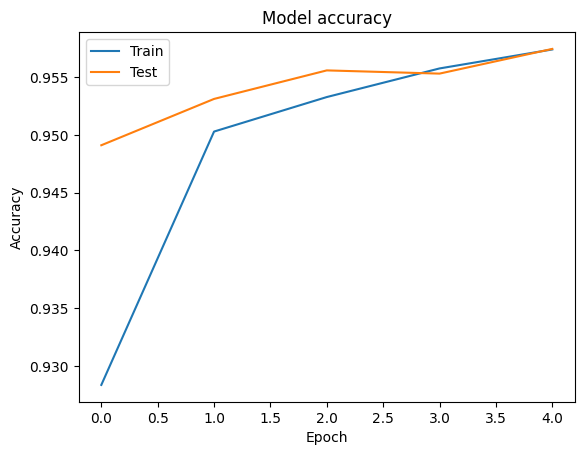

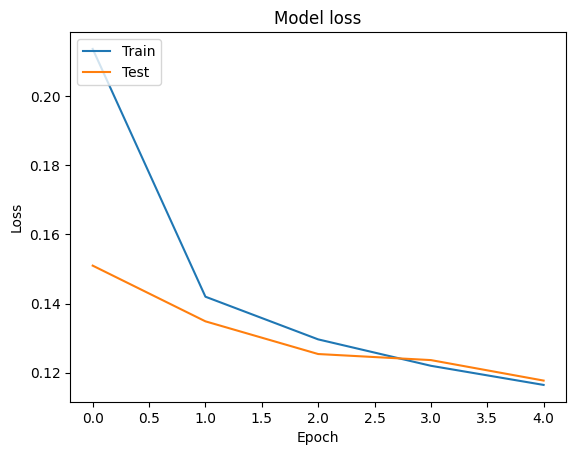

In [20]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Prediction

We can get the predictions for the validation data and check the confusion matrix to see the model's performance for each of the 5 classes. Because `tf.keras.Model.predict` method returns an n-d array for probabilities for each class, they can be converted to class labels using `np.argmax`.

In [21]:
y_pred = model.predict(validation_data)

  1/294 [..............................] - ETA: 41s

  3/294 [..............................] - ETA: 7s 

  5/294 [..............................] - ETA: 7s

  7/294 [..............................] - ETA: 7s

  9/294 [..............................] - ETA: 7s

 11/294 [>.............................] - ETA: 7s

 13/294 [>.............................] - ETA: 7s

 15/294 [>.............................] - ETA: 7s

 17/294 [>.............................] - ETA: 7s

 19/294 [>.............................] - ETA: 7s

 21/294 [=>............................] - ETA: 7s

 23/294 [=>............................] - ETA: 7s

 25/294 [=>............................] - ETA: 7s

 27/294 [=>............................] - ETA: 7s

 30/294 [==>...........................] - ETA: 6s

 32/294 [==>...........................] - ETA: 6s

 34/294 [==>...........................] - ETA: 6s

 36/294 [==>...........................] - ETA: 6s

 38/294 [==>...........................] - ETA: 6s

 40/294 [===>..........................] - ETA: 6s

 42/294 [===>..........................] - ETA: 6s

 44/294 [===>..........................] - ETA: 6s

 46/294 [===>..........................] - ETA: 6s

 48/294 [===>..........................] - ETA: 6s

 50/294 [====>.........................] - ETA: 6s

 52/294 [====>.........................] - ETA: 6s

 54/294 [====>.........................] - ETA: 6s

 56/294 [====>.........................] - ETA: 6s

 58/294 [====>.........................] - ETA: 6s

 60/294 [=====>........................] - ETA: 6s

 62/294 [=====>........................] - ETA: 6s

 65/294 [=====>........................] - ETA: 6s

 67/294 [=====>........................] - ETA: 5s

 69/294 [======>.......................] - ETA: 5s

 71/294 [======>.......................] - ETA: 5s

 73/294 [======>.......................] - ETA: 5s

 75/294 [======>.......................] - ETA: 5s

 77/294 [======>.......................] - ETA: 5s

 79/294 [=======>......................] - ETA: 5s

 81/294 [=======>......................] - ETA: 5s

 83/294 [=======>......................] - ETA: 5s

 85/294 [=======>......................] - ETA: 5s

 87/294 [=======>......................] - ETA: 5s

 90/294 [========>.....................] - ETA: 5s

 92/294 [========>.....................] - ETA: 5s

 94/294 [========>.....................] - ETA: 5s

 96/294 [========>.....................] - ETA: 5s

 98/294 [=========>....................] - ETA: 5s

100/294 [=========>....................] - ETA: 5s

102/294 [=========>....................] - ETA: 5s

104/294 [=========>....................] - ETA: 5s

106/294 [=========>....................] - ETA: 4s

108/294 [==========>...................] - ETA: 4s

110/294 [==========>...................] - ETA: 4s

112/294 [==========>...................] - ETA: 4s

114/294 [==========>...................] - ETA: 4s

116/294 [==========>...................] - ETA: 4s

118/294 [===========>..................] - ETA: 4s

120/294 [===========>..................] - ETA: 4s

122/294 [===========>..................] - ETA: 4s

124/294 [===========>..................] - ETA: 4s

126/294 [===========>..................] - ETA: 4s

128/294 [============>.................] - ETA: 4s

130/294 [============>.................] - ETA: 4s

132/294 [============>.................] - ETA: 4s

135/294 [============>.................] - ETA: 4s

137/294 [============>.................] - ETA: 4s

140/294 [=============>................] - ETA: 4s

142/294 [=============>................] - ETA: 3s

144/294 [=============>................] - ETA: 3s

146/294 [=============>................] - ETA: 3s

148/294 [==============>...............] - ETA: 3s

150/294 [==============>...............] - ETA: 3s

152/294 [==============>...............] - ETA: 3s

154/294 [==============>...............] - ETA: 3s

156/294 [==============>...............] - ETA: 3s

158/294 [===============>..............] - ETA: 3s

160/294 [===============>..............] - ETA: 3s

162/294 [===============>..............] - ETA: 3s

164/294 [===============>..............] - ETA: 3s

166/294 [===============>..............] - ETA: 3s

169/294 [================>.............] - ETA: 3s

171/294 [================>.............] - ETA: 3s

173/294 [================>.............] - ETA: 3s

176/294 [================>.............] - ETA: 3s

178/294 [=================>............] - ETA: 3s

180/294 [=================>............] - ETA: 2s

182/294 [=================>............] - ETA: 2s

184/294 [=================>............] - ETA: 2s

186/294 [=================>............] - ETA: 2s

188/294 [==================>...........] - ETA: 2s

190/294 [==================>...........] - ETA: 2s

192/294 [==================>...........] - ETA: 2s

194/294 [==================>...........] - ETA: 2s

197/294 [===================>..........] - ETA: 2s

199/294 [===================>..........] - ETA: 2s

201/294 [===================>..........] - ETA: 2s

203/294 [===================>..........] - ETA: 2s

205/294 [===================>..........] - ETA: 2s

207/294 [====================>.........] - ETA: 2s

209/294 [====================>.........] - ETA: 2s

211/294 [====================>.........] - ETA: 2s

213/294 [====================>.........] - ETA: 2s

215/294 [====================>.........] - ETA: 2s

217/294 [=====================>........] - ETA: 2s

219/294 [=====================>........] - ETA: 1s

221/294 [=====================>........] - ETA: 1s

223/294 [=====================>........] - ETA: 1s

225/294 [=====================>........] - ETA: 1s

227/294 [======================>.......] - ETA: 1s

230/294 [======================>.......] - ETA: 1s

232/294 [======================>.......] - ETA: 1s

234/294 [======================>.......] - ETA: 1s

236/294 [=======================>......] - ETA: 1s

238/294 [=======================>......] - ETA: 1s

240/294 [=======================>......] - ETA: 1s

242/294 [=======================>......] - ETA: 1s

244/294 [=======================>......] - ETA: 1s

246/294 [========================>.....] - ETA: 1s

248/294 [========================>.....] - ETA: 1s

250/294 [========================>.....] - ETA: 1s

252/294 [========================>.....] - ETA: 1s

254/294 [========================>.....] - ETA: 1s

257/294 [=========================>....] - ETA: 0s

259/294 [=========================>....] - ETA: 0s

261/294 [=========================>....] - ETA: 0s

263/294 [=========================>....] - ETA: 0s

265/294 [==========================>...] - ETA: 0s

267/294 [==========================>...] - ETA: 0s

269/294 [==========================>...] - ETA: 0s

271/294 [==========================>...] - ETA: 0s

273/294 [==========================>...] - ETA: 0s

275/294 [===========================>..] - ETA: 0s

277/294 [===========================>..] - ETA: 0s

279/294 [===========================>..] - ETA: 0s

281/294 [===========================>..] - ETA: 0s

283/294 [===========================>..] - ETA: 0s

285/294 [============================>.] - ETA: 0s

287/294 [============================>.] - ETA: 0s

289/294 [============================>.] - ETA: 0s

291/294 [============================>.] - ETA: 0s

293/294 [============================>.] - ETA: 0s

294/294 [==============================] - 8s 26ms/step


In [22]:
y_pred = np.argmax(y_pred, axis=1)

In [23]:
samples = file_paths[0:3]
for i, sample in enumerate(samples):
  f = open(sample)
  text = f.read()
  print(text[0:100])
  print("True Class: ", sample.split("/")[0])
  print("Predicted Class: ", dir_names[y_pred[i]])
  f.close()
  


বৃহস্পতিবার বিকেল। রাজধানীর তেজগাঁওয়ের কোক স্টুডিওর প্রধান ফটক পেরিয়ে ভেতরে ঢুকতেই দেখা গেল, পুলিশ
True Class:  entertainment
Predicted Class:  state

মানিকগঞ্জ পৌর এলাকার ছিদ্দিকনগরে আজ বুধবার থেকে তিন দিনব্যাপী ইজতেমা শুরু হচ্ছে। বাদ জোহর এর আনুষ্ঠ
True Class:  state
Predicted Class:  state

ফিল হিউজ অ্যাডিলেডে থাকবেন না। আবার থাকবেনও।সতীর্থর অকালমৃত্যুর শোকে এখনো আচ্ছন্ন অস্ট্রেলিয়ান খেল
True Class:  sports
Predicted Class:  state


## Compare Performance

Now we can take the correct labels for the validation data from `labels` and compare them with our predictions to get a [classification_report](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html). 

In [24]:
y_true = np.array(labels[train_size:])

In [25]:
print(classification_report(y_true, y_pred, target_names=dir_names))

               precision    recall  f1-score   support

      economy       0.83      0.77      0.80      3897
       sports       0.98      0.99      0.98     10204
entertainment       0.91      0.93      0.92      6256
        state       0.97      0.97      0.97     48512
international       0.92      0.94      0.93      6377

     accuracy                           0.96     75246
    macro avg       0.92      0.92      0.92     75246
 weighted avg       0.96      0.96      0.96     75246



We can also compare our model's performance with the published results obtained in the original [paper](https://www.researchgate.net/publication/328214545_BARD_Bangla_Article_Classification_Using_a_New_Comprehensive_Dataset), which had a 0.96 precision .The original authors described many preprocessing steps performed on the dataset, such as dropping punctuations and digits, removing top 25 most frequest stop words. As we can see in the `classification_report`, we also manage to obtain a 0.96 precision and accuracy after training for only 5 epochs without any preprocessing! 

In this example, when we created the Keras layer from our embedding module, we set the parameter`trainable=False`, which means the embedding weights will not be updated during training. Try setting it to `True` to reach around 97% accuracy using this dataset after only 2 epochs. 